<a href="https://colab.research.google.com/github/tharaka-w/PD/blob/main/Full_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===========================================
# Colab one-cell: Spiral features (healthy vs parkinson)
# - Robust center from endpoints + angular coverage
# - Direct 3-rev sampling per 5° ray (no peel)
# - Plot a few examples (for verification)
# - Extract MANY features from rings and FFT
# - Save one CSV for ALL images in both folders
# ===========================================

# --- deps ---
!pip -q install opencv-python scikit-image numpy matplotlib pandas

import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.morphology import skeletonize
from skimage.util import img_as_bool

# -------- CONFIG: paths & knobs --------
BASE_TRAIN = "/content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training"
TRAIN_HEALTHY   = os.path.join(BASE_TRAIN, "healthy")
TRAIN_PARKINSON = os.path.join(BASE_TRAIN, "parkinson")

REVS = 3                    # how many revolutions to extract per ray
ANGLE_STEP_DEG = 5.0        # 5° sampling
R_STEP_PX = 0.5             # radial sampling step along a ray
MIN_RUN_LEN = 3             # min consecutive ink pixels to accept a run
MIN_BG_GAP = 2              # min background pixels separating runs
SMOOTH_WIN = 5              # median smoothing window (odd; 0/1 disables)
FILL_GAP_DEG = 10.0         # fill NaN runs up to this many degrees

MAX_HARMONIC_TO_SHOW = 12
REMOVE_DC = True

N_VERIFY_PLOTS_PER_CLASS = 2   # how many images to PLOT from each folder (only for visual check)
RANDOM_SEED = 42
SAVE_CSV_PATH = "/content/spiral_features_new.csv"
# --------------------------------------

# ---------- binarize/polarity ----------
ADAPT_BLOCK = 41
ADAPT_C = 10
MORPH_CLOSE_K = 3
KEEP_LARGEST_IF_FRAC = 0.5
POLARITY_MIN_WHITE_FRAC = 0.55

def force_white_background(img_bin, min_white_frac=POLARITY_MIN_WHITE_FRAC):
    if float(np.mean(img_bin == 255)) < min_white_frac:
        img_bin = 255 - img_bin
    return img_bin

def binarize_conservative(img_gray):
    _, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adapt = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, ADAPT_BLOCK, ADAPT_C)
    bin_or = cv2.bitwise_or(otsu, adapt)
    bin_or = force_white_background(bin_or)
    if MORPH_CLOSE_K >= 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_CLOSE_K, MORPH_CLOSE_K))
        inv = 255 - bin_or
        inv = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, k, iterations=1)
        bin_or = 255 - inv
    return force_white_background(bin_or)

def keep_largest_component_guarded(img_bin, keep_fraction=KEEP_LARGEST_IF_FRAC):
    ink = (img_bin == 0).astype(np.uint8)
    total = int(ink.sum())
    if total == 0: return img_bin
    num, labels, stats, _ = cv2.connectedComponentsWithStats(ink, 8)
    if num <= 2: return img_bin
    areas = stats[1:, cv2.CC_STAT_AREA]
    li = 1 + int(np.argmax(areas))
    if int(areas.max()) >= keep_fraction * total:
        keep = (labels == li)
        out = np.full_like(img_bin, 255, np.uint8); out[keep] = 0
        return out
    return img_bin

# ---------- skeleton + endpoints ----------
def get_skeleton_endpoints(img_bin):
    ink = (img_bin == 0).astype(np.uint8)
    skel = skeletonize(img_as_bool(ink))
    ys, xs = np.where(skel)

    H, W = img_bin.shape
    endpoints = []
    for y, x in zip(ys, xs):
        y0, y1 = max(0, y-1), min(H, y+2)
        x0, x1 = max(0, x-1), min(W, x+2)
        nb = np.count_nonzero(skel[y0:y1, x0:x1]) - 1
        if nb == 1:
            endpoints.append((x, y))
    if len(endpoints) >= 2:
        ep = np.array(endpoints)
        best = (0, (ep[0], ep[1]))
        for i in range(len(ep)):
            d = np.sum((ep[i] - ep)**2, axis=1)
            j = int(np.argmax(d))
            if d[j] > best[0]:
                best = (d[j], (tuple(ep[i]), tuple(ep[j])))
        e1, e2 = best[1]
    elif len(endpoints) == 1:
        e1, e2 = endpoints[0], endpoints[0]
    else:
        e1 = e2 = (img_bin.shape[1]//2, img_bin.shape[0]//2)
    return skel, np.array(list(zip(xs,ys))), e1, e2

# ---------- center from endpoints + angular coverage ----------
def circular_variance(angles):
    v = np.exp(1j * angles)
    return 1.0 - np.abs(np.mean(v))  # 0 = aligned, 1 = uniform coverage

def score_center(center, pts, sample_size=400):
    cx, cy = center
    if pts.shape[0] == 0:
        return -1e9
    if pts.shape[0] > sample_size:
        idx = np.random.RandomState(0).choice(pts.shape[0], sample_size, replace=False)
        P = pts[idx]
    else:
        P = pts
    dx = P[:,0] - cx
    dy = P[:,1] - cy
    m = (dx*dx + dy*dy) > 4.0
    if not np.any(m):
        return -1e9
    ang = np.arctan2(dy[m], dx[m])  # -π..π
    ang = (ang + 2*np.pi) % (2*np.pi)
    return circular_variance(ang)

def refine_center_by_angular_coverage(img_bin, seeds, pts, coarse=5, fine=2):
    H, W = img_bin.shape
    best = (-1e9, seeds[0])
    for (sx, sy) in seeds:
        sx = int(np.clip(sx, 0, W-1)); sy = int(np.clip(sy, 0, H-1))
        cx, cy = sx, sy
        for step in [coarse, fine]:
            improved = True
            while improved:
                improved = False
                base = score_center((cx, cy), pts)
                for dx in (-step, 0, step):
                    for dy in (-step, 0, step):
                        nx, ny = int(np.clip(cx+dx, 0, W-1)), int(np.clip(cy+dy, 0, H-1))
                        sc = score_center((nx, ny), pts)
                        if sc > base:
                            cx, cy, base = nx, ny, sc
                            improved = True
                if base > best[0]:
                    best = (base, (cx, cy))
    return best[1]

def estimate_center_from_endpoints(img_bin):
    H, W = img_bin.shape
    skel, pts, e1, e2 = get_skeleton_endpoints(img_bin)
    mid = ((e1[0]+e2[0])//2, (e1[1]+e2[1])//2)
    white = (img_bin == 255).astype(np.uint8) * 255
    dist = cv2.distanceTransform(white, cv2.DIST_L2, 5)
    y, x = np.unravel_index(np.argmax(dist), dist.shape)
    dt_peak = (int(x), int(y))
    ys, xs = np.where((img_bin == 0))
    centroid = (int(np.mean(xs)) if xs.size else W//2, int(np.mean(ys)) if ys.size else H//2)
    seeds = [mid, dt_peak, centroid]
    cx, cy = refine_center_by_angular_coverage(img_bin, seeds, pts)
    return int(cx), int(cy)

# ---------- ray sampling (first K ink runs) ----------
def ray_coords(cx, cy, theta_rad, r_max, r_step=R_STEP_PX, H=None, W=None):
    r = np.arange(0.0, r_max, r_step, dtype=np.float32)
    x = cx + r*np.cos(theta_rad)
    y = cy + r*np.sin(theta_rad)
    xi = np.rint(x).astype(int)
    yi = np.rint(y).astype(int)
    if H is not None and W is not None:
        m = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
        xi, yi, r = xi[m], yi[m], r[m]
    if xi.size > 1:
        dup = (np.diff(xi)==0) & (np.diff(yi)==0)
        keep = np.ones_like(xi, bool); keep[1:] &= ~dup
        xi, yi, r = xi[keep], yi[keep], r[keep]
    return xi, yi, r

def first_k_runs_along_ray(img_bin, xi, yi, r, k=3, min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP):
    ink = (img_bin[yi, xi] == 0).astype(np.int8)
    runs = []
    i = 0
    n = len(ink)
    while i < n and len(runs) < k:
        while i < n and ink[i] == 0: i += 1
        s = i
        while i < n and ink[i] == 1: i += 1
        e = i
        if e - s >= min_run:
            runs.append(float(np.mean(r[s:e])))
        gap = 0
        while i < n and ink[i] == 0 and gap < min_gap:
            i += 1; gap += 1
    if len(runs) < k:
        runs += [np.nan]*(k - len(runs))
    return runs[:k]

def sample_rings(img_bin, cx, cy, angle_step=ANGLE_STEP_DEG, k_revs=REVS):
    H, W = img_bin.shape
    r_max = float(np.hypot(W, H))
    angles_deg = np.arange(0.0, 360.0, angle_step, dtype=float)
    rings = np.full((k_revs, len(angles_deg)), np.nan, float)
    for j, ang in enumerate(angles_deg):
        th = np.deg2rad(ang)
        xi, yi, r = ray_coords(cx, cy, th, r_max, R_STEP_PX, H, W)
        if len(xi) == 0: continue
        runs = first_k_runs_along_ray(img_bin, xi, yi, r, k=k_revs,
                                      min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP)
        rings[:, j] = runs
    return angles_deg, rings

# ---------- smoothing / fill ----------
def _median_filter_circ(arr, w):
    if w<=1 or w%2==0: return arr
    n=len(arr); out=arr.copy(); h=w//2
    for i in range(n):
        idx=[(i+d)%n for d in range(-h,h+1)]
        seg=arr[idx]; seg=seg[np.isfinite(seg)]
        if seg.size: out[i]=np.median(seg)
    return out

def _fill_small_gaps(arr, max_gap_bins):
    out=arr.copy(); n=len(arr); i=0
    while i<n:
        if np.isnan(out[i]):
            j=i
            while j<n and np.isnan(out[j]): j+=1
            if i>0 and j<n and (j-i)<=max_gap_bins:
                out[i:j]=np.linspace(out[i-1], out[j], (j-i)+2)[1:-1]
            i=j
        else: i+=1
    return out

def tidy_rings(rings, angle_step=ANGLE_STEP_DEG, smooth_win=SMOOTH_WIN, fill_gap_deg=FILL_GAP_DEG):
    max_gap_bins = int(round(fill_gap_deg/angle_step)) if fill_gap_deg>0 else 0
    out=rings.copy()
    for k in range(out.shape[0]):
        r=out[k]
        if max_gap_bins>0: r=_fill_small_gaps(r, max_gap_bins)
        if smooth_win and smooth_win%2==1 and smooth_win>1: r=_median_filter_circ(r, smooth_win)
        out[k]=r
    return out

# ---------- FFT ----------
def ring_fft(sig):
    x=sig.astype(float)
    if np.any(~np.isfinite(x)):
        n=len(x); idx=np.arange(n); m=np.isfinite(x)
        if m.sum()==0: x=np.zeros_like(x)
        else:
            xi=np.concatenate([idx[m], idx[m]+n]); yi=np.concatenate([x[m],x[m]])
            idx2=idx.copy(); idx2[idx<idx[m].min()]+=n
            x=np.interp(idx2, xi, yi)
    if REMOVE_DC: x=x-np.mean(x)
    R=np.fft.rfft(x); mag=np.abs(R)/len(x); mag[1:-1]*=2.0
    h=np.arange(len(mag)); return h, mag

# ---------- plotting ----------
def plot_all(img_gray, img_bin, cx, cy, angles, rings, fft_h, fft_mag, title):
    colors=['red','green','blue','purple','orange']
    fig=plt.figure(figsize=(20,6))
    gs=fig.add_gridspec(1,3,width_ratios=[1.2,1.5,1.3])
    ax0=fig.add_subplot(gs[0,0]); ax1=fig.add_subplot(gs[0,1]); ax2=fig.add_subplot(gs[0,2])

    ax0.imshow(img_gray,cmap='gray',alpha=0.25)
    ax0.imshow(img_bin,cmap='gray',alpha=0.75)
    H,W=img_bin.shape; edge=int(np.hypot(W,H))
    for ang in angles:
        x2=int(round(cx+edge*np.cos(np.deg2rad(ang))))
        y2=int(round(cy+edge*np.sin(np.deg2rad(ang))))
        ax0.plot([cx,x2],[cy,y2],color='yellow',alpha=0.08,linewidth=1)
    for k in range(min(REVS, rings.shape[0])):
        m=np.isfinite(rings[k]); th=np.deg2rad(angles[m]); rr=rings[k,m]
        xs=cx+rr*np.cos(th); ys=cy+rr*np.sin(th)
        ax0.plot(xs,ys,'.',color=colors[k%len(colors)],markersize=3,label=f"Rev {k+1}")
    ax0.scatter(cx,cy,c='yellow',s=40,label='Center'); ax0.axis('off'); ax0.legend(loc='lower right',fontsize=8)
    ax0.set_title(f"Center from endpoints + coverage — {title}")

    for k in range(min(REVS, rings.shape[0])):
        ax1.plot(angles+360.0*k, rings[k], color=colors[k%len(colors)], linewidth=1.4, label=f"Rev {k+1}")
    ax1.set_xlim(0, 360.0*REVS); ax1.grid(True,alpha=0.3)
    ax1.set_xlabel("Angle progress (degrees)"); ax1.set_ylabel("Radius from center (px)")
    ax1.set_title(f"Radial Distance vs Angle ({ANGLE_STEP_DEG:.0f}°)"); ax1.legend()

    for k in range(min(REVS, rings.shape[0])):
        h, m = fft_h[k], fft_mag[k]; mask = (h<=MAX_HARMONIC_TO_SHOW)
        ax2.plot(h[mask], m[mask], marker='o', linewidth=1.2, label=f"Rev {k+1}", color=colors[k%len(colors)])
    ax2.set_xlabel("Harmonic (cycles/rev)"); ax2.set_ylabel("FFT magnitude (norm)")
    ax2.set_title("FFT of Radial Distance"); ax2.grid(True,alpha=0.3); ax2.legend()
    if REMOVE_DC: ax2.set_xlim(0.5, MAX_HARMONIC_TO_SHOW)
    else:         ax2.set_xlim(0, MAX_HARMONIC_TO_SHOW)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---------- Feature extraction ----------
def _finite(x): return np.isfinite(x)

def _linfit_slope_deg(angles_deg, y):
    m = _finite(y)
    if m.sum() < 6: return np.nan
    x = angles_deg[m]
    yy = y[m]
    x = x - x.mean()
    denom = (x*x).sum()
    if denom == 0: return 0.0
    return float((x*yy).sum()/denom)

def _num_gaps_and_maxgap(ang, y):
    m = _finite(y)
    if m.all(): return 0, 0.0
    mask = ~m.astype(bool)
    gaps = 0; maxgap = 0.0
    n = len(mask)
    i = 0
    step_deg = float(ang[1]-ang[0])
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]: j += 1
            gaps += 1
            maxgap = max(maxgap, (j - i) * step_deg)
            i = j
        else:
            i += 1
    if mask[0] and mask[-1]:
        i0 = 0
        while i0 < n and mask[i0]: i0 += 1
        jn = n-1
        while jn >= 0 and mask[jn]: jn -= 1
        merged = (i0 + (n-1-jn)) * step_deg
        maxgap = max(maxgap, merged)
        gaps = max(0, gaps-1)
    return gaps, float(maxgap)

def _residuals(y):
    m = _finite(y)
    if m.sum()==0: return np.full_like(y, np.nan, dtype=float)
    med = np.nanmedian(y)
    r = y - med
    r[~m] = np.nan
    return r

def _derivative(x):
    y = x.copy()
    m = _finite(y)
    if m.sum() < 3: return np.full_like(y, np.nan, dtype=float)
    # circular forward diff
    d = np.roll(y, -1) - y
    d[~m] = np.nan
    return d

def _zcr(x):
    m = _finite(x)
    x = x[m]
    if len(x) < 3: return np.nan
    s = np.sign(x)
    s[s==0] = 1
    return float(np.mean(s[:-1] != s[1:]))

def _safe_corr(a, b):
    m = _finite(a) & _finite(b)
    if m.sum() < 6: return np.nan
    aa = a[m]; bb = b[m]
    if np.std(aa)==0 or np.std(bb)==0: return np.nan
    return float(np.corrcoef(aa, bb)[0,1])

def _spec_bands(h, mag):
    # ignore DC (0)
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan, np.nan, np.nan
    hh = h[m]; mm = mag[m]
    low = (hh>=2) & (hh<=4)
    mid = (hh>=5) & (hh<=8)
    high= (hh>=9) & (hh<=12)
    e_low  = float((mm[low]**2).sum()) if np.any(low) else 0.0
    e_mid  = float((mm[mid]**2).sum()) if np.any(mid) else 0.0
    e_high = float((mm[high]**2).sum()) if np.any(high) else 0.0
    return e_low, e_mid, e_high

def _spec_centroid(h, mag):
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); mm = mag[m].astype(float)
    s = mm.sum()
    if s==0: return np.nan
    return float((hh*mm).sum()/s)

def _spec_entropy(mag):
    m = _finite(mag)
    mm = mag[m].astype(float)
    if mm.size == 0: return np.nan
    s = mm.sum()
    if s <= 0: return np.nan
    p = mm / s
    p = p[p>0]
    return float(-(p*np.log(p)).sum())

def _spec_decay(h, mag):
    m = (h>=1) & _finite(mag) & (mag>0)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); lg = np.log(mag[m].astype(float))
    X = np.vstack([hh, np.ones_like(hh)]).T
    w = np.linalg.lstsq(X, lg, rcond=None)[0]
    return float(w[0])  # slope (more negative = steeper decay)

def compute_features(angles_deg, rings, fft_h, fft_mag):
    out = {}
    step_deg = float(angles_deg[1] - angles_deg[0]) if len(angles_deg)>1 else ANGLE_STEP_DEG

    for k in range(REVS):
        r = rings[k]
        m = _finite(r)
        coverage = float(np.mean(m)) if r.size else 0.0
        gaps, maxgap = _num_gaps_and_maxgap(angles_deg, r)

        out[f"r{k+1}_coverage_frac"] = coverage
        out[f"r{k+1}_num_gaps"]      = gaps
        out[f"r{k+1}_max_gap_deg"]   = maxgap

        out[f"r{k+1}_mean"]   = float(np.nanmean(r)) if m.any() else np.nan
        out[f"r{k+1}_median"] = float(np.nanmedian(r)) if m.any() else np.nan
        out[f"r{k+1}_std"]    = float(np.nanstd(r)) if m.any() else np.nan
        out[f"r{k+1}_ptp"]    = float(np.nanmax(r)-np.nanmin(r)) if m.any() else np.nan
        out[f"r{k+1}_slope_deg"] = _linfit_slope_deg(angles_deg, r)

        # monotonic breaks (sign changes in derivative of r)
        dr = _derivative(r)
        if np.all(~_finite(dr)):
            out[f"r{k+1}_monotonic_breaks"] = np.nan
        else:
            s = np.sign(dr)
            s[~_finite(s)] = 0
            s[s==0] = 1
            out[f"r{k+1}_monotonic_breaks"] = float(np.sum(s[:-1] != s[1:]))

        # residual-based roughness
        res = _residuals(r)
        out[f"r{k+1}_res_rms"] = float(np.sqrt(np.nanmean(res**2))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_mad"] = float(np.nanmedian(np.abs(res - np.nanmedian(res)))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_ptp"] = float(np.nanmax(res)-np.nanmin(res)) if _finite(res).any() else np.nan
        dres = _derivative(res)
        out[f"r{k+1}_deriv_rms"] = float(np.sqrt(np.nanmean(dres**2))) if _finite(dres).any() else np.nan
        out[f"r{k+1}_zcr"] = _zcr(dres)

        # spectrum
        h = fft_h[k]; mag = fft_mag[k]
        if REMOVE_DC:
            h0 = h[1:]; mag0 = mag[1:]
        else:
            h0 = h.copy(); mag0 = mag.copy()
        if mag0.size:
            dom_idx = int(np.argmax(mag0))
            out[f"r{k+1}_dom_harm"] = int(h0[dom_idx])
            out[f"r{k+1}_dom_amp"]  = float(mag0[dom_idx])
        else:
            out[f"r{k+1}_dom_harm"] = np.nan
            out[f"r{k+1}_dom_amp"]  = np.nan

        e_low, e_mid, e_high = _spec_bands(h, mag)
        out[f"r{k+1}_E_low_2_4"]  = e_low
        out[f"r{k+1}_E_mid_5_8"]  = e_mid
        out[f"r{k+1}_E_high_9_12"] = e_high
        out[f"r{k+1}_E_hi_lo_ratio"] = float(e_high / e_low) if e_low>0 else np.nan
        out[f"r{k+1}_spec_centroid"] = _spec_centroid(h, mag)
        out[f"r{k+1}_spec_entropy"]  = _spec_entropy(mag)
        out[f"r{k+1}_spec_decay"]    = _spec_decay(h, mag)

    # inter-ring spacing & coherence
    for (a,b) in [(0,1),(1,2)]:
        if a < rings.shape[0] and b < rings.shape[0]:
            ra, rb = rings[a], rings[b]
            spacing = rb - ra
            m = _finite(spacing)
            out[f"r{a+1}{b+1}_spacing_mean"] = float(np.nanmean(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_std"]  = float(np.nanstd(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_min"]  = float(np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_ptp"]  = float(np.nanmax(spacing)-np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_cv"]   = (out[f"r{a+1}{b+1}_spacing_std"] / out[f"r{a+1}{b+1}_spacing_mean"]) if m.any() and out[f"r{a+1}{b+1}_spacing_mean"] not in [0, np.nan] else np.nan
            # crossings: inner > outer? (spacing < 0)
            out[f"r{a+1}{b+1}_crossing_frac"] = float(np.mean(spacing[m] < 0.0)) if m.any() else np.nan

            # residual correlation
            res_a = _residuals(ra)
            res_b = _residuals(rb)
            out[f"r{a+1}{b+1}_corr_resid"] = _safe_corr(res_a, res_b)

            # fft magnitude correlation
            out[f"r{a+1}{b+1}_corr_fft"] = _safe_corr(fft_mag[a], fft_mag[b])

    return out

# ---------- run folders, plot some, write CSV ----------
def list_images(folder):
    exts=("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    paths=[]
    for e in exts: paths+=glob.glob(os.path.join(folder,e))
    paths.sort()
    return paths

def process_image(path):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise ValueError(f"Cannot read: {path}")
    img_bin = binarize_conservative(img_gray)
    img_bin = keep_largest_component_guarded(img_bin, KEEP_LARGEST_IF_FRAC)
    img_bin = force_white_background(img_bin)

    cx, cy = estimate_center_from_endpoints(img_bin)
    angles, rings_raw = sample_rings(img_bin, cx, cy, ANGLE_STEP_DEG, REVS)
    rings = tidy_rings(rings_raw, ANGLE_STEP_DEG, SMOOTH_WIN, FILL_GAP_DEG)

    fft_h=[]; fft_mag=[]
    for k in range(REVS):
        h,m = ring_fft(rings[k]); fft_h.append(h); fft_mag.append(m)

    return {
        "img_gray": img_gray, "img_bin": img_bin,
        "center": (cx, cy), "angles": angles,
        "rings": rings, "fft_h": fft_h, "fft_mag": fft_mag
    }

def run_and_export():
    rows = []
    random.seed(RANDOM_SEED)
    to_plot = []

    for folder, label in [(TRAIN_HEALTHY, "healthy"), (TRAIN_PARKINSON, "parkinson")]:
        if not os.path.isdir(folder):
            print(f"Skip (missing): {folder}")
            continue
        paths = list_images(folder)
        if not paths:
            print(f"No images in: {folder}")
            continue

        # choose a few to plot
        sample = random.sample(paths, min(N_VERIFY_PLOTS_PER_CLASS, len(paths)))
        to_plot += [(p, label) for p in sample]

        # process all for CSV
        for p in paths:
            try:
                res = process_image(p)
                feats = compute_features(res["angles"], res["rings"], res["fft_h"], res["fft_mag"])
                feats_row = {
                    "path": p,
                    "label": label,
                    "center_x": res["center"][0],
                    "center_y": res["center"][1],
                }
                feats_row.update(feats)
                rows.append(feats_row)
            except Exception as e:
                print(f"Error on {p}: {e}")

    # save CSV
    df = pd.DataFrame(rows)
    df.to_csv(SAVE_CSV_PATH, index=False)
    print(f"\n✅ Saved features CSV: {SAVE_CSV_PATH}")
    print(f"Rows: {len(df)}  |  Columns: {len(df.columns)}")

    # plot a few examples
    for p, label in to_plot:
        print(f"\n▶ Plot: {os.path.basename(p)}  [{label}]")
        res = process_image(p)
        # prepare FFT arrays for plotting up to MAX_HARMONIC_TO_SHOW
        fft_h, fft_mag = [], []
        for k in range(REVS):
            h, m = res["fft_h"][k], res["fft_mag"][k]
            mask = h <= MAX_HARMONIC_TO_SHOW
            fft_h.append(h[mask]); fft_mag.append(m[mask])
        plot_all(res["img_gray"], res["img_bin"], res["center"][0], res["center"][1],
                 res["angles"], res["rings"], fft_h, fft_mag, os.path.basename(p))

run_and_export()


Skip (missing): /content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training/healthy
Skip (missing): /content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training/parkinson

✅ Saved features CSV: /content/spiral_features_new.csv
Rows: 0  |  Columns: 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to dataset
dataset_path = '/content/drive/MyDrive/PD_Spiral_Dataset'




Mounted at /content/drive



✅ Saved features CSV: /content/spiral_features_new.csv
Rows: 129  |  Columns: 89

▶ Plot: V08HE02.png  [healthy]


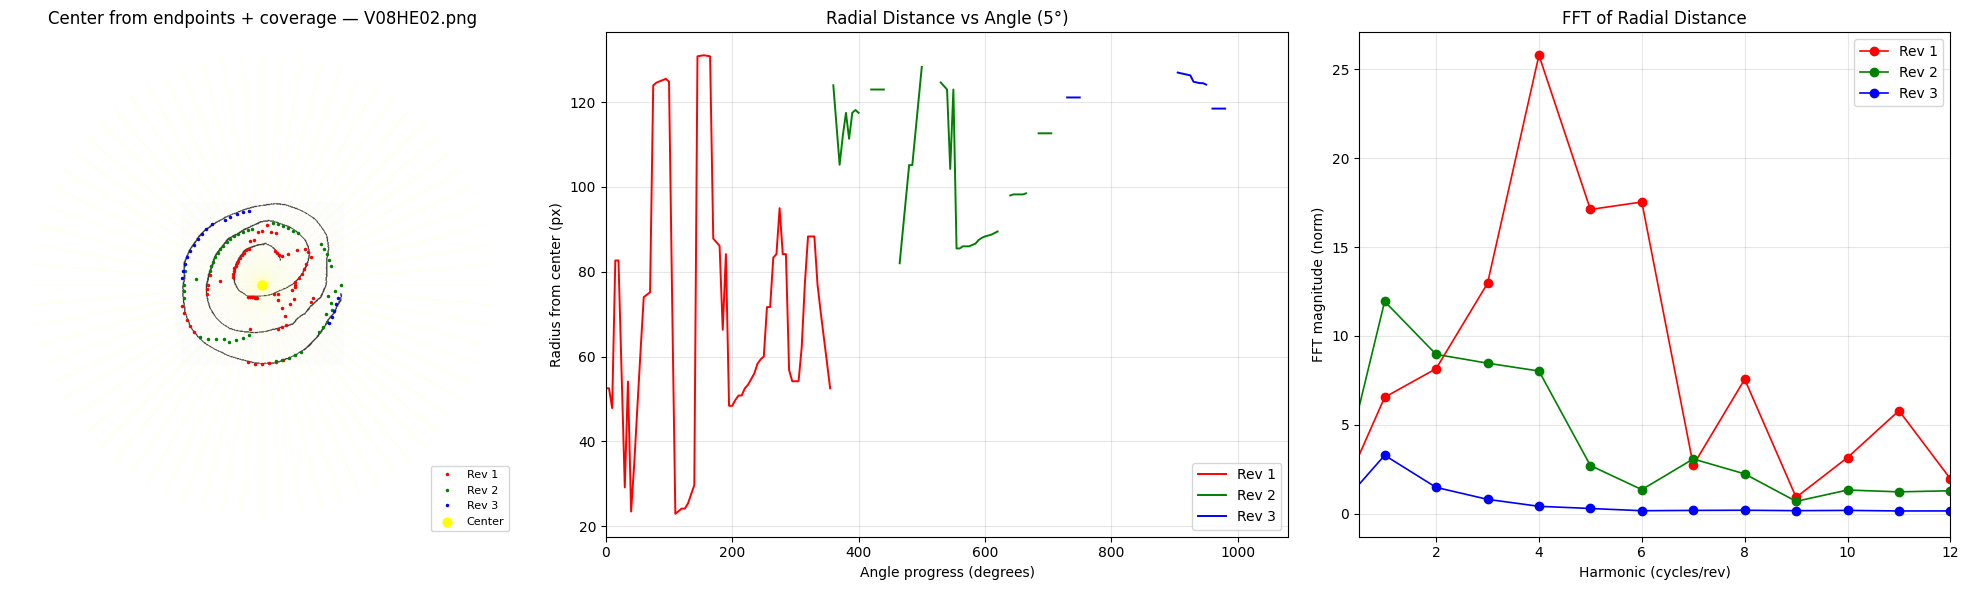


▶ Plot: V02HE03.png  [healthy]


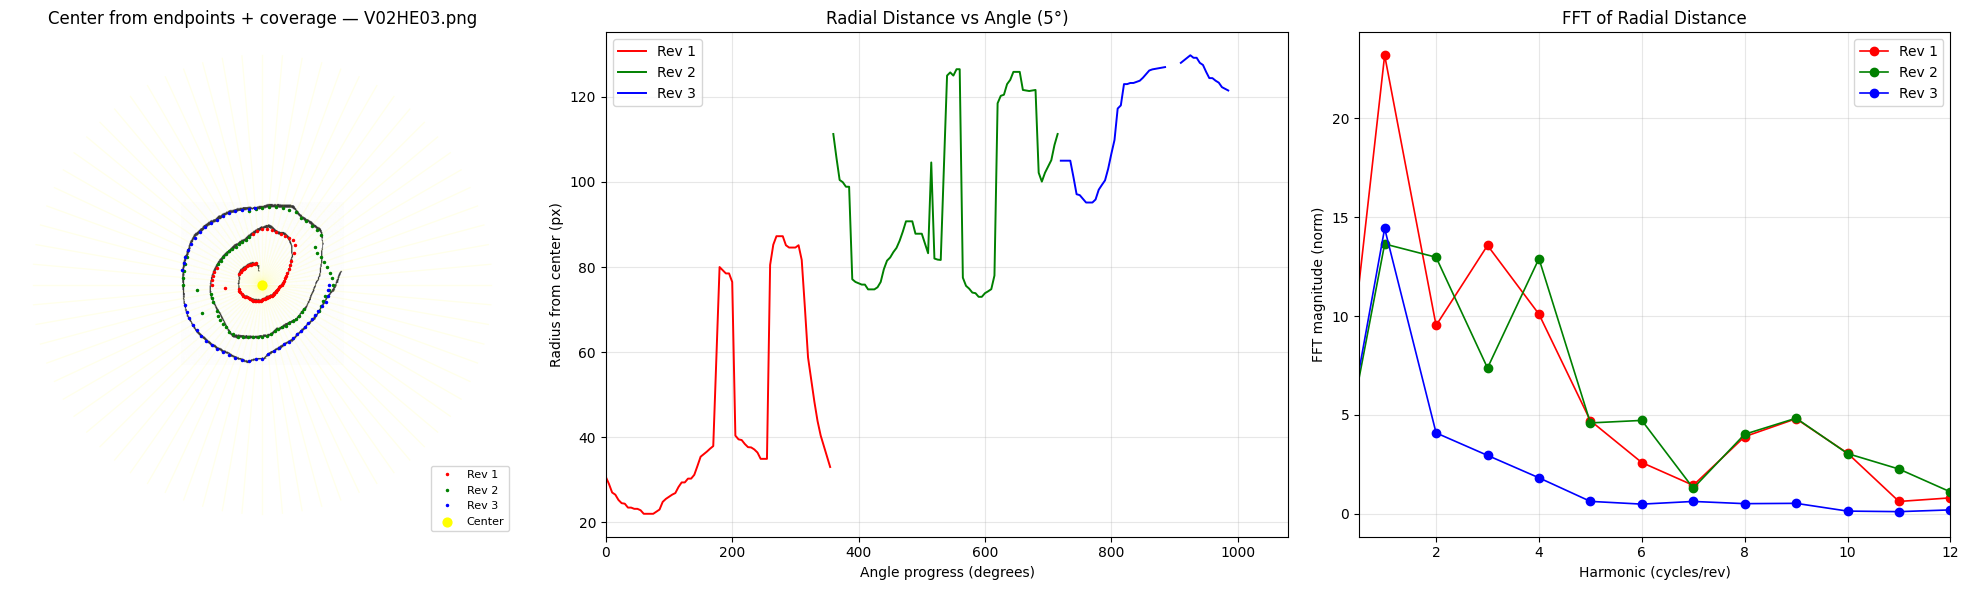


▶ Plot: V15PE03.png  [parkinson]


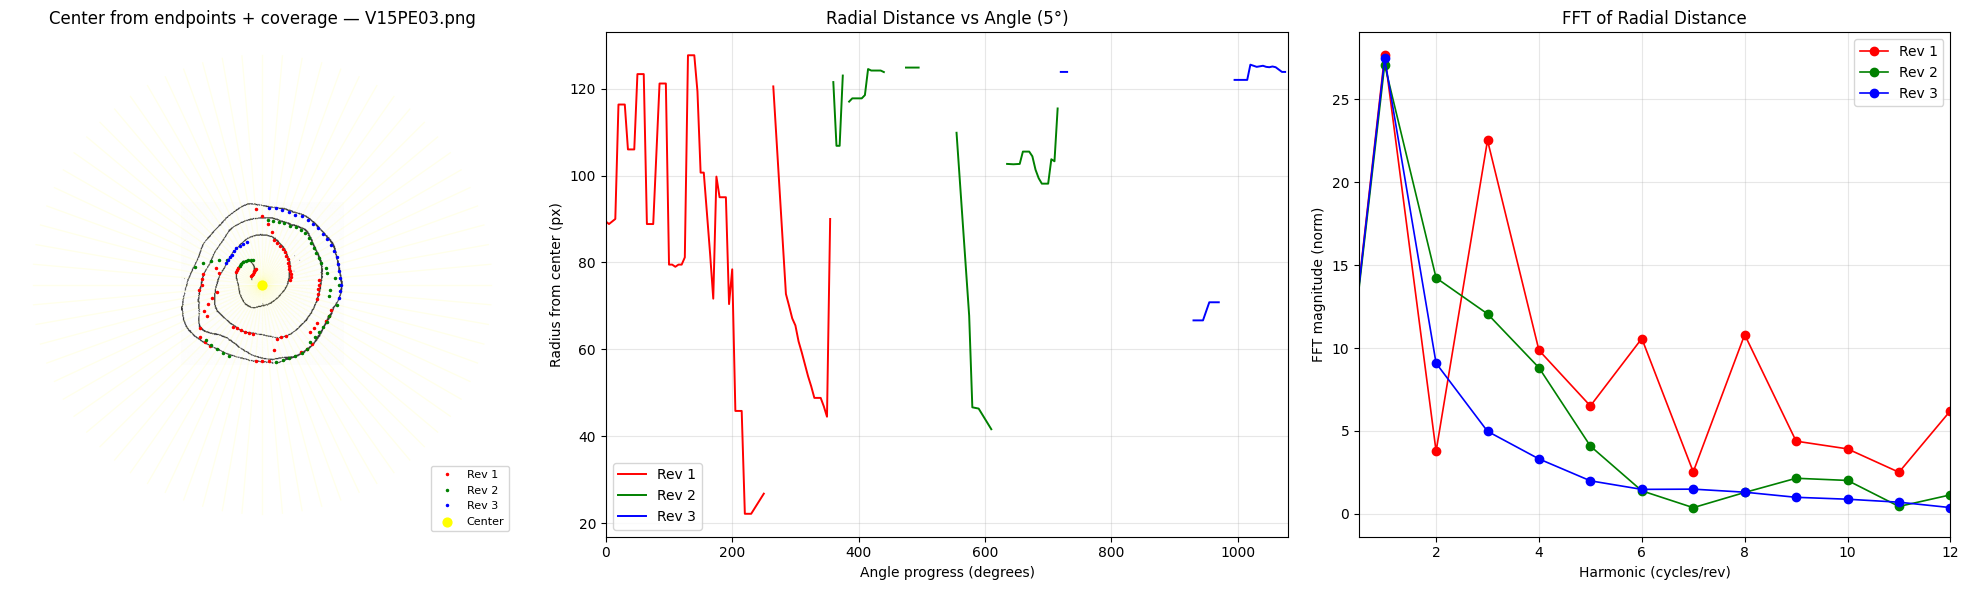


▶ Plot: V13PE03.png  [parkinson]


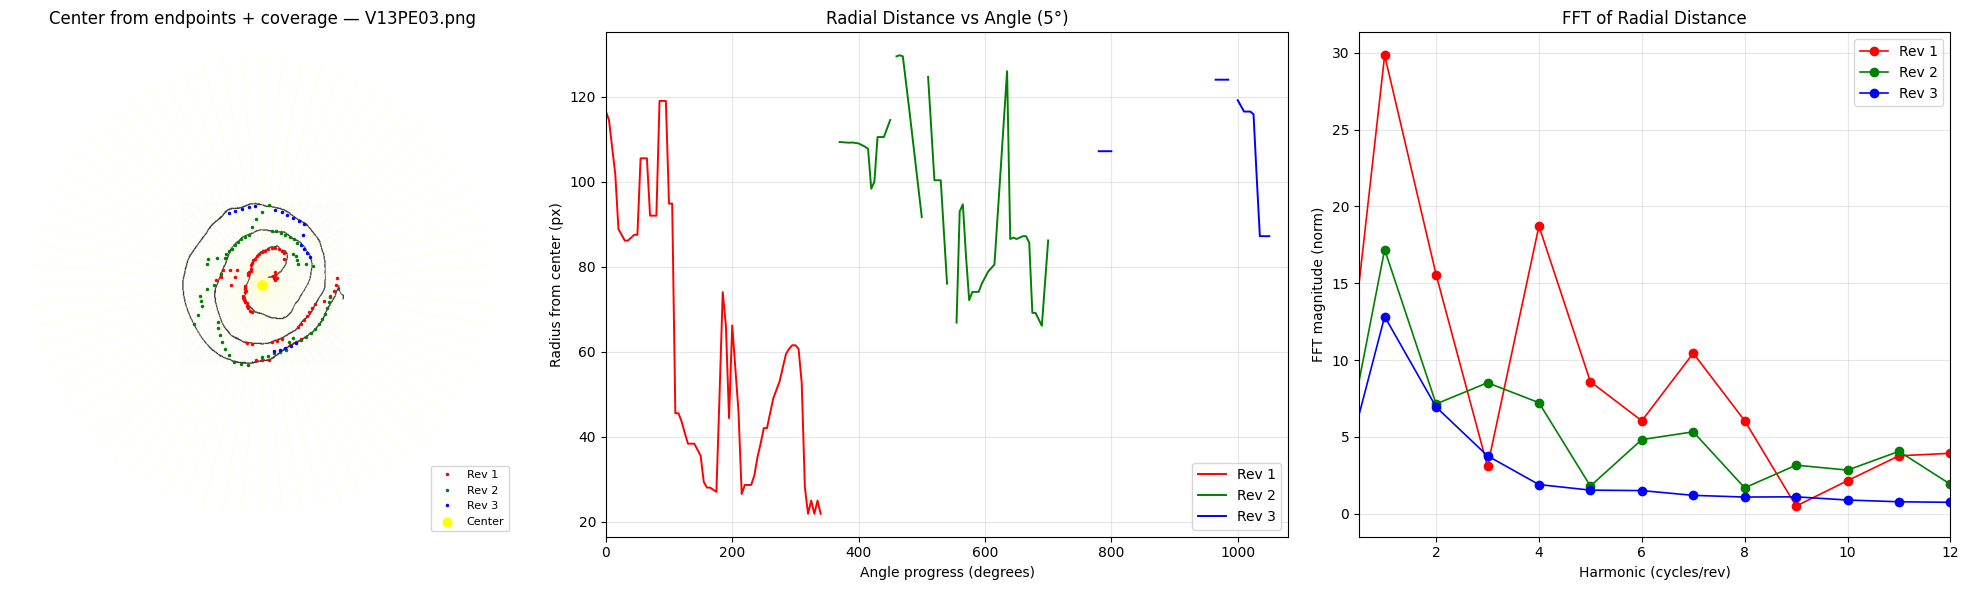

In [ ]:
# ===========================================
# Colab one-cell: Spiral features (healthy vs parkinson)
# - Robust center from endpoints + angular coverage
# - Direct 3-rev sampling per 5° ray (no peel)
# - Plot a few examples (for verification)
# - Extract MANY features from rings and FFT
# - Save one CSV for ALL images in both folders
# ===========================================

# --- deps ---
!pip -q install opencv-python scikit-image numpy matplotlib pandas

import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.morphology import skeletonize
from skimage.util import img_as_bool

# -------- CONFIG: paths & knobs --------
BASE_TRAIN = "/content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training"
TRAIN_HEALTHY   = os.path.join(BASE_TRAIN, "healthy")
TRAIN_PARKINSON = os.path.join(BASE_TRAIN, "parkinson")

REVS = 3                    # how many revolutions to extract per ray
ANGLE_STEP_DEG = 5.0        # 5° sampling
R_STEP_PX = 0.5             # radial sampling step along a ray
MIN_RUN_LEN = 3             # min consecutive ink pixels to accept a run
MIN_BG_GAP = 2              # min background pixels separating runs
SMOOTH_WIN = 5              # median smoothing window (odd; 0/1 disables)
FILL_GAP_DEG = 10.0         # fill NaN runs up to this many degrees

MAX_HARMONIC_TO_SHOW = 12
REMOVE_DC = True

N_VERIFY_PLOTS_PER_CLASS = 2   # how many images to PLOT from each folder (only for visual check)
RANDOM_SEED = 42
SAVE_CSV_PATH = "/content/spiral_features_new.csv"
# --------------------------------------

# ---------- binarize/polarity ----------
ADAPT_BLOCK = 41
ADAPT_C = 10
MORPH_CLOSE_K = 3
KEEP_LARGEST_IF_FRAC = 0.5
POLARITY_MIN_WHITE_FRAC = 0.55

def force_white_background(img_bin, min_white_frac=POLARITY_MIN_WHITE_FRAC):
    if float(np.mean(img_bin == 255)) < min_white_frac:
        img_bin = 255 - img_bin
    return img_bin

def binarize_conservative(img_gray):
    _, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adapt = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, ADAPT_BLOCK, ADAPT_C)
    bin_or = cv2.bitwise_or(otsu, adapt)
    bin_or = force_white_background(bin_or)
    if MORPH_CLOSE_K >= 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_CLOSE_K, MORPH_CLOSE_K))
        inv = 255 - bin_or
        inv = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, k, iterations=1)
        bin_or = 255 - inv
    return force_white_background(bin_or)

def keep_largest_component_guarded(img_bin, keep_fraction=KEEP_LARGEST_IF_FRAC):
    ink = (img_bin == 0).astype(np.uint8)
    total = int(ink.sum())
    if total == 0: return img_bin
    num, labels, stats, _ = cv2.connectedComponentsWithStats(ink, 8)
    if num <= 2: return img_bin
    areas = stats[1:, cv2.CC_STAT_AREA]
    li = 1 + int(np.argmax(areas))
    if int(areas.max()) >= keep_fraction * total:
        keep = (labels == li)
        out = np.full_like(img_bin, 255, np.uint8); out[keep] = 0
        return out
    return img_bin

# ---------- skeleton + endpoints ----------
def get_skeleton_endpoints(img_bin):
    ink = (img_bin == 0).astype(np.uint8)
    skel = skeletonize(img_as_bool(ink))
    ys, xs = np.where(skel)

    H, W = img_bin.shape
    endpoints = []
    for y, x in zip(ys, xs):
        y0, y1 = max(0, y-1), min(H, y+2)
        x0, x1 = max(0, x-1), min(W, x+2)
        nb = np.count_nonzero(skel[y0:y1, x0:x1]) - 1
        if nb == 1:
            endpoints.append((x, y))
    if len(endpoints) >= 2:
        ep = np.array(endpoints)
        best = (0, (ep[0], ep[1]))
        for i in range(len(ep)):
            d = np.sum((ep[i] - ep)**2, axis=1)
            j = int(np.argmax(d))
            if d[j] > best[0]:
                best = (d[j], (tuple(ep[i]), tuple(ep[j])))
        e1, e2 = best[1]
    elif len(endpoints) == 1:
        e1, e2 = endpoints[0], endpoints[0]
    else:
        e1 = e2 = (img_bin.shape[1]//2, img_bin.shape[0]//2)
    return skel, np.array(list(zip(xs,ys))), e1, e2

# ---------- center from endpoints + angular coverage ----------
def circular_variance(angles):
    v = np.exp(1j * angles)
    return 1.0 - np.abs(np.mean(v))  # 0 = aligned, 1 = uniform coverage

def score_center(center, pts, sample_size=400):
    cx, cy = center
    if pts.shape[0] == 0:
        return -1e9
    if pts.shape[0] > sample_size:
        idx = np.random.RandomState(0).choice(pts.shape[0], sample_size, replace=False)
        P = pts[idx]
    else:
        P = pts
    dx = P[:,0] - cx
    dy = P[:,1] - cy
    m = (dx*dx + dy*dy) > 4.0
    if not np.any(m):
        return -1e9
    ang = np.arctan2(dy[m], dx[m])  # -π..π
    ang = (ang + 2*np.pi) % (2*np.pi)
    return circular_variance(ang)

def refine_center_by_angular_coverage(img_bin, seeds, pts, coarse=5, fine=2):
    H, W = img_bin.shape
    best = (-1e9, seeds[0])
    for (sx, sy) in seeds:
        sx = int(np.clip(sx, 0, W-1)); sy = int(np.clip(sy, 0, H-1))
        cx, cy = sx, sy
        for step in [coarse, fine]:
            improved = True
            while improved:
                improved = False
                base = score_center((cx, cy), pts)
                for dx in (-step, 0, step):
                    for dy in (-step, 0, step):
                        nx, ny = int(np.clip(cx+dx, 0, W-1)), int(np.clip(cy+dy, 0, H-1))
                        sc = score_center((nx, ny), pts)
                        if sc > base:
                            cx, cy, base = nx, ny, sc
                            improved = True
                if base > best[0]:
                    best = (base, (cx, cy))
    return best[1]

def estimate_center_from_endpoints(img_bin):
    H, W = img_bin.shape
    skel, pts, e1, e2 = get_skeleton_endpoints(img_bin)
    mid = ((e1[0]+e2[0])//2, (e1[1]+e2[1])//2)
    white = (img_bin == 255).astype(np.uint8) * 255
    dist = cv2.distanceTransform(white, cv2.DIST_L2, 5)
    y, x = np.unravel_index(np.argmax(dist), dist.shape)
    dt_peak = (int(x), int(y))
    ys, xs = np.where((img_bin == 0))
    centroid = (int(np.mean(xs)) if xs.size else W//2, int(np.mean(ys)) if ys.size else H//2)
    seeds = [mid, dt_peak, centroid]
    cx, cy = refine_center_by_angular_coverage(img_bin, seeds, pts)
    return int(cx), int(cy)

# ---------- ray sampling (first K ink runs) ----------
def ray_coords(cx, cy, theta_rad, r_max, r_step=R_STEP_PX, H=None, W=None):
    r = np.arange(0.0, r_max, r_step, dtype=np.float32)
    x = cx + r*np.cos(theta_rad)
    y = cy + r*np.sin(theta_rad)
    xi = np.rint(x).astype(int)
    yi = np.rint(y).astype(int)
    if H is not None and W is not None:
        m = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
        xi, yi, r = xi[m], yi[m], r[m]
    if xi.size > 1:
        dup = (np.diff(xi)==0) & (np.diff(yi)==0)
        keep = np.ones_like(xi, bool); keep[1:] &= ~dup
        xi, yi, r = xi[keep], yi[keep], r[keep]
    return xi, yi, r

def first_k_runs_along_ray(img_bin, xi, yi, r, k=3, min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP):
    ink = (img_bin[yi, xi] == 0).astype(np.int8)
    runs = []
    i = 0
    n = len(ink)
    while i < n and len(runs) < k:
        while i < n and ink[i] == 0: i += 1
        s = i
        while i < n and ink[i] == 1: i += 1
        e = i
        if e - s >= min_run:
            runs.append(float(np.mean(r[s:e])))
        gap = 0
        while i < n and ink[i] == 0 and gap < min_gap:
            i += 1; gap += 1
    if len(runs) < k:
        runs += [np.nan]*(k - len(runs))
    return runs[:k]

def sample_rings(img_bin, cx, cy, angle_step=ANGLE_STEP_DEG, k_revs=REVS):
    H, W = img_bin.shape
    r_max = float(np.hypot(W, H))
    angles_deg = np.arange(0.0, 360.0, angle_step, dtype=float)
    rings = np.full((k_revs, len(angles_deg)), np.nan, float)
    for j, ang in enumerate(angles_deg):
        th = np.deg2rad(ang)
        xi, yi, r = ray_coords(cx, cy, th, r_max, R_STEP_PX, H, W)
        if len(xi) == 0: continue
        runs = first_k_runs_along_ray(img_bin, xi, yi, r, k=k_revs,
                                      min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP)
        rings[:, j] = runs
    return angles_deg, rings

# ---------- smoothing / fill ----------
def _median_filter_circ(arr, w):
    if w<=1 or w%2==0: return arr
    n=len(arr); out=arr.copy(); h=w//2
    for i in range(n):
        idx=[(i+d)%n for d in range(-h,h+1)]
        seg=arr[idx]; seg=seg[np.isfinite(seg)]
        if seg.size: out[i]=np.median(seg)
    return out

def _fill_small_gaps(arr, max_gap_bins):
    out=arr.copy(); n=len(arr); i=0
    while i<n:
        if np.isnan(out[i]):
            j=i
            while j<n and np.isnan(out[j]): j+=1
            if i>0 and j<n and (j-i)<=max_gap_bins:
                out[i:j]=np.linspace(out[i-1], out[j], (j-i)+2)[1:-1]
            i=j
        else: i+=1
    return out

def tidy_rings(rings, angle_step=ANGLE_STEP_DEG, smooth_win=SMOOTH_WIN, fill_gap_deg=FILL_GAP_DEG):
    max_gap_bins = int(round(fill_gap_deg/angle_step)) if fill_gap_deg>0 else 0
    out=rings.copy()
    for k in range(out.shape[0]):
        r=out[k]
        if max_gap_bins>0: r=_fill_small_gaps(r, max_gap_bins)
        if smooth_win and smooth_win%2==1 and smooth_win>1: r=_median_filter_circ(r, smooth_win)
        out[k]=r
    return out

# ---------- FFT ----------
def ring_fft(sig):
    x=sig.astype(float)
    if np.any(~np.isfinite(x)):
        n=len(x); idx=np.arange(n); m=np.isfinite(x)
        if m.sum()==0: x=np.zeros_like(x)
        else:
            xi=np.concatenate([idx[m], idx[m]+n]); yi=np.concatenate([x[m],x[m]])
            idx2=idx.copy(); idx2[idx<idx[m].min()]+=n
            x=np.interp(idx2, xi, yi)
    if REMOVE_DC: x=x-np.mean(x)
    R=np.fft.rfft(x); mag=np.abs(R)/len(x); mag[1:-1]*=2.0
    h=np.arange(len(mag)); return h, mag

# ---------- plotting ----------
def plot_all(img_gray, img_bin, cx, cy, angles, rings, fft_h, fft_mag, title):
    colors=['red','green','blue','purple','orange']
    fig=plt.figure(figsize=(20,6))
    gs=fig.add_gridspec(1,3,width_ratios=[1.2,1.5,1.3])
    ax0=fig.add_subplot(gs[0,0]); ax1=fig.add_subplot(gs[0,1]); ax2=fig.add_subplot(gs[0,2])

    ax0.imshow(img_gray,cmap='gray',alpha=0.25)
    ax0.imshow(img_bin,cmap='gray',alpha=0.75)
    H,W=img_bin.shape; edge=int(np.hypot(W,H))
    for ang in angles:
        x2=int(round(cx+edge*np.cos(np.deg2rad(ang))))
        y2=int(round(cy+edge*np.sin(np.deg2rad(ang))))
        ax0.plot([cx,x2],[cy,y2],color='yellow',alpha=0.08,linewidth=1)
    for k in range(min(REVS, rings.shape[0])):
        m=np.isfinite(rings[k]); th=np.deg2rad(angles[m]); rr=rings[k,m]
        xs=cx+rr*np.cos(th); ys=cy+rr*np.sin(th)
        ax0.plot(xs,ys,'.',color=colors[k%len(colors)],markersize=3,label=f"Rev {k+1}")
    ax0.scatter(cx,cy,c='yellow',s=40,label='Center'); ax0.axis('off'); ax0.legend(loc='lower right',fontsize=8)
    ax0.set_title(f"Center from endpoints + coverage — {title}")

    for k in range(min(REVS, rings.shape[0])):
        ax1.plot(angles+360.0*k, rings[k], color=colors[k%len(colors)], linewidth=1.4, label=f"Rev {k+1}")
    ax1.set_xlim(0, 360.0*REVS); ax1.grid(True,alpha=0.3)
    ax1.set_xlabel("Angle progress (degrees)"); ax1.set_ylabel("Radius from center (px)")
    ax1.set_title(f"Radial Distance vs Angle ({ANGLE_STEP_DEG:.0f}°)"); ax1.legend()

    for k in range(min(REVS, rings.shape[0])):
        h, m = fft_h[k], fft_mag[k]; mask = (h<=MAX_HARMONIC_TO_SHOW)
        ax2.plot(h[mask], m[mask], marker='o', linewidth=1.2, label=f"Rev {k+1}", color=colors[k%len(colors)])
    ax2.set_xlabel("Harmonic (cycles/rev)"); ax2.set_ylabel("FFT magnitude (norm)")
    ax2.set_title("FFT of Radial Distance"); ax2.grid(True,alpha=0.3); ax2.legend()
    if REMOVE_DC: ax2.set_xlim(0.5, MAX_HARMONIC_TO_SHOW)
    else:         ax2.set_xlim(0, MAX_HARMONIC_TO_SHOW)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---------- Feature extraction ----------
def _finite(x): return np.isfinite(x)

def _linfit_slope_deg(angles_deg, y):
    m = _finite(y)
    if m.sum() < 6: return np.nan
    x = angles_deg[m]
    yy = y[m]
    x = x - x.mean()
    denom = (x*x).sum()
    if denom == 0: return 0.0
    return float((x*yy).sum()/denom)

def _num_gaps_and_maxgap(ang, y):
    m = _finite(y)
    if m.all(): return 0, 0.0
    mask = ~m.astype(bool)
    gaps = 0; maxgap = 0.0
    n = len(mask)
    i = 0
    step_deg = float(ang[1]-ang[0])
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]: j += 1
            gaps += 1
            maxgap = max(maxgap, (j - i) * step_deg)
            i = j
        else:
            i += 1
    if mask[0] and mask[-1]:
        i0 = 0
        while i0 < n and mask[i0]: i0 += 1
        jn = n-1
        while jn >= 0 and mask[jn]: jn -= 1
        merged = (i0 + (n-1-jn)) * step_deg
        maxgap = max(maxgap, merged)
        gaps = max(0, gaps-1)
    return gaps, float(maxgap)

def _residuals(y):
    m = _finite(y)
    if m.sum()==0: return np.full_like(y, np.nan, dtype=float)
    med = np.nanmedian(y)
    r = y - med
    r[~m] = np.nan
    return r

def _derivative(x):
    y = x.copy()
    m = _finite(y)
    if m.sum() < 3: return np.full_like(y, np.nan, dtype=float)
    # circular forward diff
    d = np.roll(y, -1) - y
    d[~m] = np.nan
    return d

def _zcr(x):
    m = _finite(x)
    x = x[m]
    if len(x) < 3: return np.nan
    s = np.sign(x)
    s[s==0] = 1
    return float(np.mean(s[:-1] != s[1:]))

def _safe_corr(a, b):
    m = _finite(a) & _finite(b)
    if m.sum() < 6: return np.nan
    aa = a[m]; bb = b[m]
    if np.std(aa)==0 or np.std(bb)==0: return np.nan
    return float(np.corrcoef(aa, bb)[0,1])

def _spec_bands(h, mag):
    # ignore DC (0)
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan, np.nan, np.nan
    hh = h[m]; mm = mag[m]
    low = (hh>=2) & (hh<=4)
    mid = (hh>=5) & (hh<=8)
    high= (hh>=9) & (hh<=12)
    e_low  = float((mm[low]**2).sum()) if np.any(low) else 0.0
    e_mid  = float((mm[mid]**2).sum()) if np.any(mid) else 0.0
    e_high = float((mm[high]**2).sum()) if np.any(high) else 0.0
    return e_low, e_mid, e_high

def _spec_centroid(h, mag):
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); mm = mag[m].astype(float)
    s = mm.sum()
    if s==0: return np.nan
    return float((hh*mm).sum()/s)

def _spec_entropy(mag):
    m = _finite(mag)
    mm = mag[m].astype(float)
    if mm.size == 0: return np.nan
    s = mm.sum()
    if s <= 0: return np.nan
    p = mm / s
    p = p[p>0]
    return float(-(p*np.log(p)).sum())

def _spec_decay(h, mag):
    m = (h>=1) & _finite(mag) & (mag>0)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); lg = np.log(mag[m].astype(float))
    X = np.vstack([hh, np.ones_like(hh)]).T
    w = np.linalg.lstsq(X, lg, rcond=None)[0]
    return float(w[0])  # slope (more negative = steeper decay)

def compute_features(angles_deg, rings, fft_h, fft_mag):
    out = {}
    step_deg = float(angles_deg[1] - angles_deg[0]) if len(angles_deg)>1 else ANGLE_STEP_DEG

    for k in range(REVS):
        r = rings[k]
        m = _finite(r)
        coverage = float(np.mean(m)) if r.size else 0.0
        gaps, maxgap = _num_gaps_and_maxgap(angles_deg, r)

        out[f"r{k+1}_coverage_frac"] = coverage
        out[f"r{k+1}_num_gaps"]      = gaps
        out[f"r{k+1}_max_gap_deg"]   = maxgap

        out[f"r{k+1}_mean"]   = float(np.nanmean(r)) if m.any() else np.nan
        out[f"r{k+1}_median"] = float(np.nanmedian(r)) if m.any() else np.nan
        out[f"r{k+1}_std"]    = float(np.nanstd(r)) if m.any() else np.nan
        out[f"r{k+1}_ptp"]    = float(np.nanmax(r)-np.nanmin(r)) if m.any() else np.nan
        out[f"r{k+1}_slope_deg"] = _linfit_slope_deg(angles_deg, r)

        # monotonic breaks (sign changes in derivative of r)
        dr = _derivative(r)
        if np.all(~_finite(dr)):
            out[f"r{k+1}_monotonic_breaks"] = np.nan
        else:
            s = np.sign(dr)
            s[~_finite(s)] = 0
            s[s==0] = 1
            out[f"r{k+1}_monotonic_breaks"] = float(np.sum(s[:-1] != s[1:]))

        # residual-based roughness
        res = _residuals(r)
        out[f"r{k+1}_res_rms"] = float(np.sqrt(np.nanmean(res**2))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_mad"] = float(np.nanmedian(np.abs(res - np.nanmedian(res)))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_ptp"] = float(np.nanmax(res)-np.nanmin(res)) if _finite(res).any() else np.nan
        dres = _derivative(res)
        out[f"r{k+1}_deriv_rms"] = float(np.sqrt(np.nanmean(dres**2))) if _finite(dres).any() else np.nan
        out[f"r{k+1}_zcr"] = _zcr(dres)

        # spectrum
        h = fft_h[k]; mag = fft_mag[k]
        if REMOVE_DC:
            h0 = h[1:]; mag0 = mag[1:]
        else:
            h0 = h.copy(); mag0 = mag.copy()
        if mag0.size:
            dom_idx = int(np.argmax(mag0))
            out[f"r{k+1}_dom_harm"] = int(h0[dom_idx])
            out[f"r{k+1}_dom_amp"]  = float(mag0[dom_idx])
        else:
            out[f"r{k+1}_dom_harm"] = np.nan
            out[f"r{k+1}_dom_amp"]  = np.nan

        e_low, e_mid, e_high = _spec_bands(h, mag)
        out[f"r{k+1}_E_low_2_4"]  = e_low
        out[f"r{k+1}_E_mid_5_8"]  = e_mid
        out[f"r{k+1}_E_high_9_12"] = e_high
        out[f"r{k+1}_E_hi_lo_ratio"] = float(e_high / e_low) if e_low>0 else np.nan
        out[f"r{k+1}_spec_centroid"] = _spec_centroid(h, mag)
        out[f"r{k+1}_spec_entropy"]  = _spec_entropy(mag)
        out[f"r{k+1}_spec_decay"]    = _spec_decay(h, mag)

    # inter-ring spacing & coherence
    for (a,b) in [(0,1),(1,2)]:
        if a < rings.shape[0] and b < rings.shape[0]:
            ra, rb = rings[a], rings[b]
            spacing = rb - ra
            m = _finite(spacing)
            out[f"r{a+1}{b+1}_spacing_mean"] = float(np.nanmean(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_std"]  = float(np.nanstd(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_min"]  = float(np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_ptp"]  = float(np.nanmax(spacing)-np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_cv"]   = (out[f"r{a+1}{b+1}_spacing_std"] / out[f"r{a+1}{b+1}_spacing_mean"]) if m.any() and out[f"r{a+1}{b+1}_spacing_mean"] not in [0, np.nan] else np.nan
            # crossings: inner > outer? (spacing < 0)
            out[f"r{a+1}{b+1}_crossing_frac"] = float(np.mean(spacing[m] < 0.0)) if m.any() else np.nan

            # residual correlation
            res_a = _residuals(ra)
            res_b = _residuals(rb)
            out[f"r{a+1}{b+1}_corr_resid"] = _safe_corr(res_a, res_b)

            # fft magnitude correlation
            out[f"r{a+1}{b+1}_corr_fft"] = _safe_corr(fft_mag[a], fft_mag[b])

    return out

# ---------- run folders, plot some, write CSV ----------
def list_images(folder):
    exts=("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    paths=[]
    for e in exts: paths+=glob.glob(os.path.join(folder,e))
    paths.sort()
    return paths

def process_image(path):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise ValueError(f"Cannot read: {path}")
    img_bin = binarize_conservative(img_gray)
    img_bin = keep_largest_component_guarded(img_bin, KEEP_LARGEST_IF_FRAC)
    img_bin = force_white_background(img_bin)

    cx, cy = estimate_center_from_endpoints(img_bin)
    angles, rings_raw = sample_rings(img_bin, cx, cy, ANGLE_STEP_DEG, REVS)
    rings = tidy_rings(rings_raw, ANGLE_STEP_DEG, SMOOTH_WIN, FILL_GAP_DEG)

    fft_h=[]; fft_mag=[]
    for k in range(REVS):
        h,m = ring_fft(rings[k]); fft_h.append(h); fft_mag.append(m)

    return {
        "img_gray": img_gray, "img_bin": img_bin,
        "center": (cx, cy), "angles": angles,
        "rings": rings, "fft_h": fft_h, "fft_mag": fft_mag
    }

def run_and_export():
    rows = []
    random.seed(RANDOM_SEED)
    to_plot = []

    for folder, label in [(TRAIN_HEALTHY, "healthy"), (TRAIN_PARKINSON, "parkinson")]:
        if not os.path.isdir(folder):
            print(f"Skip (missing): {folder}")
            continue
        paths = list_images(folder)
        if not paths:
            print(f"No images in: {folder}")
            continue

        # choose a few to plot
        sample = random.sample(paths, min(N_VERIFY_PLOTS_PER_CLASS, len(paths)))
        to_plot += [(p, label) for p in sample]

        # process all for CSV
        for p in paths:
            try:
                res = process_image(p)
                feats = compute_features(res["angles"], res["rings"], res["fft_h"], res["fft_mag"])
                feats_row = {
                    "path": p,
                    "label": label,
                    "center_x": res["center"][0],
                    "center_y": res["center"][1],
                }
                feats_row.update(feats)
                rows.append(feats_row)
            except Exception as e:
                print(f"Error on {p}: {e}")

    # save CSV
    df = pd.DataFrame(rows)
    df.to_csv(SAVE_CSV_PATH, index=False)
    print(f"\n✅ Saved features CSV: {SAVE_CSV_PATH}")
    print(f"Rows: {len(df)}  |  Columns: {len(df.columns)}")

    # plot a few examples
    for p, label in to_plot:
        print(f"\n▶ Plot: {os.path.basename(p)}  [{label}]")
        res = process_image(p)
        # prepare FFT arrays for plotting up to MAX_HARMONIC_TO_SHOW
        fft_h, fft_mag = [], []
        for k in range(REVS):
            h, m = res["fft_h"][k], res["fft_mag"][k]
            mask = h <= MAX_HARMONIC_TO_SHOW
            fft_h.append(h[mask]); fft_mag.append(m[mask])
        plot_all(res["img_gray"], res["img_bin"], res["center"][0], res["center"][1],
                 res["angles"], res["rings"], fft_h, fft_mag, os.path.basename(p))

run_and_export()


In [ ]:
ll

total 176
drwx------ 5 root   4096 Sep 21 13:33 drive/
drwxr-xr-x 1 root   4096 Sep 16 13:40 sample_data/
-rw-r--r-- 1 root 169867 Sep 21 13:34 spiral_features_new.csv


In [ ]:
from google.colab import files
files.download('/content/spiral_features_new.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loaded: (129, 89) columns
Features: 87
Classes: {'parkinson': 65, 'healthy': 64}

Test Accuracy: 0.6538

Classification report:
              precision    recall  f1-score   support

     healthy     0.6111    0.8462    0.7097        13
   parkinson     0.7500    0.4615    0.5714        13

    accuracy                         0.6538        26
   macro avg     0.6806    0.6538    0.6406        26
weighted avg     0.6806    0.6538    0.6406        26

Confusion matrix [rows=true, cols=pred]:
[[11  2]
 [ 7  6]]

ROC-AUC: 0.6953


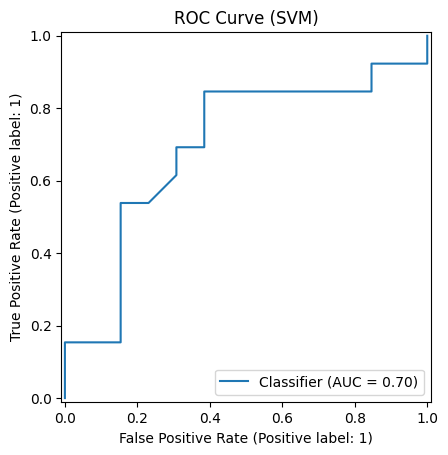


Saved model to: /content/svm_spiral_model.joblib


In [ ]:
# Colab: train/test split (0.8/0.2) + SVM on spiral_features.csv

!pip -q install scikit-learn pandas numpy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

CSV_PATH = "/content/spiral_features_new.csv"   # change if saved elsewhere

# 1) Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape, "columns")

# 2) Prepare X, y
#   - keep only numeric columns for X
#   - y is from 'label' (expects 'healthy' / 'parkinson')
non_feature_cols = {"path", "label"}
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()
y = df["label"].astype(str)

# Sanity check
print("Features:", len(feature_cols))
print("Classes:", y.value_counts().to_dict())

# 3) Train/test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4) Pipeline: Impute (median) -> Standardize -> SVM (RBF)
clf = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])

# 5) Fit
clf.fit(X_train, y_train)

# 6) Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix [rows=true, cols=pred]:")
print(confusion_matrix(y_test, y_pred))

# Optional: ROC-AUC (binary) — will work if exactly 2 classes
if y.nunique() == 2:
    # Map labels to {0,1} in consistent order
    classes = sorted(y.unique())
    y_test_bin = (y_test == classes[1]).astype(int).values
    proba = clf.predict_proba(X_test)[:, list(clf.classes_).index(classes[1])]
    auc = roc_auc_score(y_test_bin, proba)
    print(f"\nROC-AUC: {auc:.4f}")
    RocCurveDisplay.from_predictions(y_test_bin, proba)
    plt.title("ROC Curve (SVM)")
    plt.show()

# (Optional) Save the fitted model for later use
import joblib, os
MODEL_PATH = "/content/svm_spiral_model.joblib"
joblib.dump(clf, MODEL_PATH)
print(f"\nSaved model to: {MODEL_PATH}")


Loaded: (129, 89) columns
Features: 87 | Classes: {'parkinson': np.int64(65), 'healthy': np.int64(64)}

Tuning svm_rbf...
  best params: {'clf__C': 10, 'clf__gamma': 0.001}
  best CV roc_auc: 0.6633

Tuning svm_linear...
  best params: {'clf__C': 0.3}
  best CV roc_auc: 0.6309

Tuning logreg...
  best params: {'clf__C': 0.3, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
  best CV roc_auc: 0.6442

Tuning rf...
  best params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
  best CV roc_auc: 0.6755

Selected model: rf with CV roc_auc=0.6755

Test Accuracy: 0.5769

Classification report:
              precision    recall  f1-score   support

     healthy     0.5625    0.6923    0.6207        13
   parkinson     0.6000    0.4615    0.5217        13

    accuracy                         0.5769        26
   macro avg     0.5813    0.5769    0.5712        26
weighted avg     0.5813    0.5769    0.5712        26

Confusion matrix [rows=t

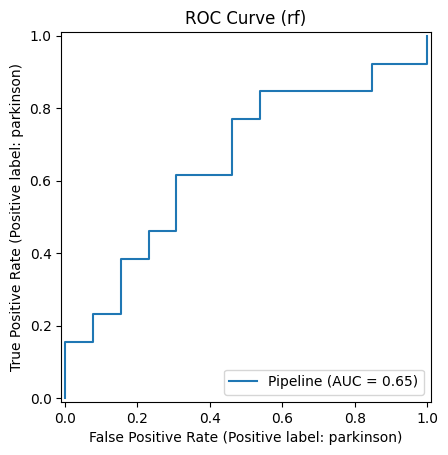


Permutation importance on test set (top 15):


feature  importance_mean  importance_std
45     r2_spec_centroid         0.041026        0.035714
51              r3_mean         0.028205        0.017008
48     r3_coverage_frac         0.020513        0.019188
69      r3_spec_entropy         0.017949        0.019188
14         r1_deriv_rms         0.017949        0.023779
56  r3_monotonic_breaks         0.015385        0.018842
52            r3_median         0.015385        0.030769
26          r2_num_gaps         0.010256        0.017008
10  r1_monotonic_breaks         0.005128        0.013074
73      r12_spacing_min         0.005128        0.019188
44     r2_E_hi_lo_ratio         0.002564        0.009594
57           r3_res_rms         0.002564        0.022057
53               r3_std         0.002564        0.022057
15               r1_zcr         0.002564        0.029682
47        r2_spec_decay         0.002564        0.045436

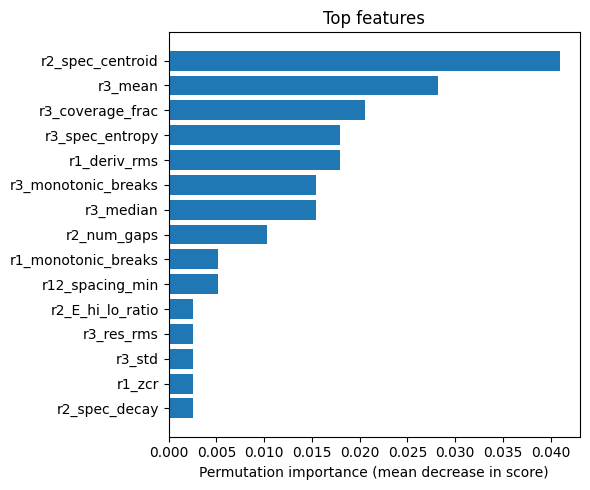


Saved best model to: /content/best_model_rf.joblib


In [ ]:
# Colab: model compare + hyperparameter tuning + evaluation on spiral_features.csv
!pip -q install scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib, warnings, os
warnings.filterwarnings("ignore", category=UserWarning)

CSV_PATH = "/content/spiral_features_new.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20

# 1) Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape, "columns")

# 2) Features / labels
non_feature = {"path","label"}
feature_cols = [c for c in df.columns if c not in non_feature and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()
y = df["label"].astype(str)
print("Features:", len(feature_cols), "| Classes:", dict(y.value_counts()))

# 3) Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

binary = (y.nunique() == 2)
scorer = "roc_auc" if binary else "accuracy"

# 4) Model spaces
pip_base = [("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]

models = {
    "svm_rbf": Pipeline(pip_base + [("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "svm_linear": Pipeline(pip_base + [("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "logreg": Pipeline(pip_base + [("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))]),
    "rf": Pipeline([("impute", SimpleImputer(strategy="median")),
                    ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE))]),
}

param_grids = {
    "svm_rbf": {
        "clf__C":    [0.3, 1, 3, 10],
        "clf__gamma":[0.001, 0.003, 0.01, 0.03],
    },
    "svm_linear": {
        "clf__C": [0.3, 1, 3, 10],
    },
    "logreg": {
        "clf__C": [0.3, 1, 3, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    },
    "rf": {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 8, 12],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
    },
}

# 5) GridSearchCV per model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
best_name, best_est, best_score = None, None, -np.inf

for name, pipe in models.items():
    print(f"\nTuning {name}...")
    gs = GridSearchCV(pipe, param_grids[name], scoring=scorer, cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    print("  best params:", gs.best_params_)
    print(f"  best CV {scorer}: {gs.best_score_:.4f}")
    if gs.best_score_ > best_score:
        best_name, best_est, best_score = name, gs.best_estimator_, gs.best_score_

print(f"\nSelected model: {best_name} with CV {scorer}={best_score:.4f}")

# 6) Fit selected on full train (already refit=True)
best_est.fit(X_train, y_train)

# 7) Evaluate on test
y_pred = best_est.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix [rows=true, cols=pred]:")
print(confusion_matrix(y_test, y_pred))

if binary:
    # ensure consistent positive class index
    classes_sorted = sorted(best_est.named_steps["clf"].classes_)
    pos_idx = classes_sorted.index(classes_sorted[-1])
    proba = best_est.predict_proba(X_test)[:, pos_idx]
    auc = roc_auc_score((y_test==classes_sorted[-1]).astype(int), proba)
    print(f"\nROC-AUC: {auc:.4f}")
    RocCurveDisplay.from_estimator(best_est, X_test, y_test)
    plt.title(f"ROC Curve ({best_name})")
    plt.show()

# 8) Permutation importance (top 15)
try:
    print("\nPermutation importance on test set (top 15):")
    r = permutation_importance(best_est, X_test, y_test, n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1)
    importances = pd.DataFrame({
        "feature": feature_cols,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False)
    display(importances.head(15))
    # simple barplot
    top = importances.head(15)[::-1]
    plt.figure(figsize=(6,5))
    plt.barh(top["feature"], top["importance_mean"])
    plt.xlabel("Permutation importance (mean decrease in score)")
    plt.title("Top features")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)

# 9) Save model
MODEL_PATH = f"/content/best_model_{best_name}.joblib"
joblib.dump(best_est, MODEL_PATH)
print(f"\nSaved best model to: {MODEL_PATH}")


In [ ]:
# Colab: stronger baseline with feature selection + XGBoost + SVM, repeated CV, threshold tuning
!pip -q install pandas numpy scikit-learn xgboost matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, precision_recall_curve, RocCurveDisplay)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import joblib, warnings, os, math, random
warnings.filterwarnings("ignore")

CSV = "/content/spiral_features_new.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_REPEATS = 3     # repeated CV; increase for more stability
N_SPLITS  = 5
N_ITERS_RS = 40   # randomized search iterations (speed/quality tradeoff)
TOP_FEATURES = 60 # SelectKBest(MI) count; try 40–80

# ---------- Load ----------
df = pd.read_csv(CSV)
y = df["label"].astype(str)
X = df[[c for c in df.columns if c not in {"path","label"} and pd.api.types.is_numeric_dtype(df[c])]].copy()
print("Data:", X.shape, "| classes:", dict(y.value_counts()))

# ---------- Split (stratified) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ---------- Preprocess + Feature selection ----------
num_cols = list(X.columns)

pre_num = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# mutual information selector (super fast, model-agnostic)
def mi_selector(k=TOP_FEATURES):
    return SelectKBest(score_func=lambda a,b: mutual_info_classif(a,b,random_state=RANDOM_STATE), k=min(k, X_train.shape[1]))

# ---------- Models ----------
svm_rbf = Pipeline([
    ("prep", pre_num),
    ("sel", mi_selector(TOP_FEATURES)),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))
])

xgb = Pipeline([
    ("imp", SimpleImputer(strategy="median")),  # xgb doesn't need scaling
    ("sel", mi_selector(TOP_FEATURES)),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        random_state=RANDOM_STATE,
        # class balance via scale_pos_weight is handled below after we know class ratio
    ))
])

# class weight/ratio
pos_class = sorted(y.unique())[-1]
pos_ratio = (y_train==pos_class).mean()
scale_pos_weight = (1-pos_ratio)/pos_ratio if pos_ratio>0 else 1.0

# ---------- Hyperparam spaces ----------
rs_cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

svm_param = {
    "clf__C":     np.logspace(-1, 1.2, 12),     # 0.1..~16
    "clf__gamma": np.logspace(-3.5, -0.5, 12),  # 3e-4..0.3
}

xgb_param = {
    "clf__n_estimators": np.arange(200, 650, 50),
    "clf__max_depth":    [3,4,5,6,7],
    "clf__learning_rate": np.logspace(-2.5, -0.5, 10),
    "clf__subsample":    np.linspace(0.6, 1.0, 5),
    "clf__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "clf__min_child_weight": [1, 3, 5, 7],
    "clf__reg_lambda":   np.logspace(-2, 2, 8),
}
# set scale_pos_weight
xgb.set_params(clf__scale_pos_weight=scale_pos_weight)

def tune_model(model, param_grid, name):
    print(f"\nTuning {name} (RandomizedSearchCV)...")
    gs = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        n_iter=N_ITERS_RS, scoring="roc_auc",
        cv=rs_cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0, refit=True
    )
    gs.fit(X_train, y_train)
    print(" best params:", gs.best_params_)
    print(f" best CV AUC: {gs.best_score_:.4f}")
    return gs.best_estimator_, gs.best_score_

best_svm, auc_svm = tune_model(svm_rbf, svm_param, "SVM-RBF")
best_xgb, auc_xgb = tune_model(xgb, xgb_param, "XGBoost")

# pick winner by CV AUC
best_model = best_xgb if auc_xgb >= auc_svm else best_svm
best_name  = "XGBoost" if best_model is best_xgb else "SVM-RBF"
print(f"\nSelected: {best_name} (CV AUC={max(auc_xgb,auc_svm):.4f})")

# ---------- Threshold tuning on a validation fold ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
tr_idx, va_idx = next(skf.split(X_train, y_train))
Xt, Xv = X_train.iloc[tr_idx], X_train.iloc[va_idx]
yt, yv = y_train.iloc[tr_idx], y_train.iloc[va_idx]

best_model.fit(Xt, yt)
proba_v = best_model.predict_proba(Xv)[:, list(best_model.classes_).index(pos_class)]
prec, rec, thr = precision_recall_curve((yv==pos_class).astype(int), proba_v)
f1 = (2*prec*rec)/(prec+rec+1e-12)
thr_star = 0.5 if len(thr)==0 else float(thr[np.nanargmax(f1)])
print(f"Tuned decision threshold (max F1): {thr_star:.3f}")

# ---------- Refit on full train & evaluate on test ----------
best_model.fit(X_train, y_train)
proba_te = best_model.predict_proba(X_test)[:, list(best_model.classes_).index(pos_class)]
y_pred = np.where(proba_te >= thr_star, pos_class, [c for c in best_model.classes_ if c!=pos_class][0])

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score((y_test==pos_class).astype(int), proba_te)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test ROC-AUC:  {auc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix [rows=true, cols=pred]:")
print(confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions((y_test==pos_class).astype(int), proba_te)
plt.title(f"ROC Curve ({best_name})")
plt.show()

# ---------- Permutation importance (top 15) ----------
try:
    r = permutation_importance(best_model, X_test, y_test, n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1)
    imp = pd.DataFrame({"feature": X.columns, "importance": r.importances_mean}).sort_values("importance", ascending=False)
    print("\nTop 15 features:")
    display(imp.head(15))
    plt.figure(figsize=(6,5))
    top = imp.head(15)[::-1]
    plt.barh(top["feature"], top["importance"])
    plt.title("Permutation importance (test)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)

# ---------- Save model ----------
MODEL_PATH = f"/content/best_tabular_model_{best_name.replace(' ','_').lower()}.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"\nSaved model to: {MODEL_PATH}")


Data: (129, 87) | classes: {'parkinson': np.int64(65), 'healthy': np.int64(64)}

Tuning SVM-RBF (RandomizedSearchCV)...
 best params: {'clf__gamma': np.float64(0.003898603702549072), 'clf__C': np.float64(10.0)}
 best CV AUC: 0.6242

Tuning XGBoost (RandomizedSearchCV)...


ValueError: 
All the 600 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1641, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['healthy' 'parkinson']


Data: (129, 87) | classes: {'parkinson': np.int64(65), 'healthy': np.int64(64)}

Tuning SVM-RBF (RandomizedSearchCV)...
 best params: {'clf__gamma': np.float64(0.003898603702549072), 'clf__C': np.float64(10.0)}
 best CV AUC: 0.6242

Tuning XGBoost (RandomizedSearchCV)...
 best params: {'clf__subsample': np.float64(0.7), 'clf__reg_lambda': np.float64(0.0372759372031494), 'clf__n_estimators': np.int64(400), 'clf__min_child_weight': 1, 'clf__max_depth': 6, 'clf__learning_rate': np.float64(0.11364636663857243), 'clf__colsample_bytree': np.float64(0.6)}
 best CV AUC: 0.7088

Selected: XGBoost (CV AUC=0.7088)
Tuned decision threshold (max F1): 0.032

Test Accuracy: 0.4231
Test ROC-AUC:  0.5207

Classification report:
              precision    recall  f1-score   support

     healthy     0.2500    0.0769    0.1176        13
   parkinson     0.4545    0.7692    0.5714        13

    accuracy                         0.4231        26
   macro avg     0.3523    0.4231    0.3445        26
weighte

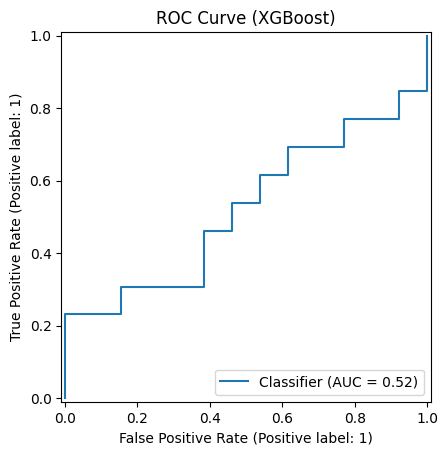


Top 15 features:


feature  importance
51           r3_mean    0.035897
24     r1_spec_decay    0.025641
35        r2_res_mad    0.020513
49       r3_num_gaps    0.020513
38            r2_zcr    0.017949
21  r1_E_hi_lo_ratio    0.015385
19      r1_E_mid_5_8    0.015385
50    r3_max_gap_deg    0.015385
16       r1_dom_harm    0.012821
52         r3_median    0.010256
71  r12_spacing_mean    0.010256
15            r1_zcr    0.010256
55      r3_slope_deg    0.007692
25  r2_coverage_frac    0.007692
45  r2_spec_centroid    0.005128

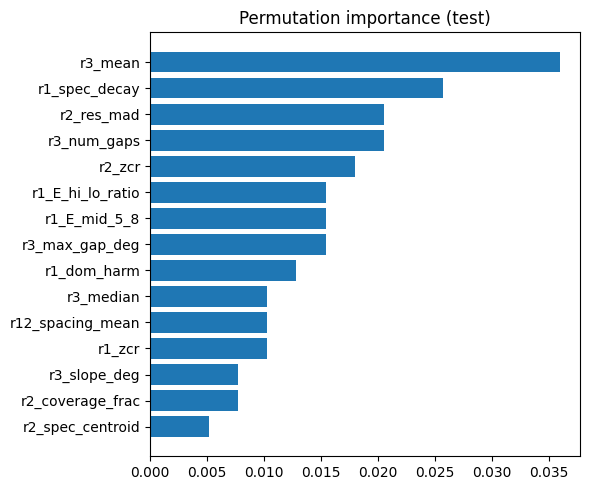


Saved model (with label encoder & threshold) to: /content/best_tabular_model_xgboost.joblib


In [ ]:
# Colab: label-encoded y + MI feature select (picklable) + SVM-RBF vs XGBoost
!pip -q install pandas numpy scikit-learn xgboost matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt, functools, joblib, warnings
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, precision_recall_curve, RocCurveDisplay)
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

CSV = "/content/spiral_features_new.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_REPEATS = 3
N_SPLITS  = 5
N_ITERS_RS = 40
TOP_FEATURES = 60

# ---------- Load ----------
df = pd.read_csv(CSV)
y_str = df["label"].astype(str)
X = df[[c for c in df.columns if c not in {"path","label"} and pd.api.types.is_numeric_dtype(df[c])]].copy()
print("Data:", X.shape, "| classes:", dict(y_str.value_counts()))

# ---------- Label encode y ----------
le = LabelEncoder()
y = le.fit_transform(y_str)           # 0/1
cls_names = list(le.classes_)
pos_label = 1                         # by convention

# ---------- Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ---------- Preprocess + (picklable) MI selector ----------
pre_num = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# IMPORTANT: picklable score_func using functools.partial (NO lambda/locals)
MI_FUNC = functools.partial(mutual_info_classif, random_state=RANDOM_STATE)

def mi_selector(k=TOP_FEATURES):
    return SelectKBest(score_func=MI_FUNC, k=min(k, X_train.shape[1]))

# ---------- Models ----------
svm_rbf = Pipeline([
    ("prep", pre_num),
    ("sel", mi_selector(TOP_FEATURES)),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))
])

xgb = Pipeline([
    ("imp", SimpleImputer(strategy="median")),  # xgb doesn't need scaling
    ("sel", mi_selector(TOP_FEATURES)),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        random_state=RANDOM_STATE,
    ))
])

# class ratio for XGB scale_pos_weight
pos_ratio = (y_train == pos_label).mean()
scale_pos_weight = float((1 - pos_ratio) / pos_ratio) if pos_ratio > 0 else 1.0
xgb.set_params(clf__scale_pos_weight=scale_pos_weight)

# ---------- Hyperparam spaces ----------
rs_cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

svm_param = {
    "clf__C":     np.logspace(-1, 1.2, 12),     # 0.1..~16
    "clf__gamma": np.logspace(-3.5, -0.5, 12),  # 3e-4..0.3
}

xgb_param = {
    "clf__n_estimators": np.arange(200, 650, 50),
    "clf__max_depth":    [3,4,5,6,7],
    "clf__learning_rate": np.logspace(-2.5, -0.5, 10),
    "clf__subsample":    np.linspace(0.6, 1.0, 5),
    "clf__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "clf__min_child_weight": [1, 3, 5, 7],
    "clf__reg_lambda":   np.logspace(-2, 2, 8),
}

def tune_model(model, param_grid, name):
    print(f"\nTuning {name} (RandomizedSearchCV)...")
    gs = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        n_iter=N_ITERS_RS, scoring="roc_auc",
        cv=rs_cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0, refit=True
    )
    gs.fit(X_train, y_train)  # y is numeric
    print(" best params:", gs.best_params_)
    print(f" best CV AUC: {gs.best_score_:.4f}")
    return gs.best_estimator_, gs.best_score_

best_svm, auc_svm = tune_model(svm_rbf, svm_param, "SVM-RBF")
best_xgb, auc_xgb = tune_model(xgb, xgb_param, "XGBoost")

# pick winner by CV AUC
best_model = best_xgb if auc_xgb >= auc_svm else best_svm
best_name  = "XGBoost" if best_model is best_xgb else "SVM-RBF"
print(f"\nSelected: {best_name} (CV AUC={max(auc_xgb,auc_svm):.4f})")

# ---------- Threshold tuning on a validation fold ----------
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
tr_idx, va_idx = next(skf.split(X_train, y_train))
Xt, Xv = X_train.iloc[tr_idx], X_train.iloc[va_idx]
yt, yv = y_train[tr_idx], y_train[va_idx]

best_model.fit(Xt, yt)
proba_v = best_model.predict_proba(Xv)[:, pos_label]
from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve((yv==pos_label).astype(int), proba_v)
f1 = (2*prec*rec)/(prec+rec+1e-12)
thr_star = 0.5 if len(thr)==0 else float(thr[np.nanargmax(f1)])
print(f"Tuned decision threshold (max F1): {thr_star:.3f}")

# ---------- Refit on full train & evaluate on test ----------
best_model.fit(X_train, y_train)
proba_te = best_model.predict_proba(X_test)[:, pos_label]
y_pred_num = (proba_te >= thr_star).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
acc = accuracy_score(y_test, y_pred_num)
auc = roc_auc_score((y_test==pos_label).astype(int), proba_te)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test ROC-AUC:  {auc:.4f}\n")

# pretty report with original string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred_num)
print("Classification report:")
print(classification_report(y_test_str, y_pred_str, digits=4))
print("Confusion matrix [rows=true, cols=pred]:")
print(confusion_matrix(y_test_str, y_pred_str))

RocCurveDisplay.from_predictions((y_test==pos_label).astype(int), proba_te)
plt.title(f"ROC Curve ({best_name})")
plt.show()

# ---------- Permutation importance (top 15) ----------
try:
    r = permutation_importance(best_model, X_test, y_test, n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1)
    imp = pd.DataFrame({"feature": X.columns, "importance": r.importances_mean}).sort_values("importance", ascending=False)
    print("\nTop 15 features:")
    display(imp.head(15))
    plt.figure(figsize=(6,5))
    top = imp.head(15)[::-1]
    plt.barh(top["feature"], top["importance"])
    plt.title("Permutation importance (test)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)

# ---------- Save model (now picklable) ----------
MODEL_PATH = f"/content/best_tabular_model_{best_name.replace(' ','_').lower()}.joblib"
joblib.dump({"model": best_model, "label_encoder": le, "threshold": thr_star}, MODEL_PATH)
print(f"\nSaved model (with label encoder & threshold) to: {MODEL_PATH}")


Loaded: (129, 89) cols
Class counts: {'parkinson': 65, 'healthy': 64}
Quality pass: 33 / 129 rows
Quality pass: 33 / 129 rows

=== A) Baseline SVM on ALL rows ===

[SVM-All]  best params: {'svm__C': 10, 'svm__gamma': 0.001}  |  CV AUC: 0.663
[SVM-All]  Test Accuracy: 0.5769
[SVM-All]  Test ROC-AUC : 0.5858

Classification report:
              precision    recall  f1-score   support

     healthy     0.5556    0.7692    0.6452        13
   parkinson     0.6250    0.3846    0.4762        13

    accuracy                         0.5769        26
   macro avg     0.5903    0.5769    0.5607        26
weighted avg     0.5903    0.5769    0.5607        26

Confusion matrix [rows=true, cols=pred]:
[[10  3]
 [ 8  5]]


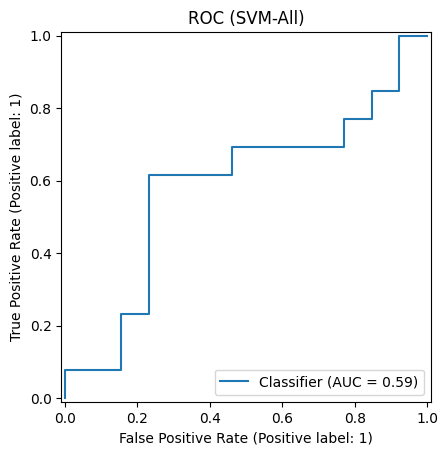


=== B) SVM after QUALITY GATE ===

[SVM-Quality]  best params: {'svm__C': 3, 'svm__gamma': 0.01}  |  CV AUC: 0.822
[SVM-Quality]  Test Accuracy: 0.8571
[SVM-Quality]  Test ROC-AUC : 0.8333

Classification report:
              precision    recall  f1-score   support

     healthy     0.8000    1.0000    0.8889         4
   parkinson     1.0000    0.6667    0.8000         3

    accuracy                         0.8571         7
   macro avg     0.9000    0.8333    0.8444         7
weighted avg     0.8857    0.8571    0.8508         7

Confusion matrix [rows=true, cols=pred]:
[[4 0]
 [1 2]]


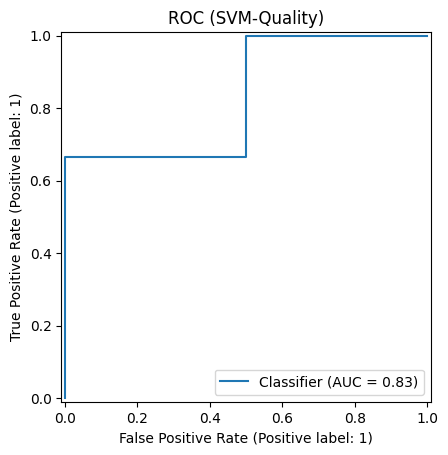


Summary:
 All rows    -> Acc 0.577 | AUC 0.586
 Quality set -> Acc 0.857 | AUC 0.833


In [ ]:
# Colab: recover strong baseline (SVM-RBF) + quality gating
!pip -q install scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

CSV_PATH   = "/content/spiral_features_new.csv"
RANDOM_SEED = 42
TEST_SIZE   = 0.20

# ---------- Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape, "cols")

# Use all numeric columns as features; 'label' as y
X_all = df[[c for c in df.columns if c not in {"path","label"} and pd.api.types.is_numeric_dtype(df[c])]].copy()
y_all = df["label"].astype(str)

print("Class counts:", y_all.value_counts().to_dict())

# ---------- Quality gate (drop obvious failures/noisy cases)
# You can loosen/tighten these thresholds; they’re conservative.
# --- Quality mask applied row-by-row ---
def quality_mask_row(row):
    # coverage and gap thresholds
    conds = []
    for k in (1, 2, 3):
        conds.append(row.get(f"r{k}_coverage_frac", 1.0) >= 0.55)
        conds.append(row.get(f"r{k}_max_gap_deg", 0.0) <= 60.0)
    # crossings thresholds
    for (a, b) in ((1, 2), (2, 3)):
        conds.append(row.get(f"r{a}{b}_crossing_frac", 0.0) <= 0.35)
    return all(conds)

mask = df.apply(quality_mask_row, axis=1)
print(f"Quality pass: {mask.sum()} / {len(mask)} rows")



print(f"Quality pass: {mask.sum()} / {len(mask)} rows")

# ---------- 80/20 stratified split (fixed seed) — same protocol as your 86%
def run_svm(X, y, tag):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
    )
    pipe = Pipeline([
        ("imp",   SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("svm",   SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_SEED)),
    ])
    # small, safe grid (keeps behavior close to your earlier run)
    grid = {
        "svm__C":     [0.3, 1, 3, 10],
        "svm__gamma": [0.001, 0.003, 0.01, 0.03]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    gs = GridSearchCV(pipe, grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_tr, y_tr)

    mdl = gs.best_estimator_
    y_pred = mdl.predict(X_te)
    acc = accuracy_score(y_te, y_pred)

    # ROC-AUC (binary)
    classes = sorted(mdl.classes_)
    pos = classes[-1]
    proba = mdl.predict_proba(X_te)[:, list(mdl.classes_).index(pos)]
    auc = roc_auc_score((y_te==pos).astype(int), proba)

    print(f"\n[{tag}]  best params: {gs.best_params_}  |  CV AUC: {gs.best_score_:.3f}")
    print(f"[{tag}]  Test Accuracy: {acc:.4f}")
    print(f"[{tag}]  Test ROC-AUC : {auc:.4f}\n")
    print("Classification report:")
    print(classification_report(y_te, y_pred, digits=4))
    print("Confusion matrix [rows=true, cols=pred]:")
    print(confusion_matrix(y_te, y_pred))

    RocCurveDisplay.from_predictions((y_te==pos).astype(int), proba)
    plt.title(f"ROC ({tag})")
    plt.show()
    return acc, auc

print("\n=== A) Baseline SVM on ALL rows ===")
acc_all, auc_all = run_svm(X_all, y_all, "SVM-All")

print("\n=== B) SVM after QUALITY GATE ===")
X_q = X_all.loc[mask].reset_index(drop=True)
y_q = y_all.loc[mask].reset_index(drop=True)
acc_q, auc_q = run_svm(X_q, y_q, "SVM-Quality")

print("\nSummary:")
print(f" All rows    -> Acc {acc_all:.3f} | AUC {auc_all:.3f}")
print(f" Quality set -> Acc {acc_q:.3f} | AUC {auc_q:.3f}")



✅ Saved features CSV: /content/spiral_features_new_reduced2.csv
Rows: 87  |  Columns: 89

▶ Plot: V07HE03.png  [healthy]


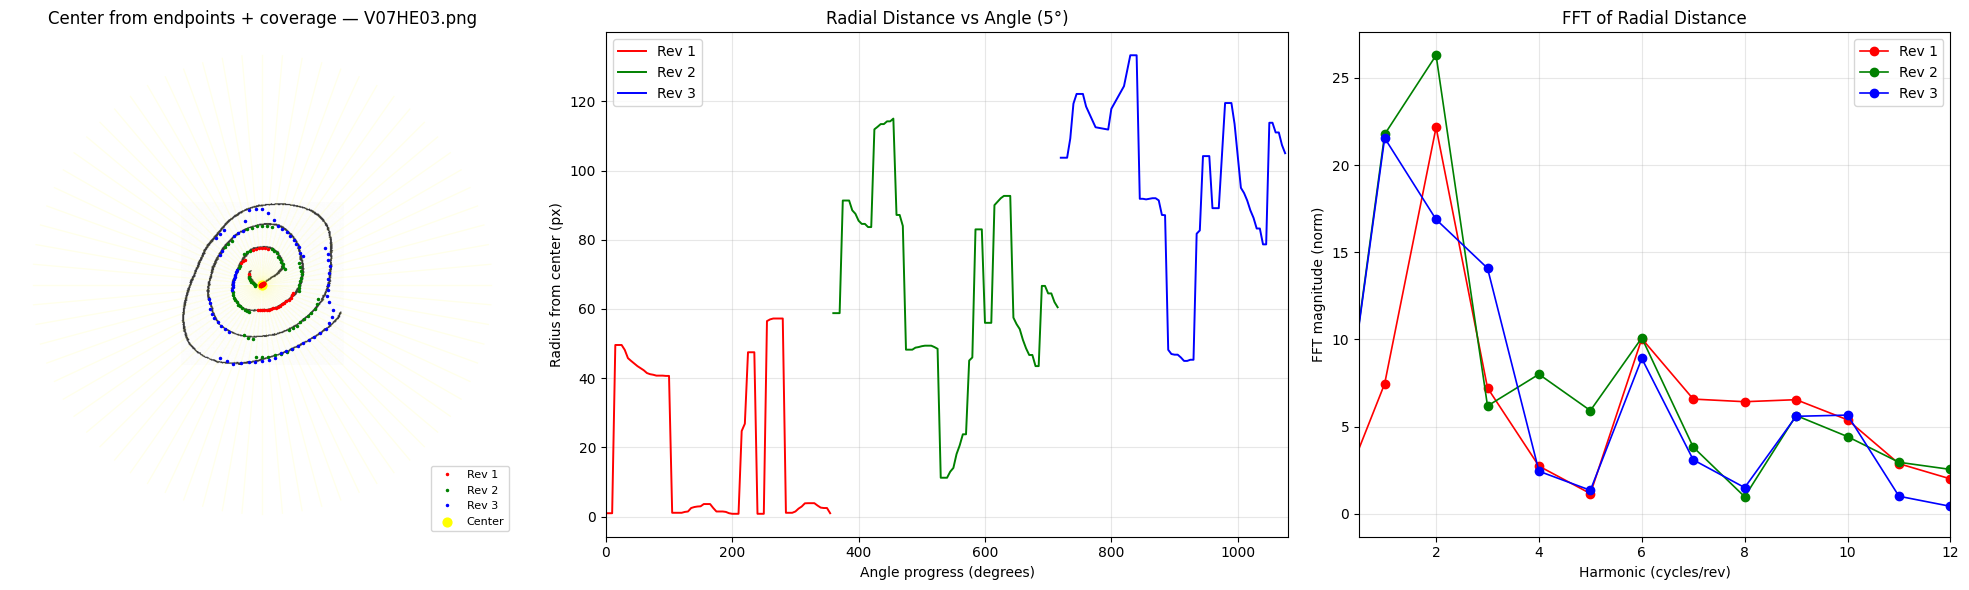


▶ Plot: V01HE03.png  [healthy]


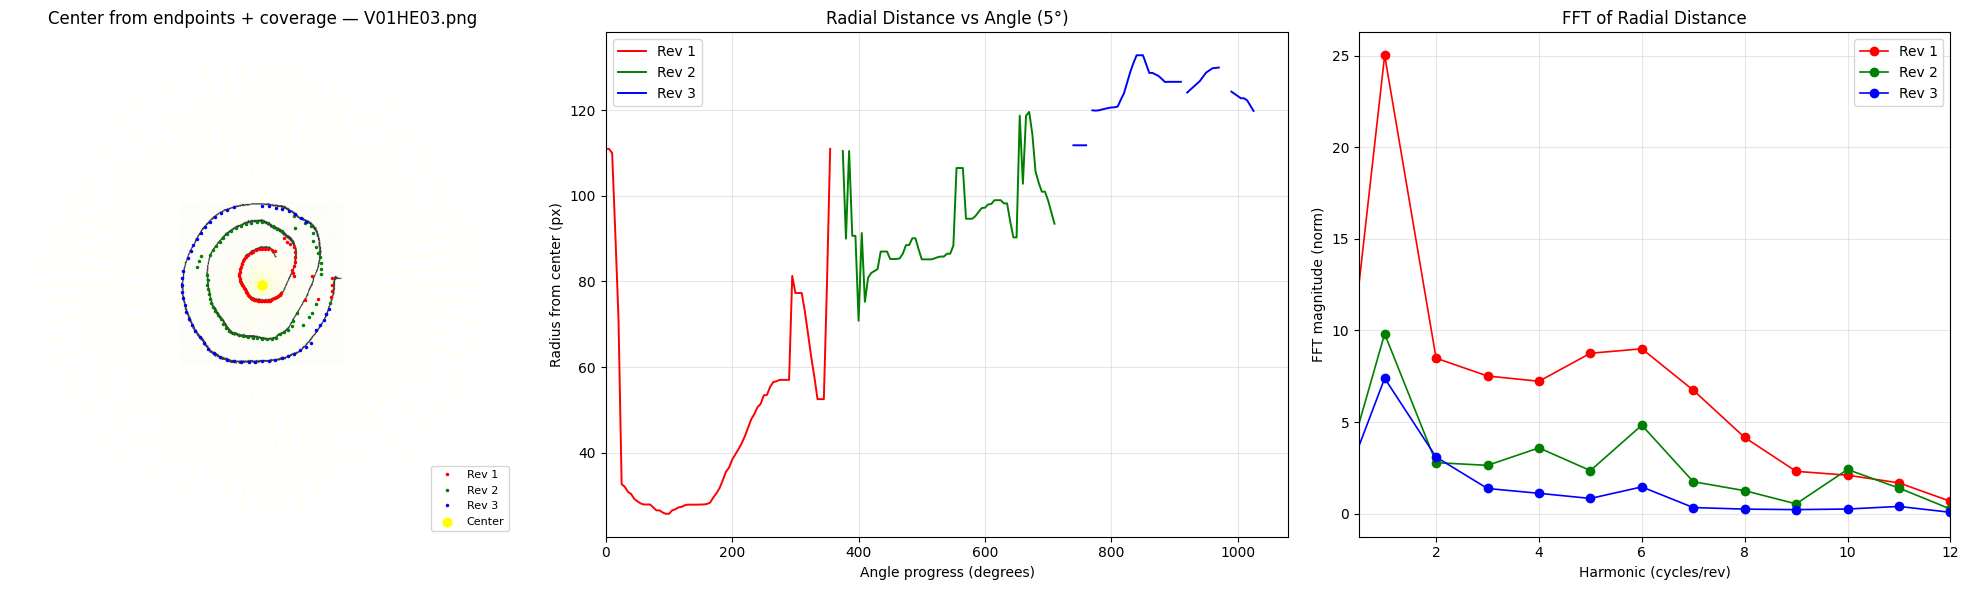


▶ Plot: resized_spiral_newbatch_5_256.png  [parkinson]


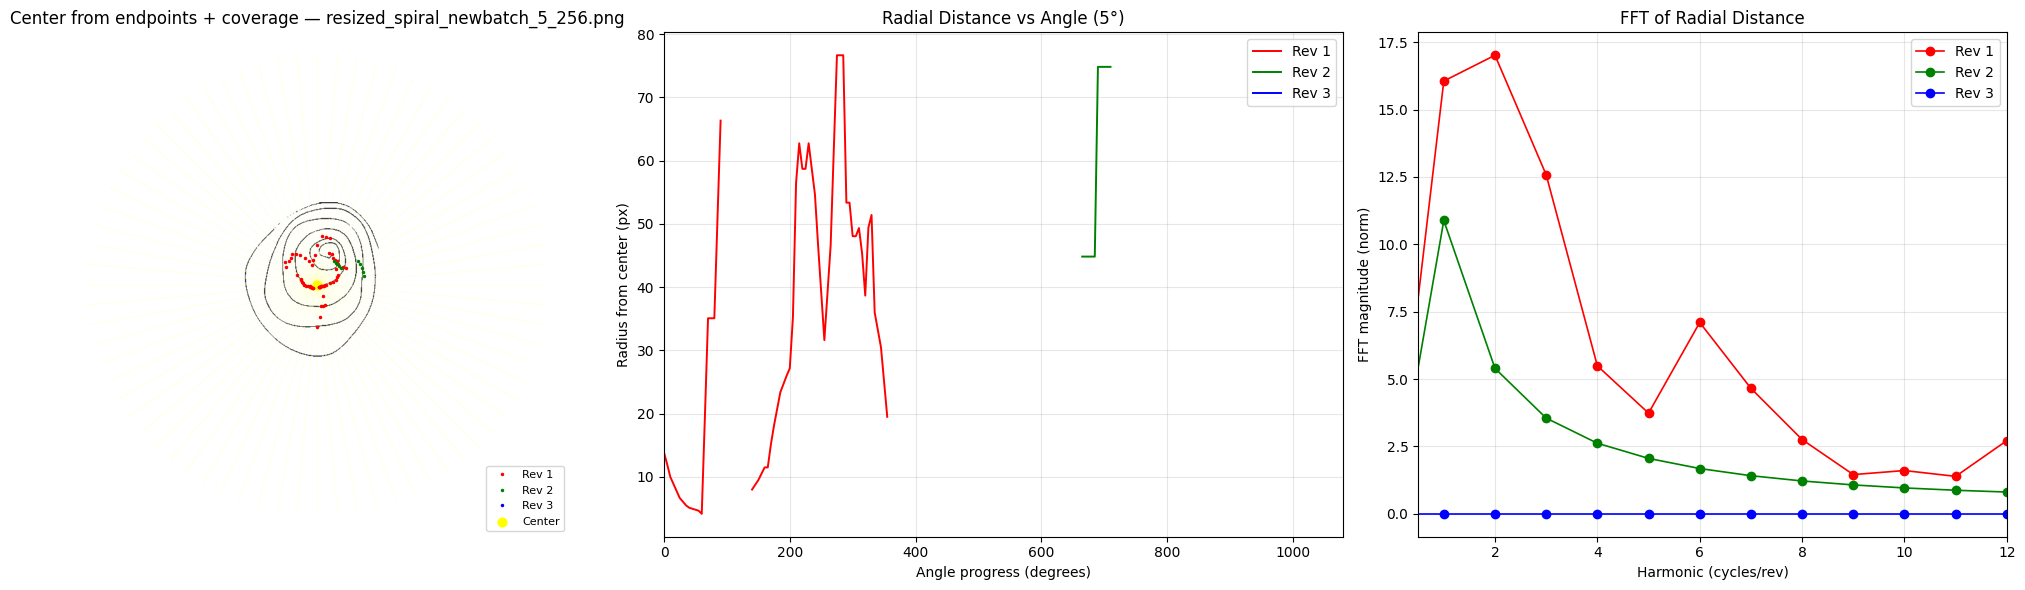


▶ Plot: V07PE03.png  [parkinson]


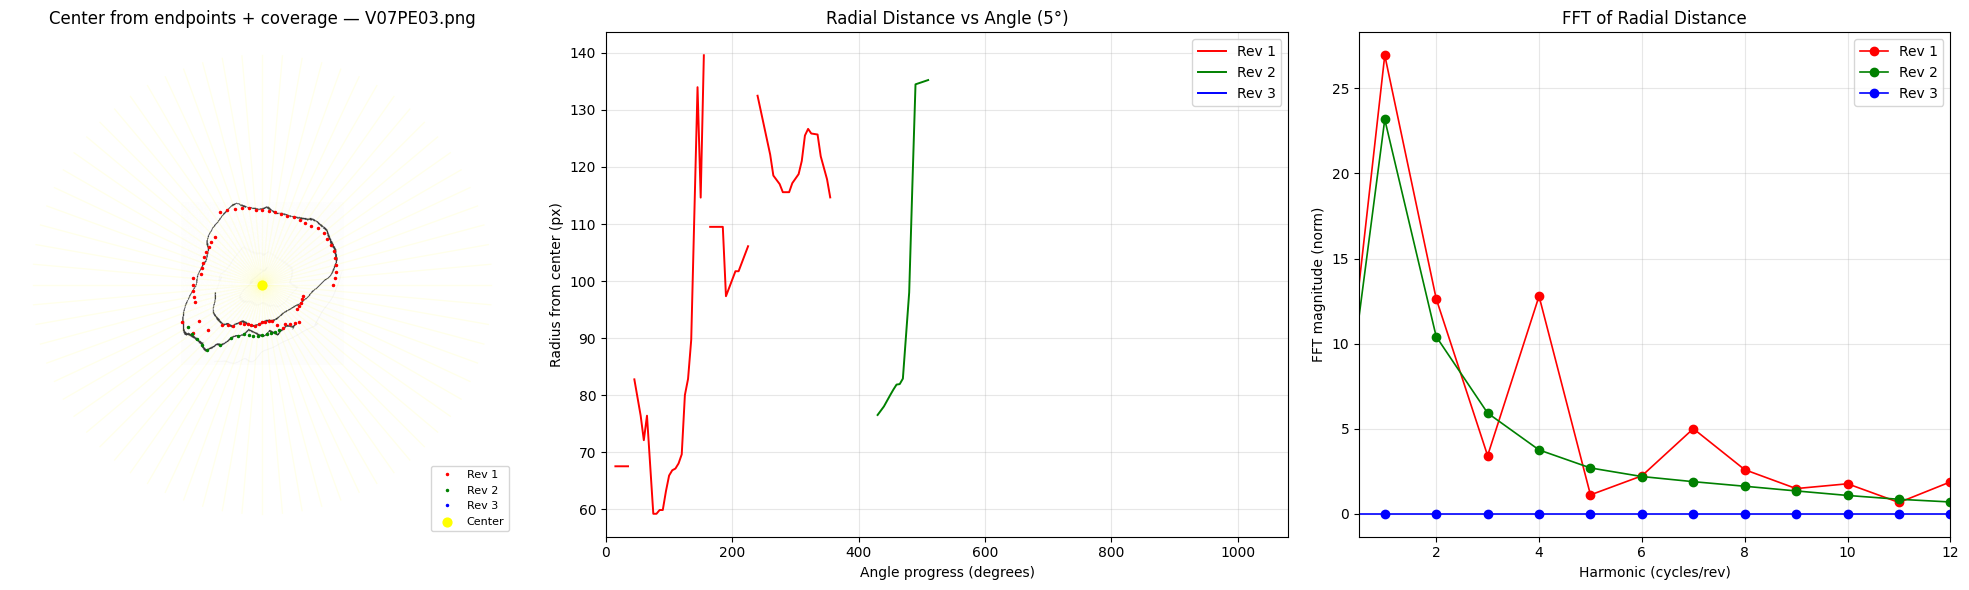

In [ ]:
# ===========================================
# Colab one-cell: Spiral features (healthy vs parkinson)
# - Robust center from endpoints + angular coverage
# - Direct 3-rev sampling per 5° ray (no peel)
# - Plot a few examples (for verification)
# - Extract MANY features from rings and FFT
# - Save one CSV for ALL images in both folders
# ===========================================

# --- deps ---
!pip -q install opencv-python scikit-image numpy matplotlib pandas

import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.morphology import skeletonize
from skimage.util import img_as_bool

# -------- CONFIG: paths & knobs --------
BASE_TRAIN = "/content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training"
TRAIN_HEALTHY   = os.path.join(BASE_TRAIN, "healthy")
TRAIN_PARKINSON = os.path.join(BASE_TRAIN, "parkinson")

REVS = 3                    # how many revolutions to extract per ray
ANGLE_STEP_DEG = 5.0        # 5° sampling
R_STEP_PX = 0.5             # radial sampling step along a ray
MIN_RUN_LEN = 3             # min consecutive ink pixels to accept a run
MIN_BG_GAP = 2              # min background pixels separating runs
SMOOTH_WIN = 5              # median smoothing window (odd; 0/1 disables)
FILL_GAP_DEG = 10.0         # fill NaN runs up to this many degrees

MAX_HARMONIC_TO_SHOW = 12
REMOVE_DC = True

N_VERIFY_PLOTS_PER_CLASS = 2   # how many images to PLOT from each folder (only for visual check)
RANDOM_SEED = 42
SAVE_CSV_PATH = "/content/spiral_features_new_reduced2.csv"
# --------------------------------------

# ---------- binarize/polarity ----------
ADAPT_BLOCK = 41
ADAPT_C = 10
MORPH_CLOSE_K = 3
KEEP_LARGEST_IF_FRAC = 0.5
POLARITY_MIN_WHITE_FRAC = 0.55

def force_white_background(img_bin, min_white_frac=POLARITY_MIN_WHITE_FRAC):
    if float(np.mean(img_bin == 255)) < min_white_frac:
        img_bin = 255 - img_bin
    return img_bin

def binarize_conservative(img_gray):
    _, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adapt = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, ADAPT_BLOCK, ADAPT_C)
    bin_or = cv2.bitwise_or(otsu, adapt)
    bin_or = force_white_background(bin_or)
    if MORPH_CLOSE_K >= 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_CLOSE_K, MORPH_CLOSE_K))
        inv = 255 - bin_or
        inv = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, k, iterations=1)
        bin_or = 255 - inv
    return force_white_background(bin_or)

def keep_largest_component_guarded(img_bin, keep_fraction=KEEP_LARGEST_IF_FRAC):
    ink = (img_bin == 0).astype(np.uint8)
    total = int(ink.sum())
    if total == 0: return img_bin
    num, labels, stats, _ = cv2.connectedComponentsWithStats(ink, 8)
    if num <= 2: return img_bin
    areas = stats[1:, cv2.CC_STAT_AREA]
    li = 1 + int(np.argmax(areas))
    if int(areas.max()) >= keep_fraction * total:
        keep = (labels == li)
        out = np.full_like(img_bin, 255, np.uint8); out[keep] = 0
        return out
    return img_bin

# ---------- skeleton + endpoints ----------
def get_skeleton_endpoints(img_bin):
    ink = (img_bin == 0).astype(np.uint8)
    skel = skeletonize(img_as_bool(ink))
    ys, xs = np.where(skel)

    H, W = img_bin.shape
    endpoints = []
    for y, x in zip(ys, xs):
        y0, y1 = max(0, y-1), min(H, y+2)
        x0, x1 = max(0, x-1), min(W, x+2)
        nb = np.count_nonzero(skel[y0:y1, x0:x1]) - 1
        if nb == 1:
            endpoints.append((x, y))
    if len(endpoints) >= 2:
        ep = np.array(endpoints)
        best = (0, (ep[0], ep[1]))
        for i in range(len(ep)):
            d = np.sum((ep[i] - ep)**2, axis=1)
            j = int(np.argmax(d))
            if d[j] > best[0]:
                best = (d[j], (tuple(ep[i]), tuple(ep[j])))
        e1, e2 = best[1]
    elif len(endpoints) == 1:
        e1, e2 = endpoints[0], endpoints[0]
    else:
        e1 = e2 = (img_bin.shape[1]//2, img_bin.shape[0]//2)
    return skel, np.array(list(zip(xs,ys))), e1, e2

# ---------- center from endpoints + angular coverage ----------
def circular_variance(angles):
    v = np.exp(1j * angles)
    return 1.0 - np.abs(np.mean(v))  # 0 = aligned, 1 = uniform coverage

def score_center(center, pts, sample_size=400):
    cx, cy = center
    if pts.shape[0] == 0:
        return -1e9
    if pts.shape[0] > sample_size:
        idx = np.random.RandomState(0).choice(pts.shape[0], sample_size, replace=False)
        P = pts[idx]
    else:
        P = pts
    dx = P[:,0] - cx
    dy = P[:,1] - cy
    m = (dx*dx + dy*dy) > 4.0
    if not np.any(m):
        return -1e9
    ang = np.arctan2(dy[m], dx[m])  # -π..π
    ang = (ang + 2*np.pi) % (2*np.pi)
    return circular_variance(ang)

def refine_center_by_angular_coverage(img_bin, seeds, pts, coarse=5, fine=2):
    H, W = img_bin.shape
    best = (-1e9, seeds[0])
    for (sx, sy) in seeds:
        sx = int(np.clip(sx, 0, W-1)); sy = int(np.clip(sy, 0, H-1))
        cx, cy = sx, sy
        for step in [coarse, fine]:
            improved = True
            while improved:
                improved = False
                base = score_center((cx, cy), pts)
                for dx in (-step, 0, step):
                    for dy in (-step, 0, step):
                        nx, ny = int(np.clip(cx+dx, 0, W-1)), int(np.clip(cy+dy, 0, H-1))
                        sc = score_center((nx, ny), pts)
                        if sc > base:
                            cx, cy, base = nx, ny, sc
                            improved = True
                if base > best[0]:
                    best = (base, (cx, cy))
    return best[1]

def estimate_center_from_endpoints(img_bin):
    H, W = img_bin.shape
    skel, pts, e1, e2 = get_skeleton_endpoints(img_bin)
    mid = ((e1[0]+e2[0])//2, (e1[1]+e2[1])//2)
    white = (img_bin == 255).astype(np.uint8) * 255
    dist = cv2.distanceTransform(white, cv2.DIST_L2, 5)
    y, x = np.unravel_index(np.argmax(dist), dist.shape)
    dt_peak = (int(x), int(y))
    ys, xs = np.where((img_bin == 0))
    centroid = (int(np.mean(xs)) if xs.size else W//2, int(np.mean(ys)) if ys.size else H//2)
    seeds = [mid, dt_peak, centroid]
    cx, cy = refine_center_by_angular_coverage(img_bin, seeds, pts)
    return int(cx), int(cy)

# ---------- ray sampling (first K ink runs) ----------
def ray_coords(cx, cy, theta_rad, r_max, r_step=R_STEP_PX, H=None, W=None):
    r = np.arange(0.0, r_max, r_step, dtype=np.float32)
    x = cx + r*np.cos(theta_rad)
    y = cy + r*np.sin(theta_rad)
    xi = np.rint(x).astype(int)
    yi = np.rint(y).astype(int)
    if H is not None and W is not None:
        m = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
        xi, yi, r = xi[m], yi[m], r[m]
    if xi.size > 1:
        dup = (np.diff(xi)==0) & (np.diff(yi)==0)
        keep = np.ones_like(xi, bool); keep[1:] &= ~dup
        xi, yi, r = xi[keep], yi[keep], r[keep]
    return xi, yi, r

def first_k_runs_along_ray(img_bin, xi, yi, r, k=3, min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP):
    ink = (img_bin[yi, xi] == 0).astype(np.int8)
    runs = []
    i = 0
    n = len(ink)
    while i < n and len(runs) < k:
        while i < n and ink[i] == 0: i += 1
        s = i
        while i < n and ink[i] == 1: i += 1
        e = i
        if e - s >= min_run:
            runs.append(float(np.mean(r[s:e])))
        gap = 0
        while i < n and ink[i] == 0 and gap < min_gap:
            i += 1; gap += 1
    if len(runs) < k:
        runs += [np.nan]*(k - len(runs))
    return runs[:k]

def sample_rings(img_bin, cx, cy, angle_step=ANGLE_STEP_DEG, k_revs=REVS):
    H, W = img_bin.shape
    r_max = float(np.hypot(W, H))
    angles_deg = np.arange(0.0, 360.0, angle_step, dtype=float)
    rings = np.full((k_revs, len(angles_deg)), np.nan, float)
    for j, ang in enumerate(angles_deg):
        th = np.deg2rad(ang)
        xi, yi, r = ray_coords(cx, cy, th, r_max, R_STEP_PX, H, W)
        if len(xi) == 0: continue
        runs = first_k_runs_along_ray(img_bin, xi, yi, r, k=k_revs,
                                      min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP)
        rings[:, j] = runs
    return angles_deg, rings

# ---------- smoothing / fill ----------
def _median_filter_circ(arr, w):
    if w<=1 or w%2==0: return arr
    n=len(arr); out=arr.copy(); h=w//2
    for i in range(n):
        idx=[(i+d)%n for d in range(-h,h+1)]
        seg=arr[idx]; seg=seg[np.isfinite(seg)]
        if seg.size: out[i]=np.median(seg)
    return out

def _fill_small_gaps(arr, max_gap_bins):
    out=arr.copy(); n=len(arr); i=0
    while i<n:
        if np.isnan(out[i]):
            j=i
            while j<n and np.isnan(out[j]): j+=1
            if i>0 and j<n and (j-i)<=max_gap_bins:
                out[i:j]=np.linspace(out[i-1], out[j], (j-i)+2)[1:-1]
            i=j
        else: i+=1
    return out

def tidy_rings(rings, angle_step=ANGLE_STEP_DEG, smooth_win=SMOOTH_WIN, fill_gap_deg=FILL_GAP_DEG):
    max_gap_bins = int(round(fill_gap_deg/angle_step)) if fill_gap_deg>0 else 0
    out=rings.copy()
    for k in range(out.shape[0]):
        r=out[k]
        if max_gap_bins>0: r=_fill_small_gaps(r, max_gap_bins)
        if smooth_win and smooth_win%2==1 and smooth_win>1: r=_median_filter_circ(r, smooth_win)
        out[k]=r
    return out

# ---------- FFT ----------
def ring_fft(sig):
    x=sig.astype(float)
    if np.any(~np.isfinite(x)):
        n=len(x); idx=np.arange(n); m=np.isfinite(x)
        if m.sum()==0: x=np.zeros_like(x)
        else:
            xi=np.concatenate([idx[m], idx[m]+n]); yi=np.concatenate([x[m],x[m]])
            idx2=idx.copy(); idx2[idx<idx[m].min()]+=n
            x=np.interp(idx2, xi, yi)
    if REMOVE_DC: x=x-np.mean(x)
    R=np.fft.rfft(x); mag=np.abs(R)/len(x); mag[1:-1]*=2.0
    h=np.arange(len(mag)); return h, mag

# ---------- plotting ----------
def plot_all(img_gray, img_bin, cx, cy, angles, rings, fft_h, fft_mag, title):
    colors=['red','green','blue','purple','orange']
    fig=plt.figure(figsize=(20,6))
    gs=fig.add_gridspec(1,3,width_ratios=[1.2,1.5,1.3])
    ax0=fig.add_subplot(gs[0,0]); ax1=fig.add_subplot(gs[0,1]); ax2=fig.add_subplot(gs[0,2])

    ax0.imshow(img_gray,cmap='gray',alpha=0.25)
    ax0.imshow(img_bin,cmap='gray',alpha=0.75)
    H,W=img_bin.shape; edge=int(np.hypot(W,H))
    for ang in angles:
        x2=int(round(cx+edge*np.cos(np.deg2rad(ang))))
        y2=int(round(cy+edge*np.sin(np.deg2rad(ang))))
        ax0.plot([cx,x2],[cy,y2],color='yellow',alpha=0.08,linewidth=1)
    for k in range(min(REVS, rings.shape[0])):
        m=np.isfinite(rings[k]); th=np.deg2rad(angles[m]); rr=rings[k,m]
        xs=cx+rr*np.cos(th); ys=cy+rr*np.sin(th)
        ax0.plot(xs,ys,'.',color=colors[k%len(colors)],markersize=3,label=f"Rev {k+1}")
    ax0.scatter(cx,cy,c='yellow',s=40,label='Center'); ax0.axis('off'); ax0.legend(loc='lower right',fontsize=8)
    ax0.set_title(f"Center from endpoints + coverage — {title}")

    for k in range(min(REVS, rings.shape[0])):
        ax1.plot(angles+360.0*k, rings[k], color=colors[k%len(colors)], linewidth=1.4, label=f"Rev {k+1}")
    ax1.set_xlim(0, 360.0*REVS); ax1.grid(True,alpha=0.3)
    ax1.set_xlabel("Angle progress (degrees)"); ax1.set_ylabel("Radius from center (px)")
    ax1.set_title(f"Radial Distance vs Angle ({ANGLE_STEP_DEG:.0f}°)"); ax1.legend()

    for k in range(min(REVS, rings.shape[0])):
        h, m = fft_h[k], fft_mag[k]; mask = (h<=MAX_HARMONIC_TO_SHOW)
        ax2.plot(h[mask], m[mask], marker='o', linewidth=1.2, label=f"Rev {k+1}", color=colors[k%len(colors)])
    ax2.set_xlabel("Harmonic (cycles/rev)"); ax2.set_ylabel("FFT magnitude (norm)")
    ax2.set_title("FFT of Radial Distance"); ax2.grid(True,alpha=0.3); ax2.legend()
    if REMOVE_DC: ax2.set_xlim(0.5, MAX_HARMONIC_TO_SHOW)
    else:         ax2.set_xlim(0, MAX_HARMONIC_TO_SHOW)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---------- Feature extraction ----------
def _finite(x): return np.isfinite(x)

def _linfit_slope_deg(angles_deg, y):
    m = _finite(y)
    if m.sum() < 6: return np.nan
    x = angles_deg[m]
    yy = y[m]
    x = x - x.mean()
    denom = (x*x).sum()
    if denom == 0: return 0.0
    return float((x*yy).sum()/denom)

def _num_gaps_and_maxgap(ang, y):
    m = _finite(y)
    if m.all(): return 0, 0.0
    mask = ~m.astype(bool)
    gaps = 0; maxgap = 0.0
    n = len(mask)
    i = 0
    step_deg = float(ang[1]-ang[0])
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]: j += 1
            gaps += 1
            maxgap = max(maxgap, (j - i) * step_deg)
            i = j
        else:
            i += 1
    if mask[0] and mask[-1]:
        i0 = 0
        while i0 < n and mask[i0]: i0 += 1
        jn = n-1
        while jn >= 0 and mask[jn]: jn -= 1
        merged = (i0 + (n-1-jn)) * step_deg
        maxgap = max(maxgap, merged)
        gaps = max(0, gaps-1)
    return gaps, float(maxgap)

def _residuals(y):
    m = _finite(y)
    if m.sum()==0: return np.full_like(y, np.nan, dtype=float)
    med = np.nanmedian(y)
    r = y - med
    r[~m] = np.nan
    return r

def _derivative(x):
    y = x.copy()
    m = _finite(y)
    if m.sum() < 3: return np.full_like(y, np.nan, dtype=float)
    # circular forward diff
    d = np.roll(y, -1) - y
    d[~m] = np.nan
    return d

def _zcr(x):
    m = _finite(x)
    x = x[m]
    if len(x) < 3: return np.nan
    s = np.sign(x)
    s[s==0] = 1
    return float(np.mean(s[:-1] != s[1:]))

def _safe_corr(a, b):
    m = _finite(a) & _finite(b)
    if m.sum() < 6: return np.nan
    aa = a[m]; bb = b[m]
    if np.std(aa)==0 or np.std(bb)==0: return np.nan
    return float(np.corrcoef(aa, bb)[0,1])

def _spec_bands(h, mag):
    # ignore DC (0)
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan, np.nan, np.nan
    hh = h[m]; mm = mag[m]
    low = (hh>=2) & (hh<=4)
    mid = (hh>=5) & (hh<=8)
    high= (hh>=9) & (hh<=12)
    e_low  = float((mm[low]**2).sum()) if np.any(low) else 0.0
    e_mid  = float((mm[mid]**2).sum()) if np.any(mid) else 0.0
    e_high = float((mm[high]**2).sum()) if np.any(high) else 0.0
    return e_low, e_mid, e_high

def _spec_centroid(h, mag):
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); mm = mag[m].astype(float)
    s = mm.sum()
    if s==0: return np.nan
    return float((hh*mm).sum()/s)

def _spec_entropy(mag):
    m = _finite(mag)
    mm = mag[m].astype(float)
    if mm.size == 0: return np.nan
    s = mm.sum()
    if s <= 0: return np.nan
    p = mm / s
    p = p[p>0]
    return float(-(p*np.log(p)).sum())

def _spec_decay(h, mag):
    m = (h>=1) & _finite(mag) & (mag>0)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); lg = np.log(mag[m].astype(float))
    X = np.vstack([hh, np.ones_like(hh)]).T
    w = np.linalg.lstsq(X, lg, rcond=None)[0]
    return float(w[0])  # slope (more negative = steeper decay)

def compute_features(angles_deg, rings, fft_h, fft_mag):
    out = {}
    step_deg = float(angles_deg[1] - angles_deg[0]) if len(angles_deg)>1 else ANGLE_STEP_DEG

    for k in range(REVS):
        r = rings[k]
        m = _finite(r)
        coverage = float(np.mean(m)) if r.size else 0.0
        gaps, maxgap = _num_gaps_and_maxgap(angles_deg, r)

        out[f"r{k+1}_coverage_frac"] = coverage
        out[f"r{k+1}_num_gaps"]      = gaps
        out[f"r{k+1}_max_gap_deg"]   = maxgap

        out[f"r{k+1}_mean"]   = float(np.nanmean(r)) if m.any() else np.nan
        out[f"r{k+1}_median"] = float(np.nanmedian(r)) if m.any() else np.nan
        out[f"r{k+1}_std"]    = float(np.nanstd(r)) if m.any() else np.nan
        out[f"r{k+1}_ptp"]    = float(np.nanmax(r)-np.nanmin(r)) if m.any() else np.nan
        out[f"r{k+1}_slope_deg"] = _linfit_slope_deg(angles_deg, r)

        # monotonic breaks (sign changes in derivative of r)
        dr = _derivative(r)
        if np.all(~_finite(dr)):
            out[f"r{k+1}_monotonic_breaks"] = np.nan
        else:
            s = np.sign(dr)
            s[~_finite(s)] = 0
            s[s==0] = 1
            out[f"r{k+1}_monotonic_breaks"] = float(np.sum(s[:-1] != s[1:]))

        # residual-based roughness
        res = _residuals(r)
        out[f"r{k+1}_res_rms"] = float(np.sqrt(np.nanmean(res**2))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_mad"] = float(np.nanmedian(np.abs(res - np.nanmedian(res)))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_ptp"] = float(np.nanmax(res)-np.nanmin(res)) if _finite(res).any() else np.nan
        dres = _derivative(res)
        out[f"r{k+1}_deriv_rms"] = float(np.sqrt(np.nanmean(dres**2))) if _finite(dres).any() else np.nan
        out[f"r{k+1}_zcr"] = _zcr(dres)

        # spectrum
        h = fft_h[k]; mag = fft_mag[k]
        if REMOVE_DC:
            h0 = h[1:]; mag0 = mag[1:]
        else:
            h0 = h.copy(); mag0 = mag.copy()
        if mag0.size:
            dom_idx = int(np.argmax(mag0))
            out[f"r{k+1}_dom_harm"] = int(h0[dom_idx])
            out[f"r{k+1}_dom_amp"]  = float(mag0[dom_idx])
        else:
            out[f"r{k+1}_dom_harm"] = np.nan
            out[f"r{k+1}_dom_amp"]  = np.nan

        e_low, e_mid, e_high = _spec_bands(h, mag)
        out[f"r{k+1}_E_low_2_4"]  = e_low
        out[f"r{k+1}_E_mid_5_8"]  = e_mid
        out[f"r{k+1}_E_high_9_12"] = e_high
        out[f"r{k+1}_E_hi_lo_ratio"] = float(e_high / e_low) if e_low>0 else np.nan
        out[f"r{k+1}_spec_centroid"] = _spec_centroid(h, mag)
        out[f"r{k+1}_spec_entropy"]  = _spec_entropy(mag)
        out[f"r{k+1}_spec_decay"]    = _spec_decay(h, mag)

    # inter-ring spacing & coherence
    for (a,b) in [(0,1),(1,2)]:
        if a < rings.shape[0] and b < rings.shape[0]:
            ra, rb = rings[a], rings[b]
            spacing = rb - ra
            m = _finite(spacing)
            out[f"r{a+1}{b+1}_spacing_mean"] = float(np.nanmean(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_std"]  = float(np.nanstd(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_min"]  = float(np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_ptp"]  = float(np.nanmax(spacing)-np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_cv"]   = (out[f"r{a+1}{b+1}_spacing_std"] / out[f"r{a+1}{b+1}_spacing_mean"]) if m.any() and out[f"r{a+1}{b+1}_spacing_mean"] not in [0, np.nan] else np.nan
            # crossings: inner > outer? (spacing < 0)
            out[f"r{a+1}{b+1}_crossing_frac"] = float(np.mean(spacing[m] < 0.0)) if m.any() else np.nan

            # residual correlation
            res_a = _residuals(ra)
            res_b = _residuals(rb)
            out[f"r{a+1}{b+1}_corr_resid"] = _safe_corr(res_a, res_b)

            # fft magnitude correlation
            out[f"r{a+1}{b+1}_corr_fft"] = _safe_corr(fft_mag[a], fft_mag[b])

    return out

# ---------- run folders, plot some, write CSV ----------
def list_images(folder):
    exts=("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    paths=[]
    for e in exts: paths+=glob.glob(os.path.join(folder,e))
    paths.sort()
    return paths

def process_image(path):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise ValueError(f"Cannot read: {path}")
    img_bin = binarize_conservative(img_gray)
    img_bin = keep_largest_component_guarded(img_bin, KEEP_LARGEST_IF_FRAC)
    img_bin = force_white_background(img_bin)

    cx, cy = estimate_center_from_endpoints(img_bin)
    angles, rings_raw = sample_rings(img_bin, cx, cy, ANGLE_STEP_DEG, REVS)
    rings = tidy_rings(rings_raw, ANGLE_STEP_DEG, SMOOTH_WIN, FILL_GAP_DEG)

    fft_h=[]; fft_mag=[]
    for k in range(REVS):
        h,m = ring_fft(rings[k]); fft_h.append(h); fft_mag.append(m)

    return {
        "img_gray": img_gray, "img_bin": img_bin,
        "center": (cx, cy), "angles": angles,
        "rings": rings, "fft_h": fft_h, "fft_mag": fft_mag
    }

def run_and_export():
    rows = []
    random.seed(RANDOM_SEED)
    to_plot = []

    for folder, label in [(TRAIN_HEALTHY, "healthy"), (TRAIN_PARKINSON, "parkinson")]:
        if not os.path.isdir(folder):
            print(f"Skip (missing): {folder}")
            continue
        paths = list_images(folder)
        if not paths:
            print(f"No images in: {folder}")
            continue

        # choose a few to plot
        sample = random.sample(paths, min(N_VERIFY_PLOTS_PER_CLASS, len(paths)))
        to_plot += [(p, label) for p in sample]

        # process all for CSV
        for p in paths:
            try:
                res = process_image(p)
                feats = compute_features(res["angles"], res["rings"], res["fft_h"], res["fft_mag"])
                feats_row = {
                    "path": p,
                    "label": label,
                    "center_x": res["center"][0],
                    "center_y": res["center"][1],
                }
                feats_row.update(feats)
                rows.append(feats_row)
            except Exception as e:
                print(f"Error on {p}: {e}")

    # save CSV
    df = pd.DataFrame(rows)
    df.to_csv(SAVE_CSV_PATH, index=False)
    print(f"\n✅ Saved features CSV: {SAVE_CSV_PATH}")
    print(f"Rows: {len(df)}  |  Columns: {len(df.columns)}")

    # plot a few examples
    for p, label in to_plot:
        print(f"\n▶ Plot: {os.path.basename(p)}  [{label}]")
        res = process_image(p)
        # prepare FFT arrays for plotting up to MAX_HARMONIC_TO_SHOW
        fft_h, fft_mag = [], []
        for k in range(REVS):
            h, m = res["fft_h"][k], res["fft_mag"][k]
            mask = h <= MAX_HARMONIC_TO_SHOW
            fft_h.append(h[mask]); fft_mag.append(m[mask])
        plot_all(res["img_gray"], res["img_bin"], res["center"][0], res["center"][1],
                 res["angles"], res["rings"], fft_h, fft_mag, os.path.basename(p))

run_and_export()


In [ ]:
ll

total 1524
-rw-r--r-- 1 root 830306 Sep 21 13:40 best_model_rf.joblib
-rw-r--r-- 1 root 328791 Sep 21 14:16 best_tabular_model_xgboost.joblib
drwx------ 5 root   4096 Sep 21 13:33 drive/
drwxr-xr-x 1 root   4096 Sep 16 13:40 sample_data/
-rw-r--r-- 1 root 169867 Sep 21 13:34 spiral_features_new.csv
-rw-r--r-- 1 root 134191 Sep 21 14:29 spiral_features_new_reduced.csv
-rw-r--r-- 1 root  78445 Sep 21 13:37 svm_spiral_model.joblib


Loaded: (87, 89) columns
Features: 87 | Classes: {'parkinson': np.int64(48), 'healthy': np.int64(39)}

Tuning svm_rbf...
  best params: {'clf__C': 0.3, 'clf__gamma': 0.03}
  best CV roc_auc: 0.8026

Tuning svm_linear...
  best params: {'clf__C': 0.3}
  best CV roc_auc: 0.7179

Tuning logreg...
  best params: {'clf__C': 0.3, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
  best CV roc_auc: 0.7417

Tuning rf...
  best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
  best CV roc_auc: 0.7780

Selected model: svm_rbf with CV roc_auc=0.8026

Test Accuracy: 0.5000

Classification report:
              precision    recall  f1-score   support

     healthy     0.3333    0.1250    0.1818         8
   parkinson     0.5333    0.8000    0.6400        10

    accuracy                         0.5000        18
   macro avg     0.4333    0.4625    0.4109        18
weighted avg     0.4444    0.5000    0.4364        18

Confusion matrix 

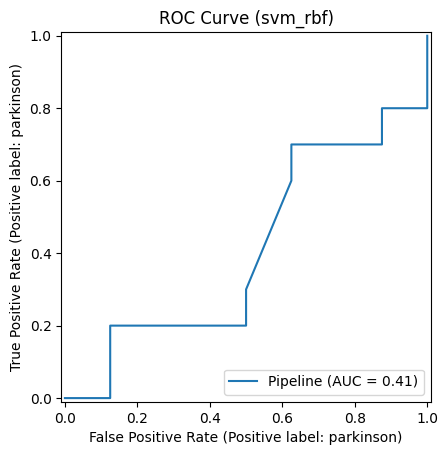


Permutation importance on test set (top 15):


feature  importance_mean  importance_std
12        r1_res_mad         0.011111        0.022222
60      r3_deriv_rms         0.007407        0.027716
53            r3_std         0.007407        0.034347
65      r3_E_mid_5_8         0.007407        0.034347
15            r1_zcr         0.000000        0.000000
1           center_y         0.000000        0.000000
0           center_x         0.000000        0.000000
22  r1_spec_centroid         0.000000        0.000000
83    r23_spacing_cv         0.000000        0.020286
61            r3_zcr         0.000000        0.000000
55      r3_slope_deg         0.000000        0.000000
62       r3_dom_harm         0.000000        0.000000
70     r3_spec_decay         0.000000        0.000000
66    r3_E_high_9_12         0.000000        0.000000
58        r3_res_mad         0.000000        0.035136

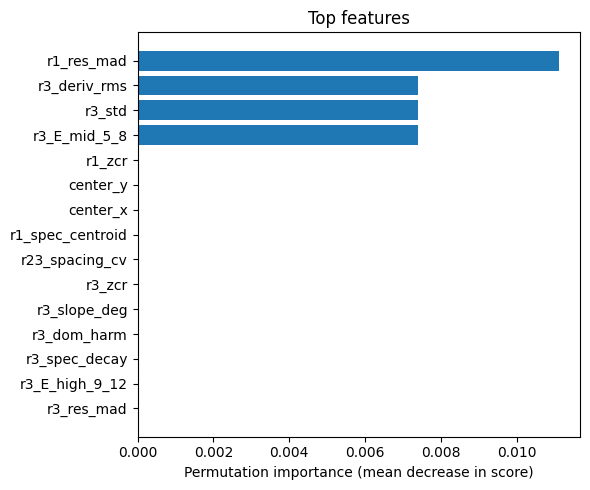


Saved best model to: /content/best_model_svm_rbf.joblib


In [ ]:
# Colab: model compare + hyperparameter tuning + evaluation on spiral_features.csv
!pip -q install scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib, warnings, os
warnings.filterwarnings("ignore", category=UserWarning)

CSV_PATH = "/content/spiral_features_new_reduced2.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20

# 1) Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape, "columns")

# 2) Features / labels
non_feature = {"path","label"}
feature_cols = [c for c in df.columns if c not in non_feature and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()
y = df["label"].astype(str)
print("Features:", len(feature_cols), "| Classes:", dict(y.value_counts()))

# 3) Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

binary = (y.nunique() == 2)
scorer = "roc_auc" if binary else "accuracy"

# 4) Model spaces
pip_base = [("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]

models = {
    "svm_rbf": Pipeline(pip_base + [("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "svm_linear": Pipeline(pip_base + [("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "logreg": Pipeline(pip_base + [("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))]),
    "rf": Pipeline([("impute", SimpleImputer(strategy="median")),
                    ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE))]),
}

param_grids = {
    "svm_rbf": {
        "clf__C":    [0.3, 1, 3, 10],
        "clf__gamma":[0.001, 0.003, 0.01, 0.03],
    },
    "svm_linear": {
        "clf__C": [0.3, 1, 3, 10],
    },
    "logreg": {
        "clf__C": [0.3, 1, 3, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    },
    "rf": {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 8, 12],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
    },
}

# 5) GridSearchCV per model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
best_name, best_est, best_score = None, None, -np.inf

for name, pipe in models.items():
    print(f"\nTuning {name}...")
    gs = GridSearchCV(pipe, param_grids[name], scoring=scorer, cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    print("  best params:", gs.best_params_)
    print(f"  best CV {scorer}: {gs.best_score_:.4f}")
    if gs.best_score_ > best_score:
        best_name, best_est, best_score = name, gs.best_estimator_, gs.best_score_

print(f"\nSelected model: {best_name} with CV {scorer}={best_score:.4f}")

# 6) Fit selected on full train (already refit=True)
best_est.fit(X_train, y_train)

# 7) Evaluate on test
y_pred = best_est.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix [rows=true, cols=pred]:")
print(confusion_matrix(y_test, y_pred))

if binary:
    # ensure consistent positive class index
    classes_sorted = sorted(best_est.named_steps["clf"].classes_)
    pos_idx = classes_sorted.index(classes_sorted[-1])
    proba = best_est.predict_proba(X_test)[:, pos_idx]
    auc = roc_auc_score((y_test==classes_sorted[-1]).astype(int), proba)
    print(f"\nROC-AUC: {auc:.4f}")
    RocCurveDisplay.from_estimator(best_est, X_test, y_test)
    plt.title(f"ROC Curve ({best_name})")
    plt.show()

# 8) Permutation importance (top 15)
try:
    print("\nPermutation importance on test set (top 15):")
    r = permutation_importance(best_est, X_test, y_test, n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1)
    importances = pd.DataFrame({
        "feature": feature_cols,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False)
    display(importances.head(15))
    # simple barplot
    top = importances.head(15)[::-1]
    plt.figure(figsize=(6,5))
    plt.barh(top["feature"], top["importance_mean"])
    plt.xlabel("Permutation importance (mean decrease in score)")
    plt.title("Top features")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)

# 9) Save model
MODEL_PATH = f"/content/best_model_{best_name}.joblib"
joblib.dump(best_est, MODEL_PATH)
print(f"\nSaved best model to: {MODEL_PATH}")


Loaded: (87, 89) columns
Features: 87 | Classes: {'parkinson': np.int64(48), 'healthy': np.int64(39)}

=== SVM-RBF ===
 Fold 1: Acc=0.611, AUC=0.738
 Fold 2: Acc=0.778, AUC=0.787
 Fold 3: Acc=0.529, AUC=0.528
 Fold 4: Acc=0.706, AUC=0.653
 Fold 5: Acc=0.588, AUC=0.771

SVM-RBF mean Acc: 0.642 ± 0.088
SVM-RBF mean AUC: 0.695 ± 0.096

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.5800    0.7436    0.6517        39
   parkinson     0.7297    0.5625    0.6353        48

    accuracy                         0.6437        87
   macro avg     0.6549    0.6530    0.6435        87
weighted avg     0.6626    0.6437    0.6426        87

Confusion matrix:
[[29 10]
 [21 27]]


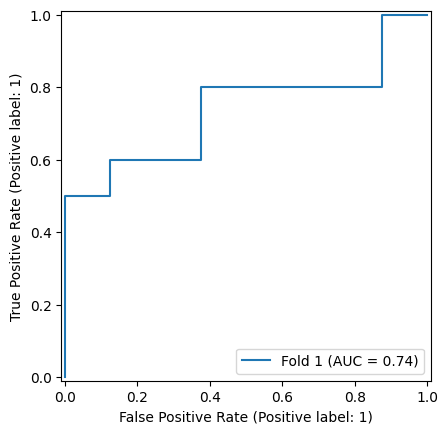

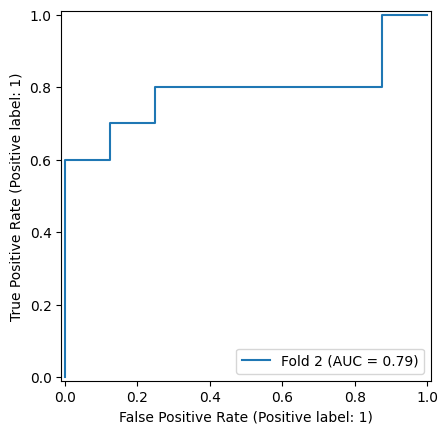

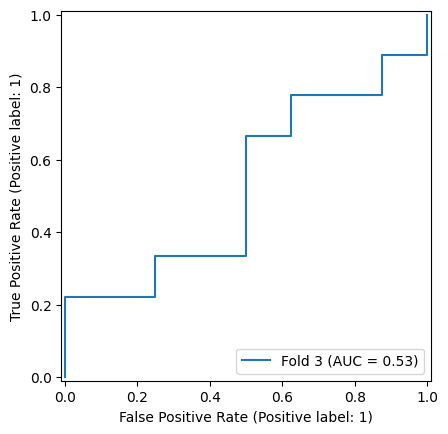

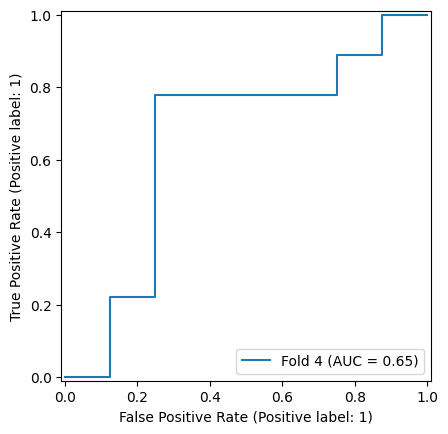

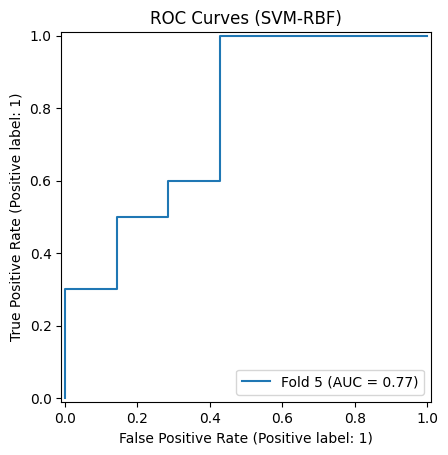


=== SVM-Linear ===
 Fold 1: Acc=0.667, AUC=0.700
 Fold 2: Acc=0.667, AUC=0.688
 Fold 3: Acc=0.412, AUC=0.493
 Fold 4: Acc=0.706, AUC=0.611
 Fold 5: Acc=0.647, AUC=0.757

SVM-Linear mean Acc: 0.620 ± 0.106
SVM-Linear mean AUC: 0.650 ± 0.091

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.5556    0.7692    0.6452        39
   parkinson     0.7273    0.5000    0.5926        48

    accuracy                         0.6207        87
   macro avg     0.6414    0.6346    0.6189        87
weighted avg     0.6503    0.6207    0.6162        87

Confusion matrix:
[[30  9]
 [24 24]]


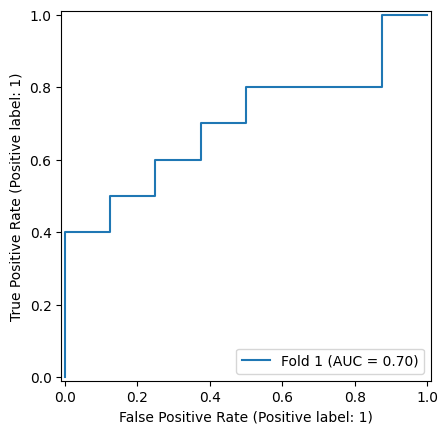

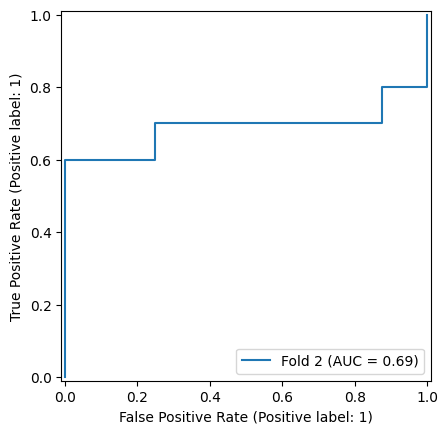

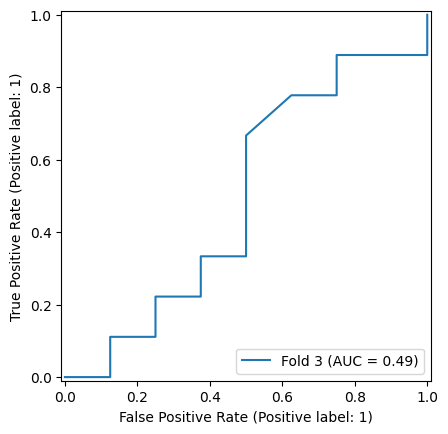

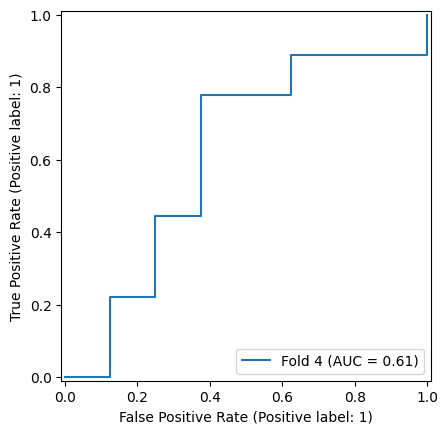

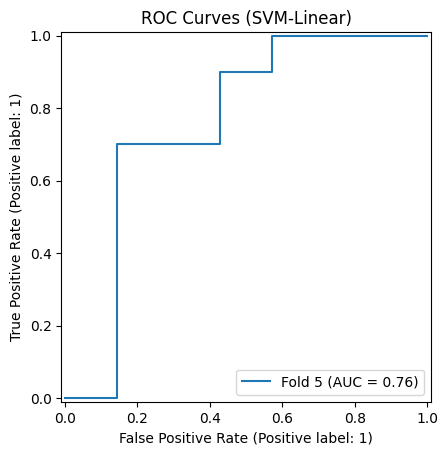


=== LogReg ===
 Fold 1: Acc=0.722, AUC=0.837
 Fold 2: Acc=0.667, AUC=0.600
 Fold 3: Acc=0.529, AUC=0.486
 Fold 4: Acc=0.471, AUC=0.597
 Fold 5: Acc=0.706, AUC=0.729

LogReg mean Acc: 0.619 ± 0.101
LogReg mean AUC: 0.650 ± 0.121

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.5652    0.6667    0.6118        39
   parkinson     0.6829    0.5833    0.6292        48

    accuracy                         0.6207        87
   macro avg     0.6241    0.6250    0.6205        87
weighted avg     0.6302    0.6207    0.6214        87

Confusion matrix:
[[26 13]
 [20 28]]


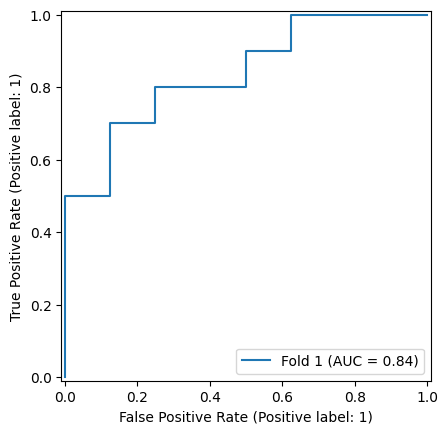

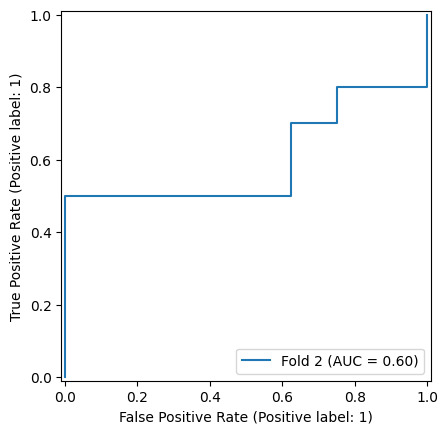

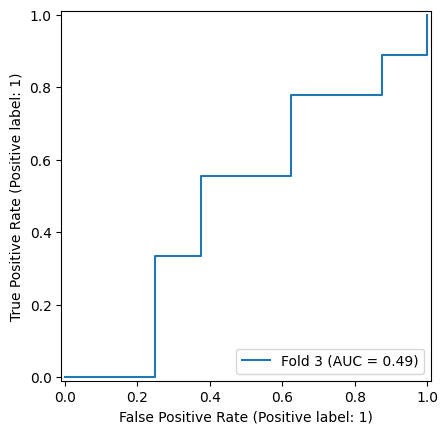

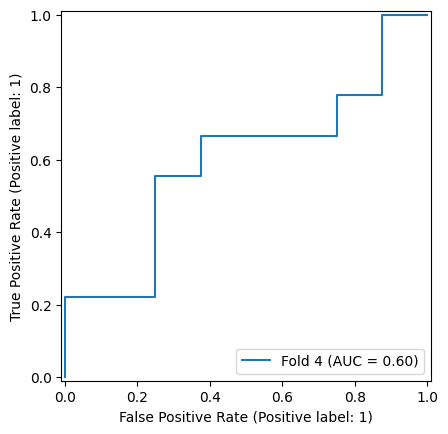

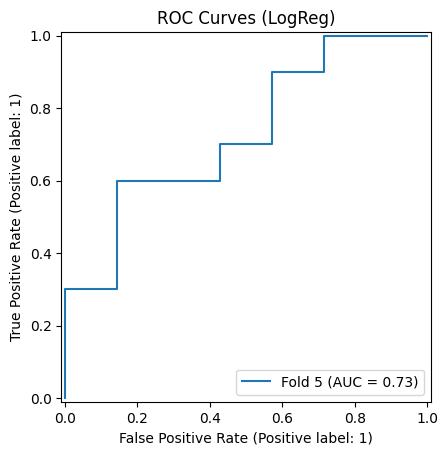


=== RF ===
 Fold 1: Acc=0.778, AUC=0.800
 Fold 2: Acc=0.667, AUC=0.775
 Fold 3: Acc=0.412, AUC=0.389
 Fold 4: Acc=0.706, AUC=0.722
 Fold 5: Acc=0.706, AUC=0.729

RF mean Acc: 0.654 ± 0.126
RF mean AUC: 0.683 ± 0.150

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6098    0.6410    0.6250        39
   parkinson     0.6957    0.6667    0.6809        48

    accuracy                         0.6552        87
   macro avg     0.6527    0.6538    0.6529        87
weighted avg     0.6571    0.6552    0.6558        87

Confusion matrix:
[[25 14]
 [16 32]]


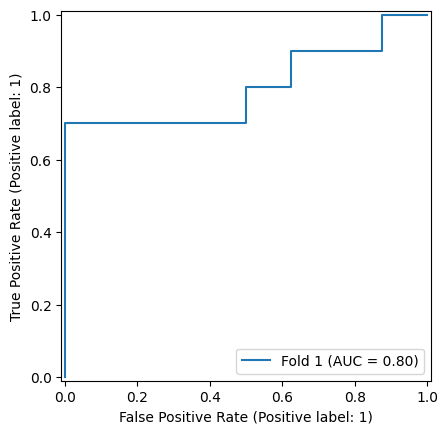

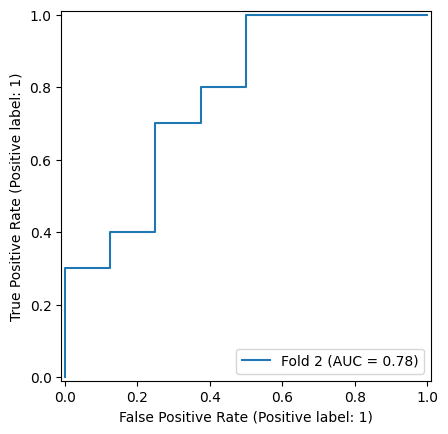

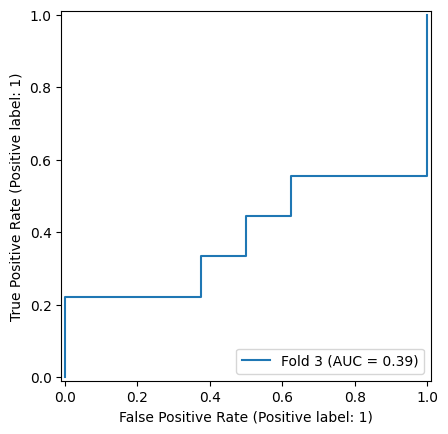

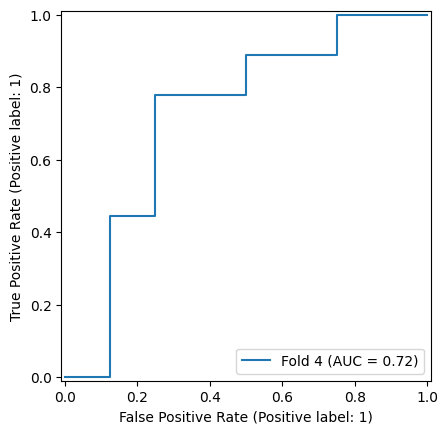

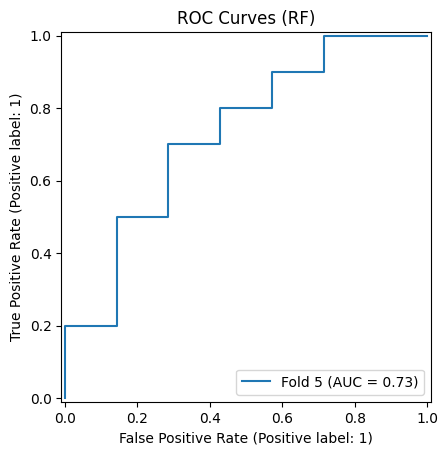


=== Summary ===
SVM-RBF: mean Acc=0.642 ± 0.088
      mean AUC=0.695 ± 0.096
SVM-Linear: mean Acc=0.620 ± 0.106
      mean AUC=0.650 ± 0.091
LogReg: mean Acc=0.619 ± 0.101
      mean AUC=0.650 ± 0.121
RF: mean Acc=0.654 ± 0.126
      mean AUC=0.683 ± 0.150


In [ ]:
# Colab: 5-fold CV + feature selection + multiple models
!pip -q install scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.base import clone

# -------------------
# CONFIG
# -------------------
CSV_PATH = "/content/spiral_features_new_reduced2.csv"   # change if needed
RANDOM_STATE = 42
N_SPLITS = 5
N_FEATURES = 20   # how many top features to keep

# -------------------
# Load data
# -------------------
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape, "columns")

non_feature = {"path","label"}
feature_cols = [c for c in df.columns if c not in non_feature and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()
y = df["label"].astype(str)

print("Features:", len(feature_cols), "| Classes:", dict(y.value_counts()))

binary = (y.nunique() == 2)

# -------------------
# Models to test
# -------------------
pip_base = [
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("select", SelectKBest(mutual_info_classif, k=min(N_FEATURES, len(feature_cols))))
]

models = {
    "SVM-RBF": Pipeline(pip_base + [("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "SVM-Linear": Pipeline(pip_base + [("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "LogReg": Pipeline(pip_base + [("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))]),
    "RF": Pipeline(pip_base[:-1] + [("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE))])
}

# -------------------
# Cross-validation loop
# -------------------
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    accs, aucs = [], []
    y_true_all, y_pred_all, y_proba_all = [], [], []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        mdl = clone(model)
        mdl.fit(X_tr, y_tr)
        y_pred = mdl.predict(X_te)

        acc = accuracy_score(y_te, y_pred)
        accs.append(acc)

        if binary:
            proba = mdl.predict_proba(X_te)[:, 1]  # assume second class is positive
            auc = roc_auc_score((y_te == sorted(y.unique())[-1]).astype(int), proba)
            aucs.append(auc)
            RocCurveDisplay.from_predictions((y_te == sorted(y.unique())[-1]).astype(int), proba, name=f"Fold {fold}")
        else:
            auc = np.nan
        print(f" Fold {fold}: Acc={acc:.3f}, AUC={auc:.3f}")

        y_true_all.extend(y_te)
        y_pred_all.extend(y_pred)

    print(f"\n{name} mean Acc: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    if binary:
        print(f"{name} mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

    print("\nClassification report (all folds pooled):")
    print(classification_report(y_true_all, y_pred_all, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_true_all, y_pred_all))

    plt.title(f"ROC Curves ({name})")
    plt.show()

    results[name] = {"acc": accs, "auc": aucs}

# -------------------
# Summary
# -------------------
print("\n=== Summary ===")
for name, res in results.items():
    print(f"{name}: mean Acc={np.mean(res['acc']):.3f} ± {np.std(res['acc']):.3f}")
    if binary:
        print(f"      mean AUC={np.mean(res['auc']):.3f} ± {np.std(res['auc']):.3f}")


Loaded: (87, 89)
Features: 87
Class counts: {'parkinson': 48, 'healthy': 39}

=== SVM_RBF ===
Best params: {'clf__C': 1, 'clf__gamma': 0.03}
CV mean score: 0.7298412698412698
Pooled accuracy: 0.6781609195402298
Confusion matrix:
 [[24 15]
 [13 35]]
              precision    recall  f1-score   support

     healthy       0.65      0.62      0.63        39
   parkinson       0.70      0.73      0.71        48

    accuracy                           0.68        87
   macro avg       0.67      0.67      0.67        87
weighted avg       0.68      0.68      0.68        87

Pooled AUC: 0.7099358974358974


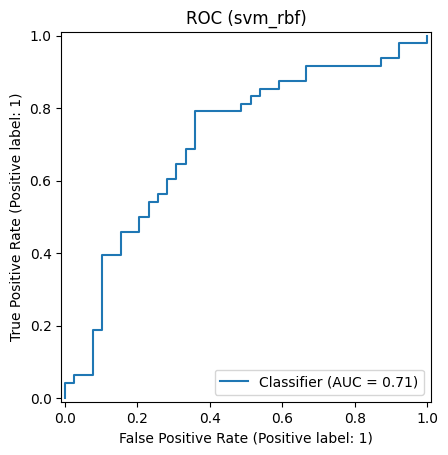


=== SVM_LINEAR ===
Best params: {'clf__C': 0.3}
CV mean score: 0.526468253968254
Pooled accuracy: 0.5287356321839081
Confusion matrix:
 [[25 14]
 [27 21]]
              precision    recall  f1-score   support

     healthy       0.48      0.64      0.55        39
   parkinson       0.60      0.44      0.51        48

    accuracy                           0.53        87
   macro avg       0.54      0.54      0.53        87
weighted avg       0.55      0.53      0.53        87

Pooled AUC: 0.4289529914529915


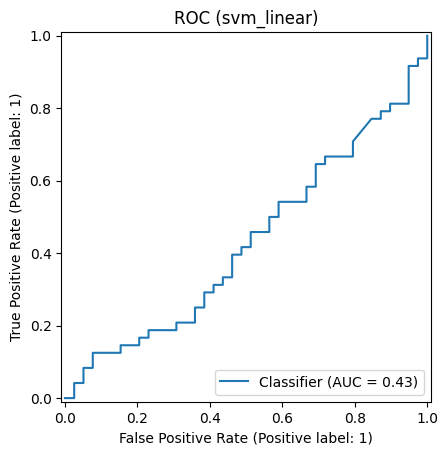


=== LOGREG ===
Best params: {'clf__C': 0.3, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
CV mean score: 0.5747619047619047
Pooled accuracy: 0.5747126436781609
Confusion matrix:
 [[23 16]
 [21 27]]
              precision    recall  f1-score   support

     healthy       0.52      0.59      0.55        39
   parkinson       0.63      0.56      0.59        48

    accuracy                           0.57        87
   macro avg       0.58      0.58      0.57        87
weighted avg       0.58      0.57      0.58        87

Pooled AUC: 0.6052350427350428


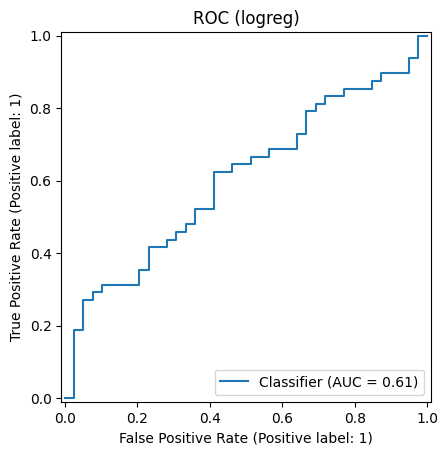


=== RF ===
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}
CV mean score: 0.700515873015873
Pooled accuracy: 0.6436781609195402
Confusion matrix:
 [[25 14]
 [17 31]]
              precision    recall  f1-score   support

     healthy       0.60      0.64      0.62        39
   parkinson       0.69      0.65      0.67        48

    accuracy                           0.64        87
   macro avg       0.64      0.64      0.64        87
weighted avg       0.65      0.64      0.64        87

Pooled AUC: 0.7131410256410257


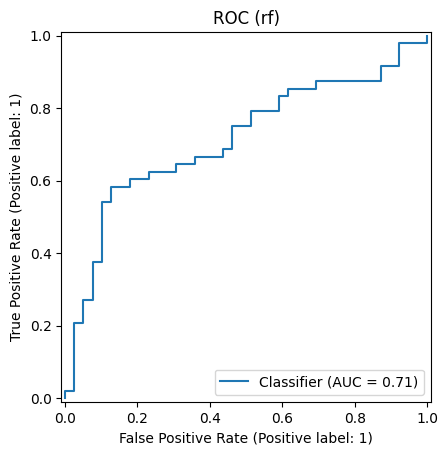


=== XGB ===


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1641, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['healthy' 'parkinson']


In [ ]:
# ============================
# Colab: Spiral Features ML Evaluation (All-in-One)
# ============================

!pip -q install scikit-learn xgboost pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib, warnings
warnings.filterwarnings("ignore")

# ------------------
# 1) Load data
# ------------------
CSV_PATH = "/content/spiral_features_new_reduced2.csv"   # <-- update if different
RANDOM_STATE = 42
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# Features and labels
non_feature = {"path","label"}
feature_cols = [c for c in df.columns if c not in non_feature and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()
y = df["label"].astype(str)

print("Features:", len(feature_cols))
print("Class counts:", y.value_counts().to_dict())

binary = (y.nunique() == 2)
scorer = "roc_auc" if binary else "accuracy"

# ------------------
# 2) Model definitions
# ------------------
pip_base = [("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
            ("fs", SelectKBest(mutual_info_classif, k="all"))]   # MI filter

models = {
    "svm_rbf": Pipeline(pip_base + [("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "svm_linear": Pipeline(pip_base + [("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=RANDOM_STATE))]),
    "logreg": Pipeline(pip_base + [("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))]),
    "rf": Pipeline([("impute", SimpleImputer(strategy="median")),
                    ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE))]),
    "xgb": Pipeline([("impute", SimpleImputer(strategy="median")),
                     ("clf", xgb.XGBClassifier(
                         eval_metric="logloss", use_label_encoder=False,
                         random_state=RANDOM_STATE, n_estimators=400, scale_pos_weight=1))])
}

param_grids = {
    "svm_rbf": {"clf__C":[0.3,1,3,10], "clf__gamma":[0.001,0.003,0.01,0.03]},
    "svm_linear": {"clf__C":[0.3,1,3,10]},
    "logreg": {"clf__C":[0.3,1,3,10], "clf__penalty":["l2"], "clf__solver":["lbfgs"]},
    "rf": {"clf__max_depth":[None,8,12], "clf__min_samples_split":[2,5], "clf__min_samples_leaf":[1,2]},
    "xgb": {"clf__max_depth":[3,6], "clf__learning_rate":[0.05,0.1], "clf__subsample":[0.7,1.0]}
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ------------------
# 3) Run models (CV + test split)
# ------------------
results = {}

for name, pipe in models.items():
    print(f"\n=== {name.upper()} ===")
    gs = GridSearchCV(pipe, param_grids[name], scoring=scorer, cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    # cross-val predictions
    y_pred = cross_val_predict(gs.best_estimator_, X, y, cv=cv)
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    print("Best params:", gs.best_params_)
    print("CV mean score:", gs.best_score_)
    print("Pooled accuracy:", acc)
    print("Confusion matrix:\n", cm)
    print(classification_report(y, y_pred))

    # ROC/AUC
    if binary:
        proba = cross_val_predict(gs.best_estimator_, X, y, cv=cv, method="predict_proba")[:,1]
        auc = roc_auc_score((y==sorted(y.unique())[-1]).astype(int), proba)
        print("Pooled AUC:", auc)
        RocCurveDisplay.from_predictions((y==sorted(y.unique())[-1]).astype(int), proba)
        plt.title(f"ROC ({name})")
        plt.show()
    results[name] = (gs.best_estimator_, gs.best_score_)

# ------------------
# 4) Pick best model and save
# ------------------
best_name, (best_est, best_score) = max(results.items(), key=lambda kv: kv[1][1])
print(f"\nSelected best model: {best_name} | CV {scorer}: {best_score:.3f}")
MODEL_PATH = f"/content/best_model_{best_name}.joblib"
joblib.dump(best_est, MODEL_PATH)
print("Saved to:", MODEL_PATH)


Loaded: (87, 89)
Class mapping: {'healthy': np.int64(0), 'parkinson': np.int64(1)}

=== SVM-RBF ===
Best params: {'clf__C': 1, 'clf__gamma': 0.03}
SVM-RBF mean Acc: 0.678, AUC: 0.710

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6486    0.6154    0.6316        39
   parkinson     0.7000    0.7292    0.7143        48

    accuracy                         0.6782        87
   macro avg     0.6743    0.6723    0.6729        87
weighted avg     0.6770    0.6782    0.6772        87

Confusion matrix:
 [[24 15]
 [13 35]]


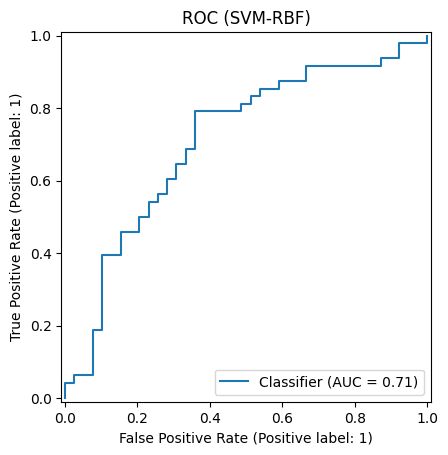


=== XGBOOST ===
Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost mean Acc: 0.655, AUC: 0.733

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6216    0.5897    0.6053        39
   parkinson     0.6800    0.7083    0.6939        48

    accuracy                         0.6552        87
   macro avg     0.6508    0.6490    0.6496        87
weighted avg     0.6538    0.6552    0.6542        87

Confusion matrix:
 [[23 16]
 [14 34]]


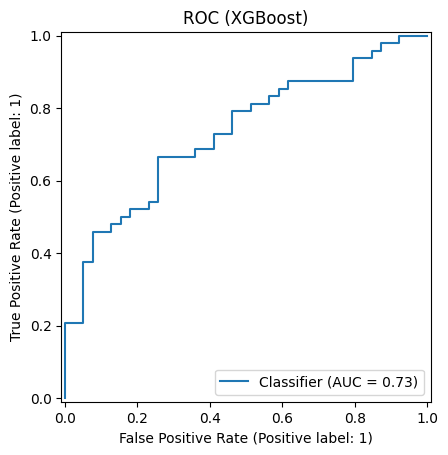

In [ ]:
# Colab: SVM-RBF + XGBoost with proper label encoding and CV
!pip -q install scikit-learn pandas numpy matplotlib xgboost

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------- Load ----------
CSV_PATH = "/content/spiral_features_new_reduced2.csv"   # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# ---------- Features / labels ----------
X = df[[c for c in df.columns if c not in {"path","label"}]]
y_raw = df["label"].astype(str)

# Encode labels: healthy=0, parkinson=1
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------- Cross-validation setup ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_model(name, model, param_grid):
    print(f"\n=== {name.upper()} ===")
    # GridSearchCV
    gs = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
    gs.fit(X, y)
    best_model = gs.best_estimator_
    print("Best params:", gs.best_params_)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=cv, method="predict")
    y_proba = cross_val_predict(best_model, X, y, cv=cv, method="predict_proba")[:,1]

    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    print(f"{name} mean Acc: {acc:.3f}, AUC: {auc:.3f}")
    print("\nClassification report (all folds pooled):")
    print(classification_report(y, y_pred, target_names=le.classes_, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC ({name})")
    plt.show()
    return best_model

# ---------- Models ----------
svm_rbf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])
svm_params = {"clf__C":[0.3,1,3,10], "clf__gamma":[0.001,0.003,0.01,0.03]}

xgb = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    scale_pos_weight=len(y[y==0]) / len(y[y==1]) # handle class imbalance
)
xgb_params = {
    "n_estimators":[200,400],
    "max_depth":[3,6],
    "learning_rate":[0.05,0.1,0.2],
    "subsample":[0.8,1.0]
}

# ---------- Run ----------
best_svm = run_model("SVM-RBF", svm_rbf, svm_params)
best_xgb = run_model("XGBoost", xgb, xgb_params)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to dataset
dataset_path = '/content/drive/MyDrive/PD_Spiral_Dataset'




Mounted at /content/drive



✅ Saved features CSV: /content/spiral_features_new_increased2.csv
Rows: 116  |  Columns: 89

▶ Plot: resized_spiral_batch2_4_256.png  [healthy]


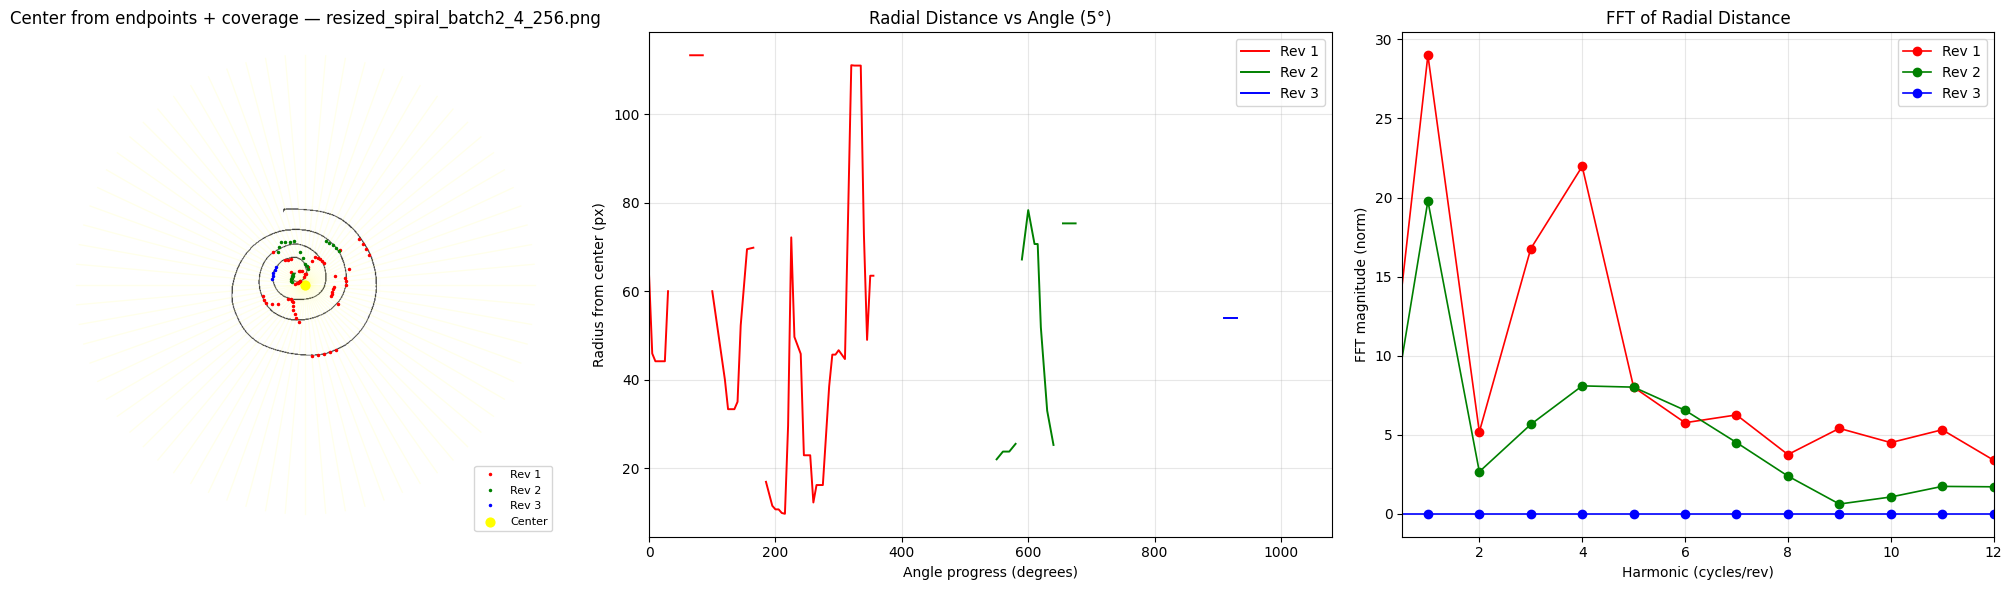


▶ Plot: Copy of V08HE01.png  [healthy]


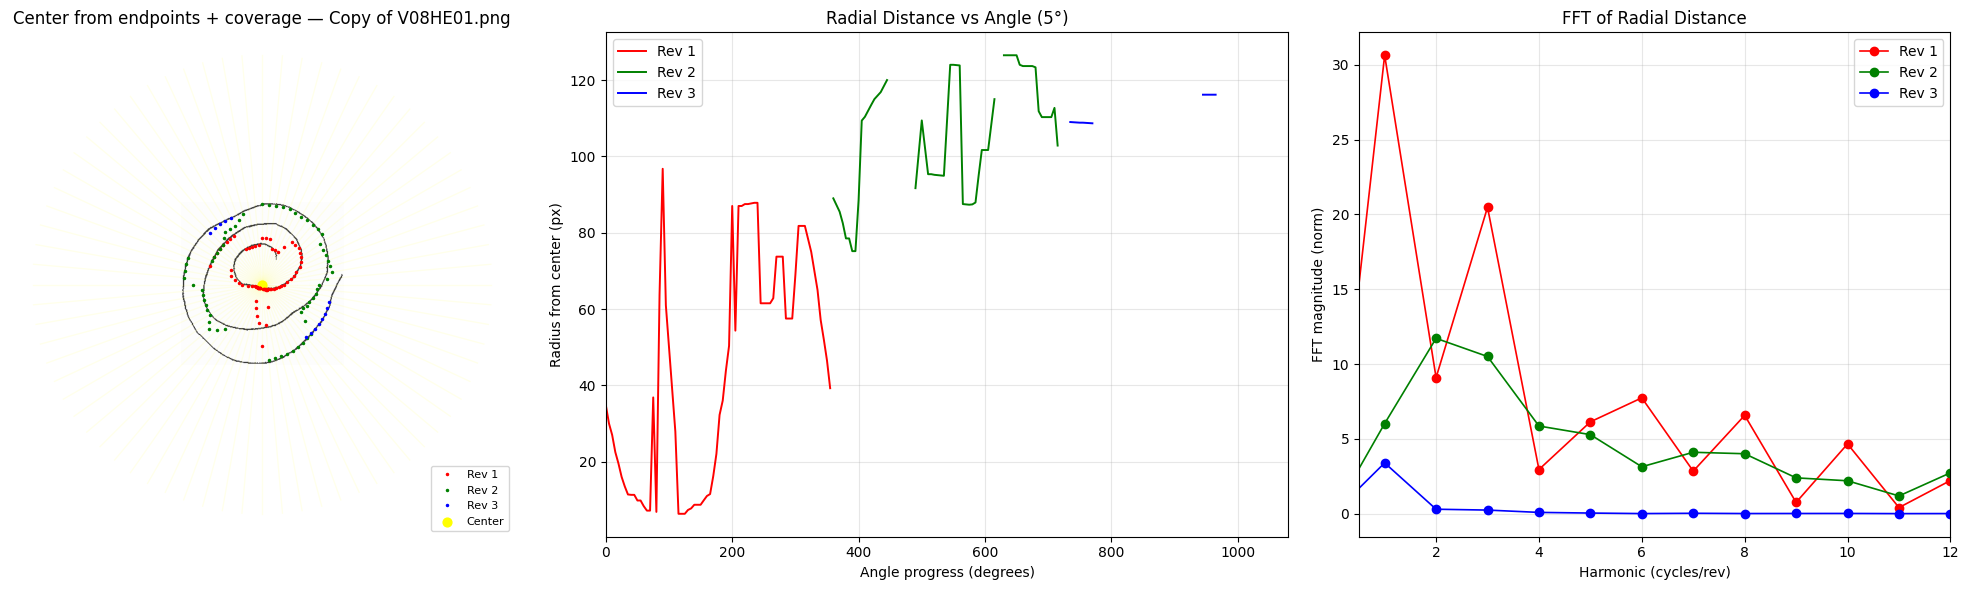


▶ Plot: Copy of V02PE01.png  [parkinson]


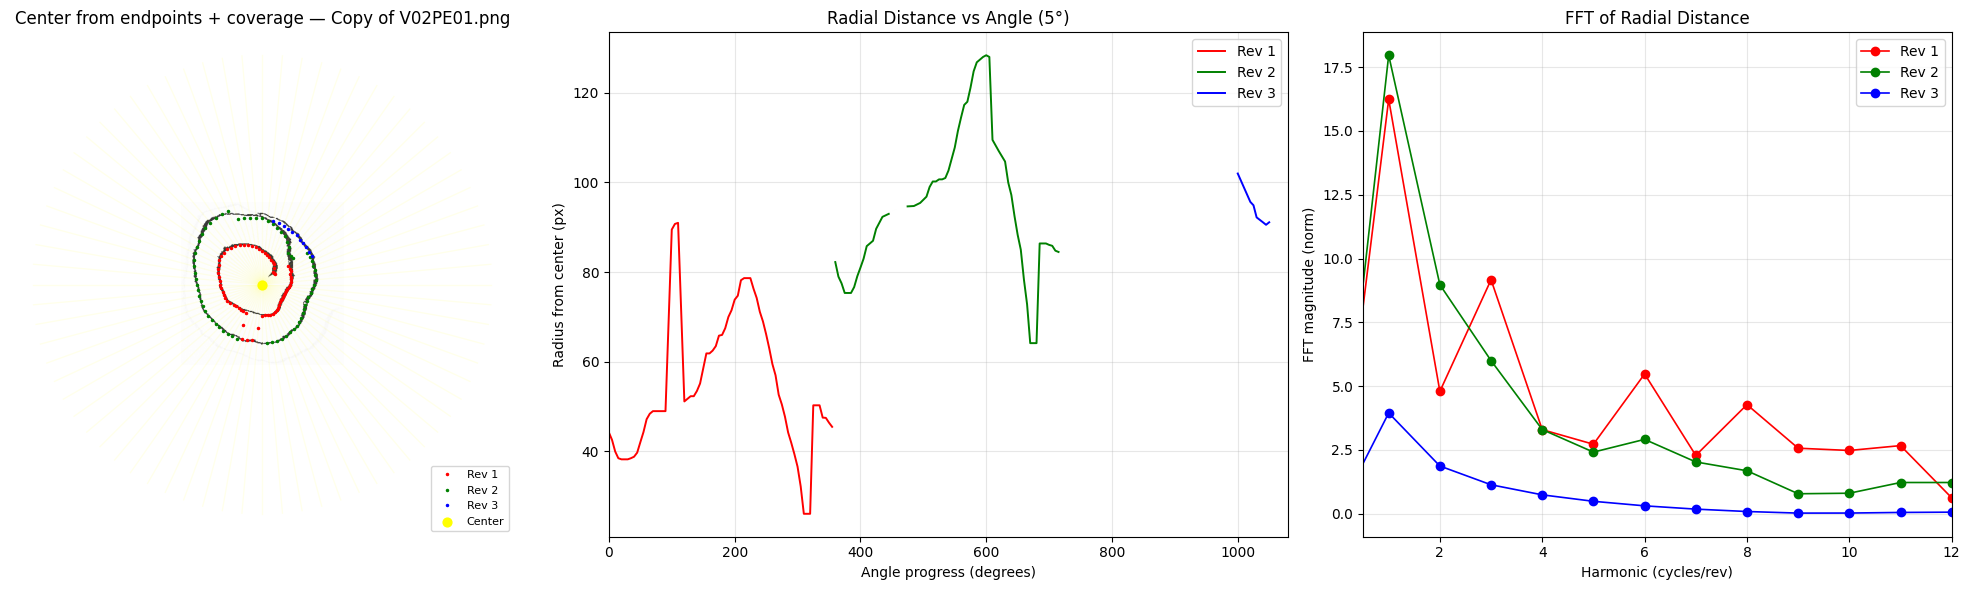


▶ Plot: resized_spiral_batch11_5_256.png  [parkinson]


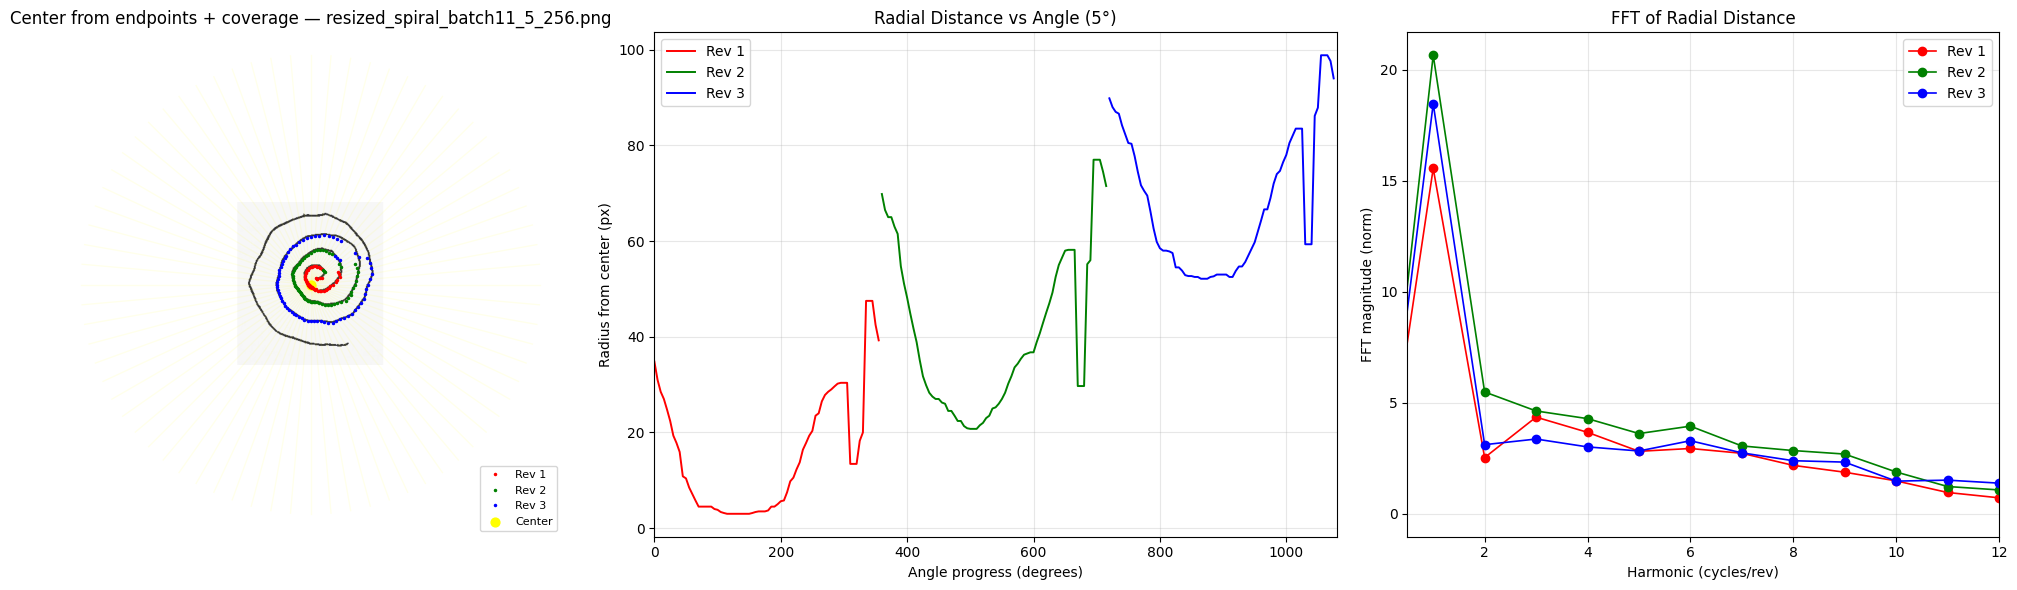

In [ ]:
# ===========================================
# Colab one-cell: Spiral features (healthy vs parkinson)
# - Robust center from endpoints + angular coverage
# - Direct 3-rev sampling per 5° ray (no peel)
# - Plot a few examples (for verification)
# - Extract MANY features from rings and FFT
# - Save one CSV for ALL images in both folders
# ===========================================

# --- deps ---
!pip -q install opencv-python scikit-image numpy matplotlib pandas

import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.morphology import skeletonize
from skimage.util import img_as_bool

# -------- CONFIG: paths & knobs --------
BASE_TRAIN = "/content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training"
TRAIN_HEALTHY   = os.path.join(BASE_TRAIN, "healthy")
TRAIN_PARKINSON = os.path.join(BASE_TRAIN, "parkinson")

REVS = 3                    # how many revolutions to extract per ray
ANGLE_STEP_DEG = 5.0        # 5° sampling
R_STEP_PX = 0.5             # radial sampling step along a ray
MIN_RUN_LEN = 3             # min consecutive ink pixels to accept a run
MIN_BG_GAP = 2              # min background pixels separating runs
SMOOTH_WIN = 5              # median smoothing window (odd; 0/1 disables)
FILL_GAP_DEG = 10.0         # fill NaN runs up to this many degrees

MAX_HARMONIC_TO_SHOW = 12
REMOVE_DC = True

N_VERIFY_PLOTS_PER_CLASS = 2   # how many images to PLOT from each folder (only for visual check)
RANDOM_SEED = 42
SAVE_CSV_PATH = "/content/spiral_features_new_increased2.csv"
# --------------------------------------

# ---------- binarize/polarity ----------
ADAPT_BLOCK = 41
ADAPT_C = 10
MORPH_CLOSE_K = 3
KEEP_LARGEST_IF_FRAC = 0.5
POLARITY_MIN_WHITE_FRAC = 0.55

def force_white_background(img_bin, min_white_frac=POLARITY_MIN_WHITE_FRAC):
    if float(np.mean(img_bin == 255)) < min_white_frac:
        img_bin = 255 - img_bin
    return img_bin

def binarize_conservative(img_gray):
    _, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adapt = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, ADAPT_BLOCK, ADAPT_C)
    bin_or = cv2.bitwise_or(otsu, adapt)
    bin_or = force_white_background(bin_or)
    if MORPH_CLOSE_K >= 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_CLOSE_K, MORPH_CLOSE_K))
        inv = 255 - bin_or
        inv = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, k, iterations=1)
        bin_or = 255 - inv
    return force_white_background(bin_or)

def keep_largest_component_guarded(img_bin, keep_fraction=KEEP_LARGEST_IF_FRAC):
    ink = (img_bin == 0).astype(np.uint8)
    total = int(ink.sum())
    if total == 0: return img_bin
    num, labels, stats, _ = cv2.connectedComponentsWithStats(ink, 8)
    if num <= 2: return img_bin
    areas = stats[1:, cv2.CC_STAT_AREA]
    li = 1 + int(np.argmax(areas))
    if int(areas.max()) >= keep_fraction * total:
        keep = (labels == li)
        out = np.full_like(img_bin, 255, np.uint8); out[keep] = 0
        return out
    return img_bin

# ---------- skeleton + endpoints ----------
def get_skeleton_endpoints(img_bin):
    ink = (img_bin == 0).astype(np.uint8)
    skel = skeletonize(img_as_bool(ink))
    ys, xs = np.where(skel)

    H, W = img_bin.shape
    endpoints = []
    for y, x in zip(ys, xs):
        y0, y1 = max(0, y-1), min(H, y+2)
        x0, x1 = max(0, x-1), min(W, x+2)
        nb = np.count_nonzero(skel[y0:y1, x0:x1]) - 1
        if nb == 1:
            endpoints.append((x, y))
    if len(endpoints) >= 2:
        ep = np.array(endpoints)
        best = (0, (ep[0], ep[1]))
        for i in range(len(ep)):
            d = np.sum((ep[i] - ep)**2, axis=1)
            j = int(np.argmax(d))
            if d[j] > best[0]:
                best = (d[j], (tuple(ep[i]), tuple(ep[j])))
        e1, e2 = best[1]
    elif len(endpoints) == 1:
        e1, e2 = endpoints[0], endpoints[0]
    else:
        e1 = e2 = (img_bin.shape[1]//2, img_bin.shape[0]//2)
    return skel, np.array(list(zip(xs,ys))), e1, e2

# ---------- center from endpoints + angular coverage ----------
def circular_variance(angles):
    v = np.exp(1j * angles)
    return 1.0 - np.abs(np.mean(v))  # 0 = aligned, 1 = uniform coverage

def score_center(center, pts, sample_size=400):
    cx, cy = center
    if pts.shape[0] == 0:
        return -1e9
    if pts.shape[0] > sample_size:
        idx = np.random.RandomState(0).choice(pts.shape[0], sample_size, replace=False)
        P = pts[idx]
    else:
        P = pts
    dx = P[:,0] - cx
    dy = P[:,1] - cy
    m = (dx*dx + dy*dy) > 4.0
    if not np.any(m):
        return -1e9
    ang = np.arctan2(dy[m], dx[m])  # -π..π
    ang = (ang + 2*np.pi) % (2*np.pi)
    return circular_variance(ang)

def refine_center_by_angular_coverage(img_bin, seeds, pts, coarse=5, fine=2):
    H, W = img_bin.shape
    best = (-1e9, seeds[0])
    for (sx, sy) in seeds:
        sx = int(np.clip(sx, 0, W-1)); sy = int(np.clip(sy, 0, H-1))
        cx, cy = sx, sy
        for step in [coarse, fine]:
            improved = True
            while improved:
                improved = False
                base = score_center((cx, cy), pts)
                for dx in (-step, 0, step):
                    for dy in (-step, 0, step):
                        nx, ny = int(np.clip(cx+dx, 0, W-1)), int(np.clip(cy+dy, 0, H-1))
                        sc = score_center((nx, ny), pts)
                        if sc > base:
                            cx, cy, base = nx, ny, sc
                            improved = True
                if base > best[0]:
                    best = (base, (cx, cy))
    return best[1]

def estimate_center_from_endpoints(img_bin):
    H, W = img_bin.shape
    skel, pts, e1, e2 = get_skeleton_endpoints(img_bin)
    mid = ((e1[0]+e2[0])//2, (e1[1]+e2[1])//2)
    white = (img_bin == 255).astype(np.uint8) * 255
    dist = cv2.distanceTransform(white, cv2.DIST_L2, 5)
    y, x = np.unravel_index(np.argmax(dist), dist.shape)
    dt_peak = (int(x), int(y))
    ys, xs = np.where((img_bin == 0))
    centroid = (int(np.mean(xs)) if xs.size else W//2, int(np.mean(ys)) if ys.size else H//2)
    seeds = [mid, dt_peak, centroid]
    cx, cy = refine_center_by_angular_coverage(img_bin, seeds, pts)
    return int(cx), int(cy)

# ---------- ray sampling (first K ink runs) ----------
def ray_coords(cx, cy, theta_rad, r_max, r_step=R_STEP_PX, H=None, W=None):
    r = np.arange(0.0, r_max, r_step, dtype=np.float32)
    x = cx + r*np.cos(theta_rad)
    y = cy + r*np.sin(theta_rad)
    xi = np.rint(x).astype(int)
    yi = np.rint(y).astype(int)
    if H is not None and W is not None:
        m = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
        xi, yi, r = xi[m], yi[m], r[m]
    if xi.size > 1:
        dup = (np.diff(xi)==0) & (np.diff(yi)==0)
        keep = np.ones_like(xi, bool); keep[1:] &= ~dup
        xi, yi, r = xi[keep], yi[keep], r[keep]
    return xi, yi, r

def first_k_runs_along_ray(img_bin, xi, yi, r, k=3, min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP):
    ink = (img_bin[yi, xi] == 0).astype(np.int8)
    runs = []
    i = 0
    n = len(ink)
    while i < n and len(runs) < k:
        while i < n and ink[i] == 0: i += 1
        s = i
        while i < n and ink[i] == 1: i += 1
        e = i
        if e - s >= min_run:
            runs.append(float(np.mean(r[s:e])))
        gap = 0
        while i < n and ink[i] == 0 and gap < min_gap:
            i += 1; gap += 1
    if len(runs) < k:
        runs += [np.nan]*(k - len(runs))
    return runs[:k]

def sample_rings(img_bin, cx, cy, angle_step=ANGLE_STEP_DEG, k_revs=REVS):
    H, W = img_bin.shape
    r_max = float(np.hypot(W, H))
    angles_deg = np.arange(0.0, 360.0, angle_step, dtype=float)
    rings = np.full((k_revs, len(angles_deg)), np.nan, float)
    for j, ang in enumerate(angles_deg):
        th = np.deg2rad(ang)
        xi, yi, r = ray_coords(cx, cy, th, r_max, R_STEP_PX, H, W)
        if len(xi) == 0: continue
        runs = first_k_runs_along_ray(img_bin, xi, yi, r, k=k_revs,
                                      min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP)
        rings[:, j] = runs
    return angles_deg, rings

# ---------- smoothing / fill ----------
def _median_filter_circ(arr, w):
    if w<=1 or w%2==0: return arr
    n=len(arr); out=arr.copy(); h=w//2
    for i in range(n):
        idx=[(i+d)%n for d in range(-h,h+1)]
        seg=arr[idx]; seg=seg[np.isfinite(seg)]
        if seg.size: out[i]=np.median(seg)
    return out

def _fill_small_gaps(arr, max_gap_bins):
    out=arr.copy(); n=len(arr); i=0
    while i<n:
        if np.isnan(out[i]):
            j=i
            while j<n and np.isnan(out[j]): j+=1
            if i>0 and j<n and (j-i)<=max_gap_bins:
                out[i:j]=np.linspace(out[i-1], out[j], (j-i)+2)[1:-1]
            i=j
        else: i+=1
    return out

def tidy_rings(rings, angle_step=ANGLE_STEP_DEG, smooth_win=SMOOTH_WIN, fill_gap_deg=FILL_GAP_DEG):
    max_gap_bins = int(round(fill_gap_deg/angle_step)) if fill_gap_deg>0 else 0
    out=rings.copy()
    for k in range(out.shape[0]):
        r=out[k]
        if max_gap_bins>0: r=_fill_small_gaps(r, max_gap_bins)
        if smooth_win and smooth_win%2==1 and smooth_win>1: r=_median_filter_circ(r, smooth_win)
        out[k]=r
    return out

# ---------- FFT ----------
def ring_fft(sig):
    x=sig.astype(float)
    if np.any(~np.isfinite(x)):
        n=len(x); idx=np.arange(n); m=np.isfinite(x)
        if m.sum()==0: x=np.zeros_like(x)
        else:
            xi=np.concatenate([idx[m], idx[m]+n]); yi=np.concatenate([x[m],x[m]])
            idx2=idx.copy(); idx2[idx<idx[m].min()]+=n
            x=np.interp(idx2, xi, yi)
    if REMOVE_DC: x=x-np.mean(x)
    R=np.fft.rfft(x); mag=np.abs(R)/len(x); mag[1:-1]*=2.0
    h=np.arange(len(mag)); return h, mag

# ---------- plotting ----------
def plot_all(img_gray, img_bin, cx, cy, angles, rings, fft_h, fft_mag, title):
    colors=['red','green','blue','purple','orange']
    fig=plt.figure(figsize=(20,6))
    gs=fig.add_gridspec(1,3,width_ratios=[1.2,1.5,1.3])
    ax0=fig.add_subplot(gs[0,0]); ax1=fig.add_subplot(gs[0,1]); ax2=fig.add_subplot(gs[0,2])

    ax0.imshow(img_gray,cmap='gray',alpha=0.25)
    ax0.imshow(img_bin,cmap='gray',alpha=0.75)
    H,W=img_bin.shape; edge=int(np.hypot(W,H))
    for ang in angles:
        x2=int(round(cx+edge*np.cos(np.deg2rad(ang))))
        y2=int(round(cy+edge*np.sin(np.deg2rad(ang))))
        ax0.plot([cx,x2],[cy,y2],color='yellow',alpha=0.08,linewidth=1)
    for k in range(min(REVS, rings.shape[0])):
        m=np.isfinite(rings[k]); th=np.deg2rad(angles[m]); rr=rings[k,m]
        xs=cx+rr*np.cos(th); ys=cy+rr*np.sin(th)
        ax0.plot(xs,ys,'.',color=colors[k%len(colors)],markersize=3,label=f"Rev {k+1}")
    ax0.scatter(cx,cy,c='yellow',s=40,label='Center'); ax0.axis('off'); ax0.legend(loc='lower right',fontsize=8)
    ax0.set_title(f"Center from endpoints + coverage — {title}")

    for k in range(min(REVS, rings.shape[0])):
        ax1.plot(angles+360.0*k, rings[k], color=colors[k%len(colors)], linewidth=1.4, label=f"Rev {k+1}")
    ax1.set_xlim(0, 360.0*REVS); ax1.grid(True,alpha=0.3)
    ax1.set_xlabel("Angle progress (degrees)"); ax1.set_ylabel("Radius from center (px)")
    ax1.set_title(f"Radial Distance vs Angle ({ANGLE_STEP_DEG:.0f}°)"); ax1.legend()

    for k in range(min(REVS, rings.shape[0])):
        h, m = fft_h[k], fft_mag[k]; mask = (h<=MAX_HARMONIC_TO_SHOW)
        ax2.plot(h[mask], m[mask], marker='o', linewidth=1.2, label=f"Rev {k+1}", color=colors[k%len(colors)])
    ax2.set_xlabel("Harmonic (cycles/rev)"); ax2.set_ylabel("FFT magnitude (norm)")
    ax2.set_title("FFT of Radial Distance"); ax2.grid(True,alpha=0.3); ax2.legend()
    if REMOVE_DC: ax2.set_xlim(0.5, MAX_HARMONIC_TO_SHOW)
    else:         ax2.set_xlim(0, MAX_HARMONIC_TO_SHOW)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---------- Feature extraction ----------
def _finite(x): return np.isfinite(x)

def _linfit_slope_deg(angles_deg, y):
    m = _finite(y)
    if m.sum() < 6: return np.nan
    x = angles_deg[m]
    yy = y[m]
    x = x - x.mean()
    denom = (x*x).sum()
    if denom == 0: return 0.0
    return float((x*yy).sum()/denom)

def _num_gaps_and_maxgap(ang, y):
    m = _finite(y)
    if m.all(): return 0, 0.0
    mask = ~m.astype(bool)
    gaps = 0; maxgap = 0.0
    n = len(mask)
    i = 0
    step_deg = float(ang[1]-ang[0])
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]: j += 1
            gaps += 1
            maxgap = max(maxgap, (j - i) * step_deg)
            i = j
        else:
            i += 1
    if mask[0] and mask[-1]:
        i0 = 0
        while i0 < n and mask[i0]: i0 += 1
        jn = n-1
        while jn >= 0 and mask[jn]: jn -= 1
        merged = (i0 + (n-1-jn)) * step_deg
        maxgap = max(maxgap, merged)
        gaps = max(0, gaps-1)
    return gaps, float(maxgap)

def _residuals(y):
    m = _finite(y)
    if m.sum()==0: return np.full_like(y, np.nan, dtype=float)
    med = np.nanmedian(y)
    r = y - med
    r[~m] = np.nan
    return r

def _derivative(x):
    y = x.copy()
    m = _finite(y)
    if m.sum() < 3: return np.full_like(y, np.nan, dtype=float)
    # circular forward diff
    d = np.roll(y, -1) - y
    d[~m] = np.nan
    return d

def _zcr(x):
    m = _finite(x)
    x = x[m]
    if len(x) < 3: return np.nan
    s = np.sign(x)
    s[s==0] = 1
    return float(np.mean(s[:-1] != s[1:]))

def _safe_corr(a, b):
    m = _finite(a) & _finite(b)
    if m.sum() < 6: return np.nan
    aa = a[m]; bb = b[m]
    if np.std(aa)==0 or np.std(bb)==0: return np.nan
    return float(np.corrcoef(aa, bb)[0,1])

def _spec_bands(h, mag):
    # ignore DC (0)
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan, np.nan, np.nan
    hh = h[m]; mm = mag[m]
    low = (hh>=2) & (hh<=4)
    mid = (hh>=5) & (hh<=8)
    high= (hh>=9) & (hh<=12)
    e_low  = float((mm[low]**2).sum()) if np.any(low) else 0.0
    e_mid  = float((mm[mid]**2).sum()) if np.any(mid) else 0.0
    e_high = float((mm[high]**2).sum()) if np.any(high) else 0.0
    return e_low, e_mid, e_high

def _spec_centroid(h, mag):
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); mm = mag[m].astype(float)
    s = mm.sum()
    if s==0: return np.nan
    return float((hh*mm).sum()/s)

def _spec_entropy(mag):
    m = _finite(mag)
    mm = mag[m].astype(float)
    if mm.size == 0: return np.nan
    s = mm.sum()
    if s <= 0: return np.nan
    p = mm / s
    p = p[p>0]
    return float(-(p*np.log(p)).sum())

def _spec_decay(h, mag):
    m = (h>=1) & _finite(mag) & (mag>0)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); lg = np.log(mag[m].astype(float))
    X = np.vstack([hh, np.ones_like(hh)]).T
    w = np.linalg.lstsq(X, lg, rcond=None)[0]
    return float(w[0])  # slope (more negative = steeper decay)

def compute_features(angles_deg, rings, fft_h, fft_mag):
    out = {}
    step_deg = float(angles_deg[1] - angles_deg[0]) if len(angles_deg)>1 else ANGLE_STEP_DEG

    for k in range(REVS):
        r = rings[k]
        m = _finite(r)
        coverage = float(np.mean(m)) if r.size else 0.0
        gaps, maxgap = _num_gaps_and_maxgap(angles_deg, r)

        out[f"r{k+1}_coverage_frac"] = coverage
        out[f"r{k+1}_num_gaps"]      = gaps
        out[f"r{k+1}_max_gap_deg"]   = maxgap

        out[f"r{k+1}_mean"]   = float(np.nanmean(r)) if m.any() else np.nan
        out[f"r{k+1}_median"] = float(np.nanmedian(r)) if m.any() else np.nan
        out[f"r{k+1}_std"]    = float(np.nanstd(r)) if m.any() else np.nan
        out[f"r{k+1}_ptp"]    = float(np.nanmax(r)-np.nanmin(r)) if m.any() else np.nan
        out[f"r{k+1}_slope_deg"] = _linfit_slope_deg(angles_deg, r)

        # monotonic breaks (sign changes in derivative of r)
        dr = _derivative(r)
        if np.all(~_finite(dr)):
            out[f"r{k+1}_monotonic_breaks"] = np.nan
        else:
            s = np.sign(dr)
            s[~_finite(s)] = 0
            s[s==0] = 1
            out[f"r{k+1}_monotonic_breaks"] = float(np.sum(s[:-1] != s[1:]))

        # residual-based roughness
        res = _residuals(r)
        out[f"r{k+1}_res_rms"] = float(np.sqrt(np.nanmean(res**2))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_mad"] = float(np.nanmedian(np.abs(res - np.nanmedian(res)))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_ptp"] = float(np.nanmax(res)-np.nanmin(res)) if _finite(res).any() else np.nan
        dres = _derivative(res)
        out[f"r{k+1}_deriv_rms"] = float(np.sqrt(np.nanmean(dres**2))) if _finite(dres).any() else np.nan
        out[f"r{k+1}_zcr"] = _zcr(dres)

        # spectrum
        h = fft_h[k]; mag = fft_mag[k]
        if REMOVE_DC:
            h0 = h[1:]; mag0 = mag[1:]
        else:
            h0 = h.copy(); mag0 = mag.copy()
        if mag0.size:
            dom_idx = int(np.argmax(mag0))
            out[f"r{k+1}_dom_harm"] = int(h0[dom_idx])
            out[f"r{k+1}_dom_amp"]  = float(mag0[dom_idx])
        else:
            out[f"r{k+1}_dom_harm"] = np.nan
            out[f"r{k+1}_dom_amp"]  = np.nan

        e_low, e_mid, e_high = _spec_bands(h, mag)
        out[f"r{k+1}_E_low_2_4"]  = e_low
        out[f"r{k+1}_E_mid_5_8"]  = e_mid
        out[f"r{k+1}_E_high_9_12"] = e_high
        out[f"r{k+1}_E_hi_lo_ratio"] = float(e_high / e_low) if e_low>0 else np.nan
        out[f"r{k+1}_spec_centroid"] = _spec_centroid(h, mag)
        out[f"r{k+1}_spec_entropy"]  = _spec_entropy(mag)
        out[f"r{k+1}_spec_decay"]    = _spec_decay(h, mag)

    # inter-ring spacing & coherence
    for (a,b) in [(0,1),(1,2)]:
        if a < rings.shape[0] and b < rings.shape[0]:
            ra, rb = rings[a], rings[b]
            spacing = rb - ra
            m = _finite(spacing)
            out[f"r{a+1}{b+1}_spacing_mean"] = float(np.nanmean(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_std"]  = float(np.nanstd(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_min"]  = float(np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_ptp"]  = float(np.nanmax(spacing)-np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_cv"]   = (out[f"r{a+1}{b+1}_spacing_std"] / out[f"r{a+1}{b+1}_spacing_mean"]) if m.any() and out[f"r{a+1}{b+1}_spacing_mean"] not in [0, np.nan] else np.nan
            # crossings: inner > outer? (spacing < 0)
            out[f"r{a+1}{b+1}_crossing_frac"] = float(np.mean(spacing[m] < 0.0)) if m.any() else np.nan

            # residual correlation
            res_a = _residuals(ra)
            res_b = _residuals(rb)
            out[f"r{a+1}{b+1}_corr_resid"] = _safe_corr(res_a, res_b)

            # fft magnitude correlation
            out[f"r{a+1}{b+1}_corr_fft"] = _safe_corr(fft_mag[a], fft_mag[b])

    return out

# ---------- run folders, plot some, write CSV ----------
def list_images(folder):
    exts=("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    paths=[]
    for e in exts: paths+=glob.glob(os.path.join(folder,e))
    paths.sort()
    return paths

def process_image(path):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise ValueError(f"Cannot read: {path}")
    img_bin = binarize_conservative(img_gray)
    img_bin = keep_largest_component_guarded(img_bin, KEEP_LARGEST_IF_FRAC)
    img_bin = force_white_background(img_bin)

    cx, cy = estimate_center_from_endpoints(img_bin)
    angles, rings_raw = sample_rings(img_bin, cx, cy, ANGLE_STEP_DEG, REVS)
    rings = tidy_rings(rings_raw, ANGLE_STEP_DEG, SMOOTH_WIN, FILL_GAP_DEG)

    fft_h=[]; fft_mag=[]
    for k in range(REVS):
        h,m = ring_fft(rings[k]); fft_h.append(h); fft_mag.append(m)

    return {
        "img_gray": img_gray, "img_bin": img_bin,
        "center": (cx, cy), "angles": angles,
        "rings": rings, "fft_h": fft_h, "fft_mag": fft_mag
    }

def run_and_export():
    rows = []
    random.seed(RANDOM_SEED)
    to_plot = []

    for folder, label in [(TRAIN_HEALTHY, "healthy"), (TRAIN_PARKINSON, "parkinson")]:
        if not os.path.isdir(folder):
            print(f"Skip (missing): {folder}")
            continue
        paths = list_images(folder)
        if not paths:
            print(f"No images in: {folder}")
            continue

        # choose a few to plot
        sample = random.sample(paths, min(N_VERIFY_PLOTS_PER_CLASS, len(paths)))
        to_plot += [(p, label) for p in sample]

        # process all for CSV
        for p in paths:
            try:
                res = process_image(p)
                feats = compute_features(res["angles"], res["rings"], res["fft_h"], res["fft_mag"])
                feats_row = {
                    "path": p,
                    "label": label,
                    "center_x": res["center"][0],
                    "center_y": res["center"][1],
                }
                feats_row.update(feats)
                rows.append(feats_row)
            except Exception as e:
                print(f"Error on {p}: {e}")

    # save CSV
    df = pd.DataFrame(rows)
    df.to_csv(SAVE_CSV_PATH, index=False)
    print(f"\n✅ Saved features CSV: {SAVE_CSV_PATH}")
    print(f"Rows: {len(df)}  |  Columns: {len(df.columns)}")

    # plot a few examples
    for p, label in to_plot:
        print(f"\n▶ Plot: {os.path.basename(p)}  [{label}]")
        res = process_image(p)
        # prepare FFT arrays for plotting up to MAX_HARMONIC_TO_SHOW
        fft_h, fft_mag = [], []
        for k in range(REVS):
            h, m = res["fft_h"][k], res["fft_mag"][k]
            mask = h <= MAX_HARMONIC_TO_SHOW
            fft_h.append(h[mask]); fft_mag.append(m[mask])
        plot_all(res["img_gray"], res["img_bin"], res["center"][0], res["center"][1],
                 res["angles"], res["rings"], fft_h, fft_mag, os.path.basename(p))

run_and_export()


In [ ]:
ll

total 160
drwx------ 5 root   4096 Sep 21 21:37 drive/
drwxr-xr-x 1 root   4096 Sep 16 13:40 sample_data/
-rw-r--r-- 1 root 152920 Sep 21 21:39 spiral_features_new_increased2.csv


Loaded: (116, 89)
Class mapping: {'healthy': np.int64(0), 'parkinson': np.int64(1)}

=== SVM-RBF ===
Best params: {'clf__C': 0.3, 'clf__gamma': 0.001}
SVM-RBF mean Acc: 0.491, AUC: 0.387

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.3333    0.0926    0.1449        54
   parkinson     0.5149    0.8387    0.6380        62

    accuracy                         0.4914       116
   macro avg     0.4241    0.4657    0.3915       116
weighted avg     0.4304    0.4914    0.4085       116

Confusion matrix:
 [[ 5 49]
 [10 52]]


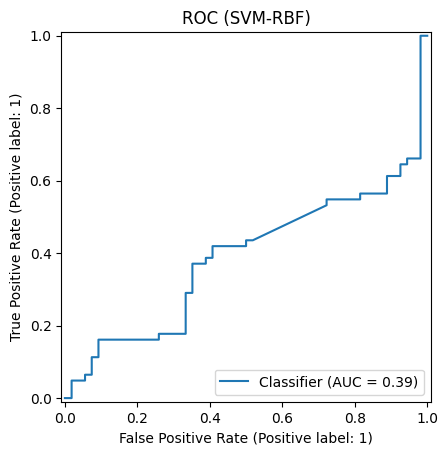


=== XGBOOST ===
Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
XGBoost mean Acc: 0.655, AUC: 0.740

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6400    0.5926    0.6154        54
   parkinson     0.6667    0.7097    0.6875        62

    accuracy                         0.6552       116
   macro avg     0.6533    0.6511    0.6514       116
weighted avg     0.6543    0.6552    0.6539       116

Confusion matrix:
 [[32 22]
 [18 44]]


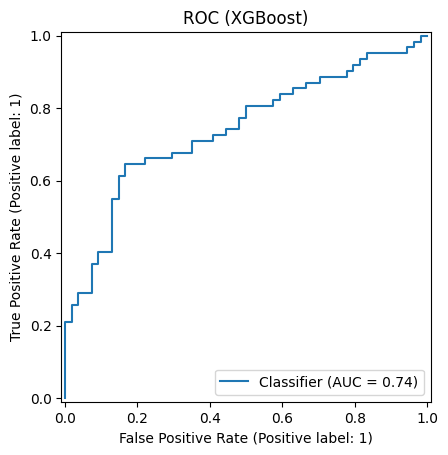

In [ ]:
# Colab: SVM-RBF + XGBoost with proper label encoding and CV
!pip -q install scikit-learn pandas numpy matplotlib xgboost

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------- Load ----------
CSV_PATH = "/content/spiral_features_new_increased2.csv"   # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# ---------- Features / labels ----------
X = df[[c for c in df.columns if c not in {"path","label"}]]
y_raw = df["label"].astype(str)

# Encode labels: healthy=0, parkinson=1
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------- Cross-validation setup ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_model(name, model, param_grid):
    print(f"\n=== {name.upper()} ===")
    # GridSearchCV
    gs = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
    gs.fit(X, y)
    best_model = gs.best_estimator_
    print("Best params:", gs.best_params_)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=cv, method="predict")
    y_proba = cross_val_predict(best_model, X, y, cv=cv, method="predict_proba")[:,1]

    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    print(f"{name} mean Acc: {acc:.3f}, AUC: {auc:.3f}")
    print("\nClassification report (all folds pooled):")
    print(classification_report(y, y_pred, target_names=le.classes_, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC ({name})")
    plt.show()
    return best_model

# ---------- Models ----------
svm_rbf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])
svm_params = {"clf__C":[0.3,1,3,10], "clf__gamma":[0.001,0.003,0.01,0.03]}

xgb = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    scale_pos_weight=len(y[y==0]) / len(y[y==1]) # handle class imbalance
)
xgb_params = {
    "n_estimators":[200,400],
    "max_depth":[3,6],
    "learning_rate":[0.05,0.1,0.2],
    "subsample":[0.8,1.0]
}

# ---------- Run ----------
best_svm = run_model("SVM-RBF", svm_rbf, svm_params)
best_xgb = run_model("XGBoost", xgb, xgb_params)


Loaded: (116, 89)
Class mapping: {'healthy': np.int64(0), 'parkinson': np.int64(1)}

=== SVM-RBF ===
Best params: {'clf__C': 0.3, 'clf__gamma': 0.001}
SVM-RBF CV Acc: 0.509, ROC-AUC: 0.394

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.4118    0.1296    0.1972        54
   parkinson     0.5253    0.8387    0.6460        62

    accuracy                         0.5086       116
   macro avg     0.4685    0.4842    0.4216       116
weighted avg     0.4724    0.5086    0.4370       116

Confusion matrix:
 [[ 7 47]
 [10 52]]


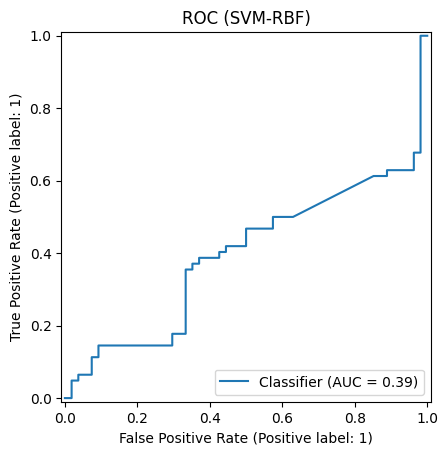


=== LOGREG ===
Best params: {'clf__C': 0.1}
LogReg CV Acc: 0.621, ROC-AUC: 0.639

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.5781    0.6852    0.6271        54
   parkinson     0.6731    0.5645    0.6140        62

    accuracy                         0.6207       116
   macro avg     0.6256    0.6249    0.6206       116
weighted avg     0.6289    0.6207    0.6201       116

Confusion matrix:
 [[37 17]
 [27 35]]


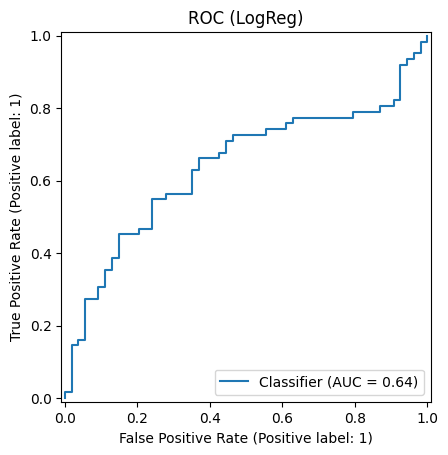


=== RANDOMFOREST ===
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2}
RandomForest CV Acc: 0.655, ROC-AUC: 0.709

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6296    0.6296    0.6296        54
   parkinson     0.6774    0.6774    0.6774        62

    accuracy                         0.6552       116
   macro avg     0.6535    0.6535    0.6535       116
weighted avg     0.6552    0.6552    0.6552       116

Confusion matrix:
 [[34 20]
 [20 42]]


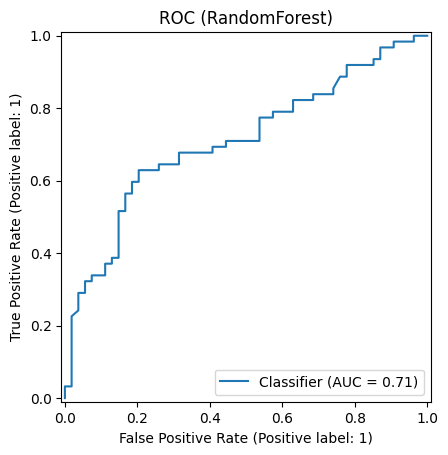


=== GRADIENTBOOSTING ===
Best params: {'clf__learning_rate': 0.05, 'clf__n_estimators': 200}
GradientBoosting CV Acc: 0.664, ROC-AUC: 0.707

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6316    0.6667    0.6486        54
   parkinson     0.6949    0.6613    0.6777        62

    accuracy                         0.6638       116
   macro avg     0.6632    0.6640    0.6632       116
weighted avg     0.6654    0.6638    0.6642       116

Confusion matrix:
 [[36 18]
 [21 41]]


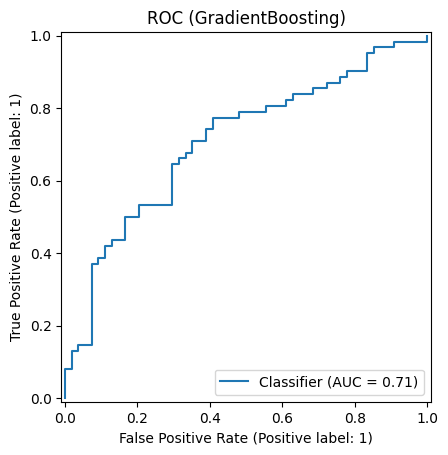


=== XGBOOST ===
Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
XGBoost CV Acc: 0.655, ROC-AUC: 0.740

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6400    0.5926    0.6154        54
   parkinson     0.6667    0.7097    0.6875        62

    accuracy                         0.6552       116
   macro avg     0.6533    0.6511    0.6514       116
weighted avg     0.6543    0.6552    0.6539       116

Confusion matrix:
 [[32 22]
 [18 44]]


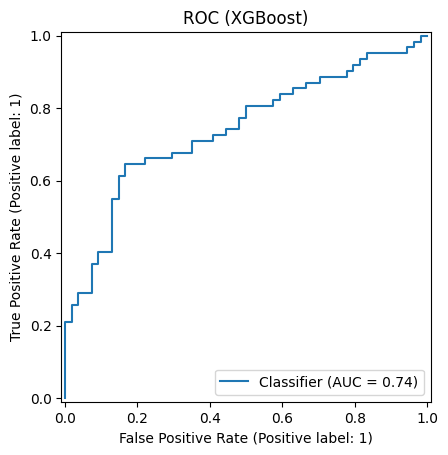


=== LIGHTGBM ===
[LightGBM] [Info] Number of positive: 62, number of negative: 54
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

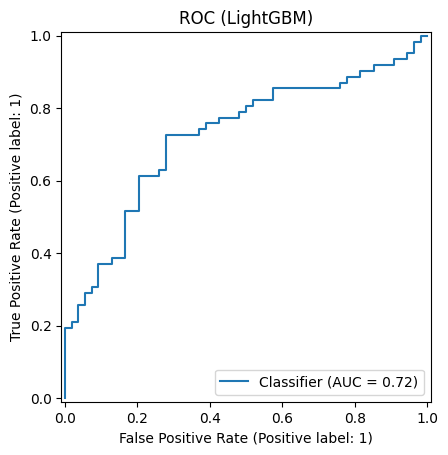

In [ ]:
# --- Install deps ---
!pip -q install scikit-learn pandas numpy matplotlib xgboost lightgbm

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------- Load ----------
CSV_PATH = "/content/spiral_features_new_increased2.csv"   # change if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# ---------- Features / labels ----------
X = df[[c for c in df.columns if c not in {"path","label"}]]
y_raw = df["label"].astype(str)

# Encode labels: healthy=0, parkinson=1
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------- Cross-validation setup ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_model(name, model, param_grid):
    print(f"\n=== {name.upper()} ===")
    gs = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
    gs.fit(X, y)
    best_model = gs.best_estimator_
    print("Best params:", gs.best_params_)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=cv, method="predict")
    y_proba = cross_val_predict(best_model, X, y, cv=cv, method="predict_proba")[:,1]

    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    print(f"{name} CV Acc: {acc:.3f}, ROC-AUC: {auc:.3f}")
    print("\nClassification report (all folds pooled):")
    print(classification_report(y, y_pred, target_names=le.classes_, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC ({name})")
    plt.show()
    return best_model

# ---------- Pipelines ----------
base_pipe = [
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("sel", SelectKBest(f_classif, k=50))  # keep top 50 features
]

svm_rbf = Pipeline(base_pipe + [
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])
svm_params = {"clf__C":[0.3,1,3,10], "clf__gamma":[0.001,0.003,0.01,0.03]}

logreg = Pipeline(base_pipe + [
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=42))
])
logreg_params = {"clf__C":[0.1,1,10]}

rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42))
])
rf_params = {"clf__max_depth":[None,10,20], "clf__min_samples_split":[2,5]}

gb = Pipeline(base_pipe + [
    ("clf", GradientBoostingClassifier(random_state=42))
])
gb_params = {"clf__n_estimators":[200,400], "clf__learning_rate":[0.05,0.1]}

xgb = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    scale_pos_weight=len(y[y==0]) / len(y[y==1])
)
xgb_params = {
    "n_estimators":[200,400],
    "max_depth":[3,6],
    "learning_rate":[0.05,0.1,0.2],
    "subsample":[0.8,1.0]
}

lgb = LGBMClassifier(random_state=42, class_weight="balanced")
lgb_params = {
    "n_estimators":[200,400],
    "num_leaves":[15,31,63],
    "learning_rate":[0.05,0.1,0.2]
}

# ---------- Run all ----------
best_svm = run_model("SVM-RBF", svm_rbf, svm_params)
best_logreg = run_model("LogReg", logreg, logreg_params)
best_rf = run_model("RandomForest", rf, rf_params)
best_gb = run_model("GradientBoosting", gb, gb_params)
best_xgb = run_model("XGBoost", xgb, xgb_params)
best_lgb = run_model("LightGBM", lgb, lgb_params)
